In [1]:
import os
#print (os.environ['CONDA_DEFAULT_ENV'])

### Recall Goal of Problem: predict up to 5 hotel clusters to recommend to users

Note: clusters are determined via an internal algorithm not exposed to us

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DATA_FOLDER = 'data'
CSV_EXTENSION = '.csv'
SRCH_DEST_ID = 'srch_destination_id'

## Read in Data

In [15]:
! ls data/

'ls' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


In [4]:
train = pd.read_csv(os.path.join(os.path.abspath(''), DATA_FOLDER, 'train.csv'), parse_dates = [0,11,12])
train.head()

date_time  site_name  posa_continent  user_location_country  \
0 2014-08-11 07:46:59          2               3                     66   
1 2014-08-11 08:22:12          2               3                     66   
2 2014-08-11 08:24:33          2               3                     66   
3 2014-08-09 18:05:16          2               3                     66   
4 2014-08-09 18:08:18          2               3                     66   

   user_location_region  user_location_city  orig_destination_distance  \
0                   348               48862                  2234.2641   
1                   348               48862                  2234.2641   
2                   348               48862                  2234.2641   
3                   442               35390                   913.1932   
4                   442               35390                   913.6259   

   user_id  is_mobile  is_package  ...  srch_children_cnt srch_rm_cnt  \
0       12          0           1  ...                  0           1   
1       12          0           1  ...                  0           1   
2       12          0           0  ...                  0           1   
3       93          0           0  ...                  0           1   
4       93          0           0  ...                  0           1   

  srch_destination_id  srch_destination_type_id  is_booking  cnt  \
0                8250                         1           0    3   
1                8250                         1           1    1   
2                8250                         1           0    1   
3               14984                         1           0    1   
4               14984                         1           0    1   

   hotel_continent  hotel_country  hotel_market  hotel_cluster  
0                2             50           628              1  
1                2             50           628              1  
2                2             50           628              1  
3                2             50          1457             80  
4                2             50          1457             21  

[5 rows x 24 columns]

In [5]:
destinations = pd.read_csv(os.path.join(os.path.abspath(''), DATA_FOLDER, 'destinations.csv'))
destinations.head()

srch_destination_id        d1        d2        d3        d4        d5  \
0                    0 -2.198657 -2.198657 -2.198657 -2.198657 -2.198657   
1                    1 -2.181690 -2.181690 -2.181690 -2.082564 -2.181690   
2                    2 -2.183490 -2.224164 -2.224164 -2.189562 -2.105819   
3                    3 -2.177409 -2.177409 -2.177409 -2.177409 -2.177409   
4                    4 -2.189562 -2.187783 -2.194008 -2.171153 -2.152303   

         d6        d7        d8        d9  ...      d140      d141      d142  \
0 -1.897627 -2.198657 -2.198657 -1.897627  ... -2.198657 -2.198657 -2.198657   
1 -2.165028 -2.181690 -2.181690 -2.031597  ... -2.165028 -2.181690 -2.165028   
2 -2.075407 -2.224164 -2.118483 -2.140393  ... -2.224164 -2.224164 -2.196379   
3 -2.115485 -2.177409 -2.177409 -2.177409  ... -2.161081 -2.177409 -2.177409   
4 -2.056618 -2.194008 -2.194008 -2.145911  ... -2.187356 -2.194008 -2.191779   

       d143      d144      d145      d146      d147      d148      d149  
0 -2.198657 -2.198657 -2.198657 -2.198657 -2.198657 -2.198657 -2.198657  
1 -2.181690 -2.181690 -2.165028 -2.181690 -2.181690 -2.181690 -2.181690  
2 -2.224164 -2.192009 -2.224164 -2.224164 -2.224164 -2.224164 -2.057548  
3 -2.177409 -2.177409 -2.177409 -2.177409 -2.177409 -2.177409 -2.177409  
4 -2.194008 -2.194008 -2.185161 -2.194008 -2.194008 -2.194008 -2.188037  

[5 rows x 150 columns]

<font color = 'magenta'> Note: the destinations csv joins to train csv on destination.srch_destination_id == train.srch_destination_id; would join, but destinations.csv has 149 columns. We should proabably join when actually training </font>

### to search:
- type of each column (float, int, cat/ord)
- distributions of each (min,  max, boxplots maybe?)
- colinear features?
- any NaNs?
- plots of clusters?


## Feature Types

screenshots grabbed from kaggle data description: [https://www.kaggle.com/c/expedia-hotel-recommendations/data?select=sample_submission.csv](https://www.kaggle.com/c/expedia-hotel-recommendations/data?select=sample_submission.csv)
![data-type-1](imgs/data-type-1.png)
![data-type-2](imgs/data-type-2.png)

<font color='blue'> 
    All the features are either an int or float, however upon closer inspection they all appear to be a categorical feature. The ones that are not are listed below:
    - orig_destination_distance
    - srch_ci
    - srch_co
    - srch_adults_cnt
    - srch_children_cnt
    - cnt
</font>

<br>
<br>
<font color='magenta'>
    We need to consider how to encode these in someway. one hot vs target? I think we should encode these, bc having srch_destination_id = 8250 is not inherently worse than having it = 14984. Also, scaling?. bc ids can get incredibly high
</font>

## NaNs?

In [ ]:
def get_cols_with_nas_percent_rows(df):
    res = []
    df_nas = df.isna().sum()/df.shape[0]
    for i, val in df_nas.items():
        if val > 0:
            res.append((i, val))
    return res

In [ ]:
def get_percent_cols_with_nas(df):
    cnt = 0
    for i, val in df.isna().sum().items():
        if val > 0:
            cnt += 1
    return cnt/len(df.columns)

In [ ]:
print(get_cols_with_nas_percent_rows(train))
print('% cols with nas:', get_percent_cols_with_nas(train) * 100)

[('orig_destination_distance', 0.35903625703150227), ('srch_ci', 0.0012498708199588466), ('srch_co', 0.0012498973660757032)]
% cols with nas: 12.5


<font color='magenta'>
In my opinion, 12.5% is not an insignificant number of columns with NaNs, so we shouldn't drop those column
</font>

<br>
<br>

<font color='magenta'>
Regarding the dropping the pts with NaNs, I'll leave that to @Austin & @Rishav to consider. 35% is a lot of rows and 12% is also not insignificant. But perhaps see if the distribution of hotel cluster would change if dropped those rows
</font>

In [ ]:
print(get_cols_with_nas_percent_rows(destinations))
print('% cols with nas:', get_percent_cols_with_nas(destinations) * 100)

[]
% cols with nas: 0.0


## Do we have all categorical ids for each feature?

In [ ]:
np.sort(train['site_name'].unique())

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 40, 41, 43, 44, 45, 46, 47, 48, 53], dtype=int64)

<font color='blue'>
    site_name ids do not incrememntally go up in the trian data. Note that it's missing ids 1, 42, and 49 (as well as a few others). Looking at posa_continent's min (which is 0), it is also feasible that site_name ids  is also missing id=0. It is odd for those numbers to be explicitly skipped. It's likely that the entire dataset has pts with those missing ids, but they're not present in our train set. This implies we'll probably have to handle seeing unknown/never-before-seen feature values in the test set.
</font>

In [ ]:
np.sort(train['user_location_country'].unique())

array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,
        80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 18

<font color='blue'>
    user_location_country is also missing some ids (like site_name). so the before mentioned problem is probalby going to be an issue accross all categorical features.
</font>

In [ ]:
destinations.describe()

srch_destination_id            d1            d2            d3  \
count         62106.000000  62106.000000  62106.000000  62106.000000   
mean          32359.463884     -2.193903     -2.202854     -2.207391   
std           18711.765765      0.038576      0.041065      0.040092   
min               0.000000     -2.597617     -2.671613     -2.671613   
25%           16320.250000     -2.209336     -2.220192     -2.223679   
50%           32277.500000     -2.185969     -2.193247     -2.195208   
75%           48467.750000     -2.175309     -2.179261     -2.179990   
max           64993.000000     -1.596004     -1.341325     -1.917826   

                 d4            d5            d6            d7            d8  \
count  62106.000000  62106.000000  62106.000000  62106.000000  62106.000000   
mean      -2.194040     -2.161497     -2.045110     -2.202433     -2.203207   
std        0.041406      0.066197      0.135803      0.038886      0.036578   
min       -2.671613     -2.671613     -2.344165     -2.671613     -2.671613   
25%       -2.211437     -2.192158     -2.154267     -2.218745     -2.219086   
50%       -2.188057     -2.178255     -2.088598     -2.192513     -2.192915   
75%       -2.176763     -2.153317     -1.975940     -2.178976     -2.179164   
max       -1.814585     -1.607558     -1.209058     -1.474441     -1.879678   

                 d9  ...          d140          d141          d142  \
count  62106.000000  ...  62106.000000  62106.000000  62106.000000   
mean      -2.107808  ...     -2.204092     -2.196919     -2.203262   
std        0.197904  ...      0.037164      0.059914      0.046520   
min       -2.495544  ...     -2.620769     -2.671613     -2.671613   
25%       -2.197704  ...     -2.219630     -2.216147     -2.220347   
50%       -2.177229  ...     -2.192232     -2.190525     -2.192814   
75%       -2.123598  ...     -2.178093     -2.177777     -2.178996   
max       -0.977219  ...     -1.855317     -0.960356     -1.357408   

               d143          d144          d145          d146          d147  \
count  62106.000000  62106.000000  62106.000000  62106.000000  62106.000000   
mean      -2.205128     -2.201925     -2.203332     -2.202989     -2.208359   
std        0.039465      0.041603      0.038239      0.051552      0.038035   
min       -2.671613     -2.671613     -2.671613     -2.671613     -2.671613   
25%       -2.221893     -2.218394     -2.220500     -2.221748     -2.224618   
50%       -2.194127     -2.191564     -2.192200     -2.193352     -2.196185   
75%       -2.179475     -2.178335     -2.177590     -2.178927     -2.180602   
max       -1.775218     -1.790435     -1.799341     -1.335962     -1.816892   

               d148          d149  
count  62106.000000  62106.000000  
mean      -2.208269     -2.199470  
std        0.038569      0.042438  
min       -2.671613     -2.671613  
25%       -2.224290     -2.216428  
50%       -2.195900     -2.190953  
75%       -2.180380     -2.178088  
max       -1.718778     -1.500309  

[8 rows x 150 columns]

In [ ]:
srch_dest_set = set(destinations[SRCH_DEST_ID])
srch_dest_id = 0
missing = []
while srch_dest_id <= destinations[SRCH_DEST_ID].max():
    if srch_dest_id not in srch_dest_set:
        missing.append(srch_dest_id)
    srch_dest_id += 1

In [ ]:
print(np.array(missing))
print(len(missing))

[   12    22   133 ... 64972 64984 64985]
2888


<font color='blue'>
    Interesting. Would have thought that we would have all ids for srch_destination_id in the destinations csv. Maybe they were distinctly left out? Are there srch_destination_ids in train that don't exist in destiantions? What about the other way around?
    </font>
   

In [ ]:
train_srch_dest_ids_set = set(train[SRCH_DEST_ID])
dest_srch_dest_ids_set = set(destinations[SRCH_DEST_ID])

print('in train not in dest:')
train_minus_dest = train_srch_dest_ids_set - dest_srch_dest_ids_set
print(len(train_minus_dest))

print()

print('in dest not in train:')
dest_minus_train = dest_srch_dest_ids_set - train_srch_dest_ids_set
print(len(dest_minus_train))

in train not in dest:
1662

in dest not in train:
4313


<font color='blue'>
    Okay, so apparently it's not 1-1. Data is rarely clean in the real world, so while unfortuante, not unexpected.
</font>
    
<br>
<br>
    
<font color = 'magenta'>
    Poses the question: what do we do now for ids in train, but not dest. should we impute the data? drop those rows?
    </font?

## Distributions of Features

<font color='magenta'>
    Based on what we defined as "insights from explorations" (some plots, relations, scaling", I'll leave this section to @Yinbo and @Junyi. Some (potentially) helpful things to plot: distribution of target variable (hotel_cluster) for each categorical var (maybe side-by-side bar plots?), maybe some sort of cluster plot? idk kinda just spitballing. Maybe take a look at hw1 for inspiration?
</font>

In [6]:
train.describe()

site_name  posa_continent  user_location_country  \
count  3.767029e+07    3.767029e+07           3.767029e+07   
mean   9.795271e+00    2.680473e+00           8.610880e+01   
std    1.196754e+01    7.480393e-01           5.924310e+01   
min    2.000000e+00    0.000000e+00           0.000000e+00   
25%    2.000000e+00    3.000000e+00           6.600000e+01   
50%    2.000000e+00    3.000000e+00           6.600000e+01   
75%    1.400000e+01    3.000000e+00           7.000000e+01   
max    5.300000e+01    4.000000e+00           2.390000e+02   

       user_location_region  user_location_city  orig_destination_distance  \
count          3.767029e+07        3.767029e+07               2.414529e+07   
mean           3.084060e+02        2.775304e+04               1.970090e+03   
std            2.084437e+02        1.678255e+04               2.232442e+03   
min            0.000000e+00        0.000000e+00               5.600000e-03   
25%            1.740000e+02        1.300900e+04               3.131670e+02   
50%            3.140000e+02        2.765500e+04               1.140491e+03   
75%            3.850000e+02        4.241300e+04               2.552599e+03   
max            1.027000e+03        5.650800e+04               1.240790e+04   

            user_id     is_mobile    is_package       channel  ...  \
count  3.767029e+07  3.767029e+07  3.767029e+07  3.767029e+07  ...   
mean   6.044518e+05  1.349265e-01  2.489042e-01  5.870761e+00  ...   
std    3.506175e+05  3.416451e-01  4.323782e-01  3.717095e+00  ...   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  ...   
25%    2.989100e+05  0.000000e+00  0.000000e+00  2.000000e+00  ...   
50%    6.039140e+05  0.000000e+00  0.000000e+00  9.000000e+00  ...   
75%    9.101680e+05  0.000000e+00  0.000000e+00  9.000000e+00  ...   
max    1.198785e+06  1.000000e+00  1.000000e+00  1.000000e+01  ...   

       srch_children_cnt   srch_rm_cnt  srch_destination_id  \
count       3.767029e+07  3.767029e+07         3.767029e+07   
mean        3.321222e-01  1.112663e+00         1.444109e+04   
std         7.314981e-01  4.591155e-01         1.106630e+04   
min         0.000000e+00  0.000000e+00         0.000000e+00   
25%         0.000000e+00  1.000000e+00         8.267000e+03   
50%         0.000000e+00  1.000000e+00         9.147000e+03   
75%         0.000000e+00  1.000000e+00         1.879000e+04   
max         9.000000e+00  8.000000e+00         6.510700e+04   

       srch_destination_type_id    is_booking           cnt  hotel_continent  \
count              3.767029e+07  3.767029e+07  3.767029e+07     3.767029e+07   
mean               2.582280e+00  7.965675e-02  1.483384e+00     3.156305e+00   
std                2.153019e+00  2.707611e-01  1.219776e+00     1.623189e+00   
min                0.000000e+00  0.000000e+00  1.000000e+00     0.000000e+00   
25%                1.000000e+00  0.000000e+00  1.000000e+00     2.000000e+00   
50%                1.000000e+00  0.000000e+00  1.000000e+00     2.000000e+00   
75%                5.000000e+00  0.000000e+00  2.000000e+00     4.000000e+00   
max                9.000000e+00  1.000000e+00  2.690000e+02     6.000000e+00   

       hotel_country  hotel_market  hotel_cluster  
count   3.767029e+07  3.767029e+07   3.767029e+07  
mean    8.129685e+01  6.004619e+02   4.980861e+01  
std     5.617119e+01  5.117391e+02   2.891595e+01  
min     0.000000e+00  0.000000e+00   0.000000e+00  
25%     5.000000e+01  1.600000e+02   2.500000e+01  
50%     5.000000e+01  5.930000e+02   4.900000e+01  
75%     1.060000e+02  7.010000e+02   7.300000e+01  
max     2.120000e+02  2.117000e+03   9.900000e+01  

[8 rows x 21 columns]

In [7]:
destinations.describe()

srch_destination_id            d1            d2            d3  \
count         62106.000000  62106.000000  62106.000000  62106.000000   
mean          32359.463884     -2.193903     -2.202854     -2.207391   
std           18711.765765      0.038576      0.041065      0.040092   
min               0.000000     -2.597617     -2.671613     -2.671613   
25%           16320.250000     -2.209336     -2.220192     -2.223679   
50%           32277.500000     -2.185969     -2.193247     -2.195208   
75%           48467.750000     -2.175309     -2.179261     -2.179990   
max           64993.000000     -1.596004     -1.341325     -1.917826   

                 d4            d5            d6            d7            d8  \
count  62106.000000  62106.000000  62106.000000  62106.000000  62106.000000   
mean      -2.194040     -2.161497     -2.045110     -2.202433     -2.203207   
std        0.041406      0.066197      0.135803      0.038886      0.036578   
min       -2.671613     -2.671613     -2.344165     -2.671613     -2.671613   
25%       -2.211437     -2.192158     -2.154267     -2.218745     -2.219086   
50%       -2.188057     -2.178255     -2.088598     -2.192513     -2.192915   
75%       -2.176763     -2.153317     -1.975940     -2.178976     -2.179164   
max       -1.814585     -1.607558     -1.209058     -1.474441     -1.879678   

                 d9  ...          d140          d141          d142  \
count  62106.000000  ...  62106.000000  62106.000000  62106.000000   
mean      -2.107808  ...     -2.204092     -2.196919     -2.203262   
std        0.197904  ...      0.037164      0.059914      0.046520   
min       -2.495544  ...     -2.620769     -2.671613     -2.671613   
25%       -2.197704  ...     -2.219630     -2.216147     -2.220347   
50%       -2.177229  ...     -2.192232     -2.190525     -2.192814   
75%       -2.123598  ...     -2.178093     -2.177777     -2.178996   
max       -0.977219  ...     -1.855317     -0.960356     -1.357408   

               d143          d144          d145          d146          d147  \
count  62106.000000  62106.000000  62106.000000  62106.000000  62106.000000   
mean      -2.205128     -2.201925     -2.203332     -2.202989     -2.208359   
std        0.039465      0.041603      0.038239      0.051552      0.038035   
min       -2.671613     -2.671613     -2.671613     -2.671613     -2.671613   
25%       -2.221893     -2.218394     -2.220500     -2.221748     -2.224618   
50%       -2.194127     -2.191564     -2.192200     -2.193352     -2.196185   
75%       -2.179475     -2.178335     -2.177590     -2.178927     -2.180602   
max       -1.775218     -1.790435     -1.799341     -1.335962     -1.816892   

               d148          d149  
count  62106.000000  62106.000000  
mean      -2.208269     -2.199470  
std        0.038569      0.042438  
min       -2.671613     -2.671613  
25%       -2.224290     -2.216428  
50%       -2.195900     -2.190953  
75%       -2.180380     -2.178088  
max       -1.718778     -1.500309  

[8 rows x 150 columns]

In [6]:
train['srch_ci'] = pd.to_datetime(train['srch_ci'], errors='coerce')
train['srch_before_ci'] = pd.to_numeric((train['srch_ci'] - train['date_time']).dt.days, errors='coerce', downcast='integer')
cols = train.columns.tolist()
cols = cols[-1:] + cols[:-1]
train = train[cols]

I think what matters for datetime variables are 
* how many days a search is done prior to check-in date 
* intend accommodate days 

In [7]:
train.head()

srch_before_ci           date_time  site_name  posa_continent  \
0            15.0 2014-08-11 07:46:59          2               3   
1            17.0 2014-08-11 08:22:12          2               3   
2            17.0 2014-08-11 08:24:33          2               3   
3           105.0 2014-08-09 18:05:16          2               3   
4           105.0 2014-08-09 18:08:18          2               3   

   user_location_country  user_location_region  user_location_city  \
0                     66                   348               48862   
1                     66                   348               48862   
2                     66                   348               48862   
3                     66                   442               35390   
4                     66                   442               35390   

   orig_destination_distance  user_id  is_mobile  ...  srch_children_cnt  \
0                  2234.2641       12          0  ...                  0   
1                  2234.2641       12          0  ...                  0   
2                  2234.2641       12          0  ...                  0   
3                   913.1932       93          0  ...                  0   
4                   913.6259       93          0  ...                  0   

   srch_rm_cnt srch_destination_id srch_destination_type_id  is_booking  cnt  \
0            1                8250                        1           0    3   
1            1                8250                        1           1    1   
2            1                8250                        1           0    1   
3            1               14984                        1           0    1   
4            1               14984                        1           0    1   

   hotel_continent  hotel_country  hotel_market  hotel_cluster  
0                2             50           628              1  
1                2             50           628              1  
2                2             50           628              1  
3                2             50          1457             80  
4                2             50          1457             21  

[5 rows x 25 columns]

In [8]:
book_cluster = pd.DataFrame(np.zeros([100,2]))
book_cluster.columns = ['not book', 'book']
for i in range(100):
    x = train[train['hotel_cluster'] == i].groupby('is_booking').count()['hotel_cluster']
    book_cluster.iloc[i,0] = x[0]
    book_cluster.iloc[i,1] = x[1]
book_cluster


not book     book
0   360666.0  19227.0
1   414244.0  38450.0
2   389464.0  45055.0
3   212837.0  12413.0
4   316260.0  35589.0
..       ...      ...
95  454141.0  55125.0
96  353252.0  16710.0
97  450276.0  29170.0
98  540217.0  48961.0
99  405925.0  38962.0

[100 rows x 2 columns]

### How many search are booked in training set 

Text(0.5, 0, 'search count')

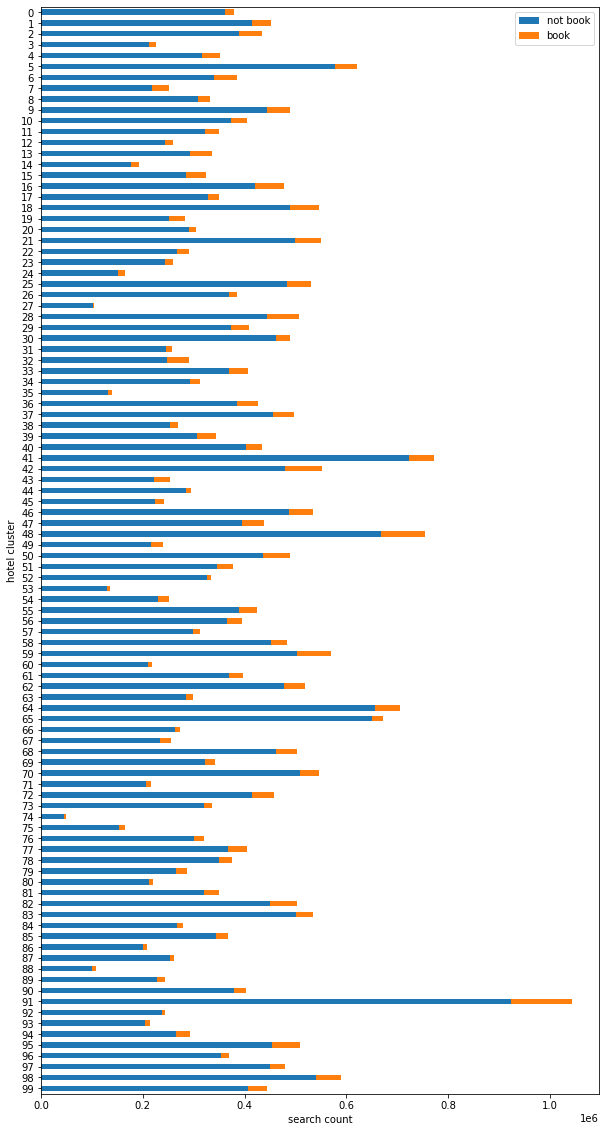

In [9]:
fig, ax = plt.subplots(figsize=(10,20))
book_cluster.plot.barh(stacked=True, ax=ax)
plt.gca().invert_yaxis()
plt.ylabel('hotel cluster')
plt.xlabel('search count')

In [10]:
book_percentage = pd.DataFrame()
book_percentage['not book'] = book_cluster['not book'] / book_cluster.sum(axis=1)
book_percentage['book'] = book_cluster['book'] / book_cluster.sum(axis=1)
book_percentage

not book      book
0   0.949388  0.050612
1   0.915064  0.084936
2   0.896311  0.103689
3   0.944892  0.055108
4   0.898851  0.101149
..       ...       ...
95  0.891756  0.108244
96  0.954833  0.045167
97  0.939159  0.060841
98  0.916899  0.083101
99  0.912423  0.087577

[100 rows x 2 columns]

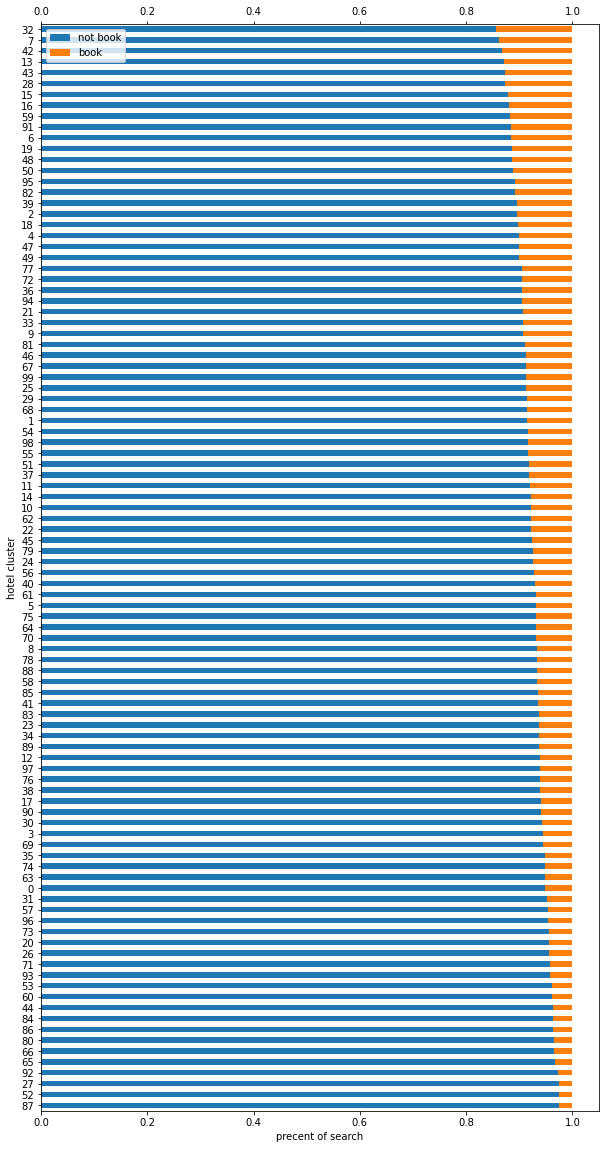

In [11]:
book_percentage_sorted = book_percentage.sort_values(by='book', ascending=False)
fig, ax = plt.subplots(figsize=(10,20))
book_percentage_sorted.plot.barh(stacked=True, ax=ax)
plt.gca().invert_yaxis()
plt.ylabel('hotel cluster')
plt.xlabel('precent of search')
plt.legend(loc='upper left')
ax.tick_params(axis="x", bottom=True, top=True, labelbottom=True, labeltop=True)

In [12]:
train[train['hotel_cluster'] == 0].groupby('srch_destination_id').size()

srch_destination_id
107       13
154       37
383      267
511       14
513      194
        ... 
63726      7
63839      5
63841      1
63842      3
64537      1
Length: 525, dtype: int64

### The only continuous feature in train.csv - orig_destination_distance (actually, we can add days before checkin, intended accommodate period as continuous features as well)

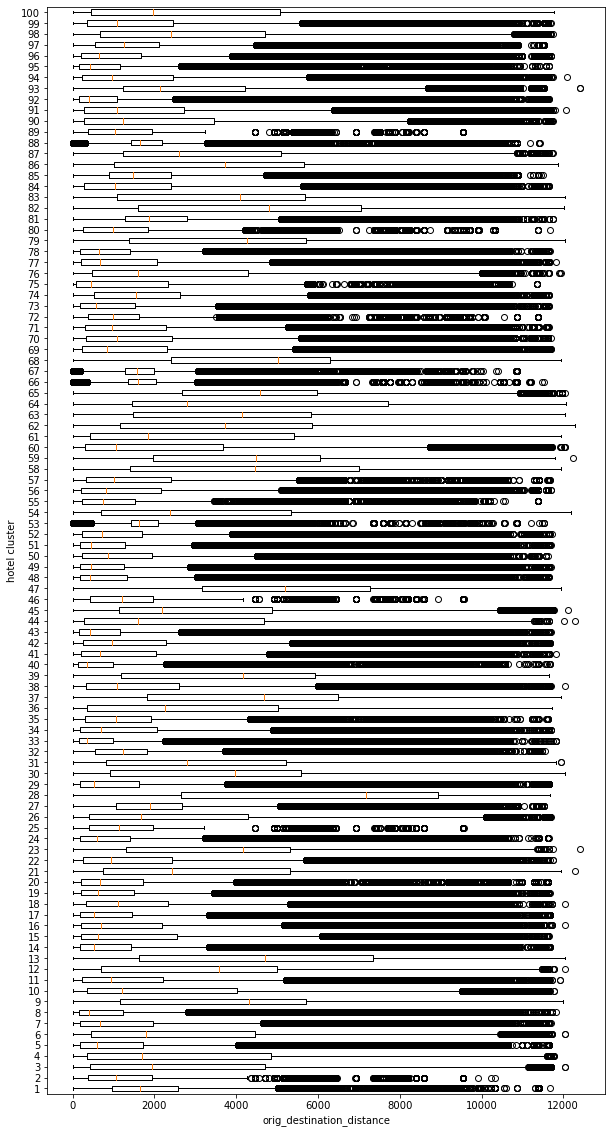

In [56]:
data=[]
for i in range(100):
    data.append(train[train['hotel_cluster'] == i]['orig_destination_distance'].to_numpy())
    data[i] = data[i][~np.isnan(data[i])]

fig, ax = plt.subplots(figsize=(10,20))
plt.boxplot(data, showfliers=True, vert=False)
plt.xlabel('orig_destination_distance')
plt.ylabel('hotel cluster')
plt.savefig(f'./imgs/destination feature/orig_destination_distance_cluster.png')

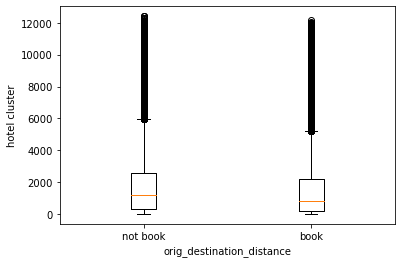

In [69]:
data=[]
for i in range(2):
    data.append(train[train['is_booking'] == i]['orig_destination_distance'].to_numpy())
    data[i] = data[i][~np.isnan(data[i])]

fig, ax = plt.subplots()
plt.boxplot(data, showfliers=True)
plt.xticks([1,2], ['not book', 'book'])
plt.xlabel('orig_destination_distance')
plt.ylabel('hotel cluster')
plt.savefig(f'./imgs/destination feature/orig_destination_distance_booking.png')

### 150 features in destination.csv. These continuous features have favorable variance between predicted hotel clusters, would definitly use for training. (But joining the whole set to training set would consume more than 30 GB RAM, so we have to find ways to reduce dimension. PCA?)

In [8]:
destinations.index = destinations['srch_destination_id']
destinations.head()

srch_destination_id        d1        d2        d3  \
srch_destination_id                                                      
0                                      0 -2.198657 -2.198657 -2.198657   
1                                      1 -2.181690 -2.181690 -2.181690   
2                                      2 -2.183490 -2.224164 -2.224164   
3                                      3 -2.177409 -2.177409 -2.177409   
4                                      4 -2.189562 -2.187783 -2.194008   

                           d4        d5        d6        d7        d8  \
srch_destination_id                                                     
0                   -2.198657 -2.198657 -1.897627 -2.198657 -2.198657   
1                   -2.082564 -2.181690 -2.165028 -2.181690 -2.181690   
2                   -2.189562 -2.105819 -2.075407 -2.224164 -2.118483   
3                   -2.177409 -2.177409 -2.115485 -2.177409 -2.177409   
4                   -2.171153 -2.152303 -2.056618 -2.194008 -2.194008   

                           d9  ...      d140      d141      d142      d143  \
srch_destination_id            ...                                           
0                   -1.897627  ... -2.198657 -2.198657 -2.198657 -2.198657   
1                   -2.031597  ... -2.165028 -2.181690 -2.165028 -2.181690   
2                   -2.140393  ... -2.224164 -2.224164 -2.196379 -2.224164   
3                   -2.177409  ... -2.161081 -2.177409 -2.177409 -2.177409   
4                   -2.145911  ... -2.187356 -2.194008 -2.191779 -2.194008   

                         d144      d145      d146      d147      d148  \
srch_destination_id                                                     
0                   -2.198657 -2.198657 -2.198657 -2.198657 -2.198657   
1                   -2.181690 -2.165028 -2.181690 -2.181690 -2.181690   
2                   -2.192009 -2.224164 -2.224164 -2.224164 -2.224164   
3                   -2.177409 -2.177409 -2.177409 -2.177409 -2.177409   
4                   -2.194008 -2.185161 -2.194008 -2.194008 -2.194008   

                         d149  
srch_destination_id            
0                   -2.198657  
1                   -2.181690  
2                   -2.057548  
3                   -2.177409  
4                   -2.188037  

[5 rows x 150 columns]

we can use some of the features in destination to prodict hotel cluster. Or I saw them use PCA of these 150 features in media reports. 

<ipython-input-68-d56ae9934bec>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,20))


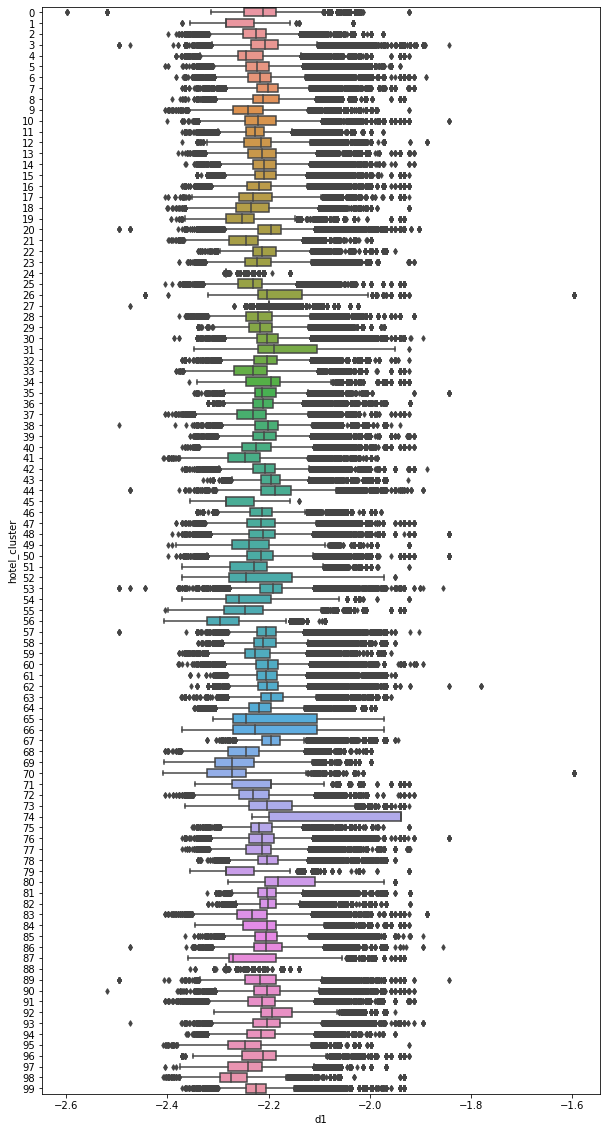

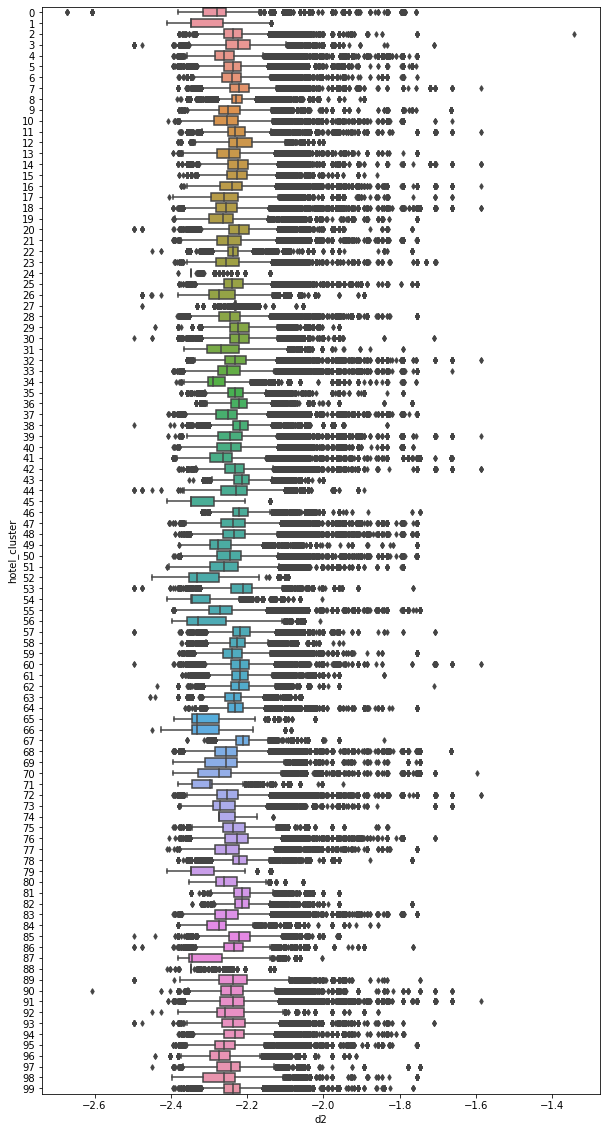

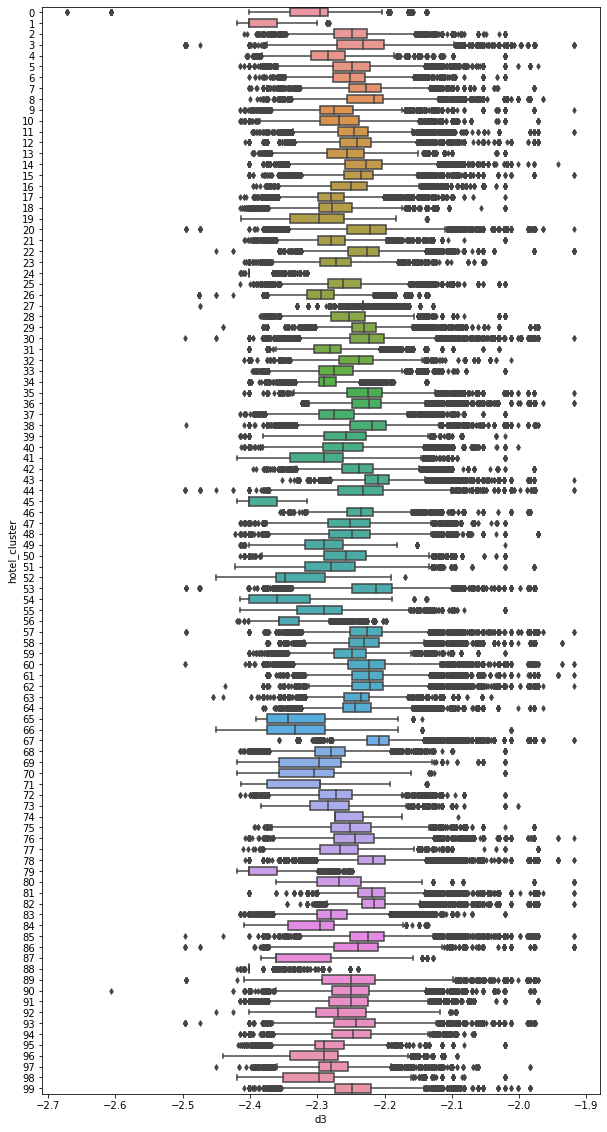

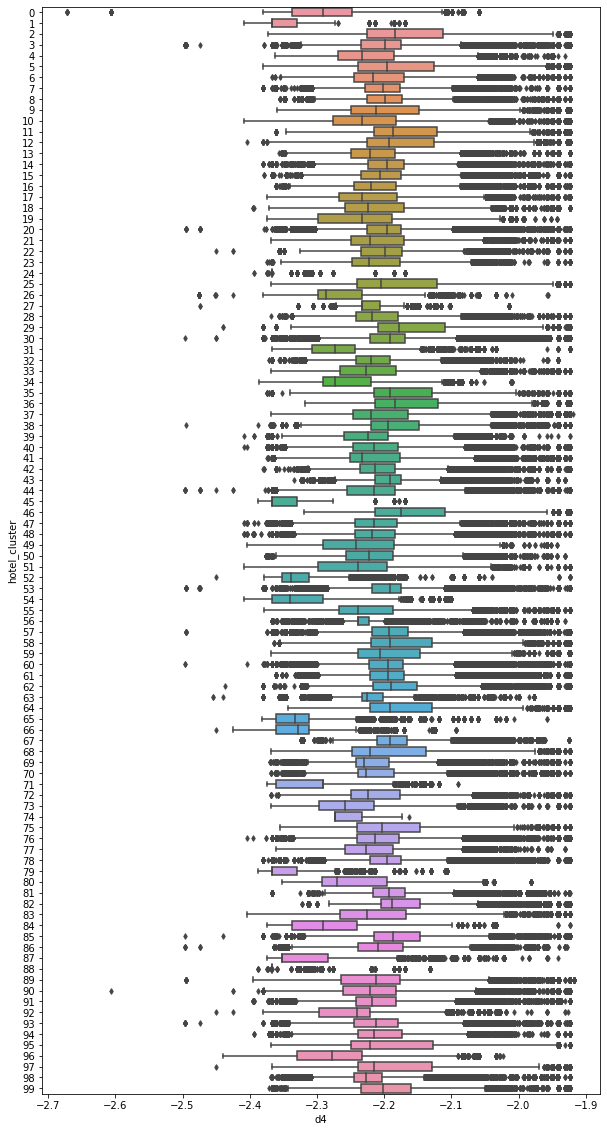

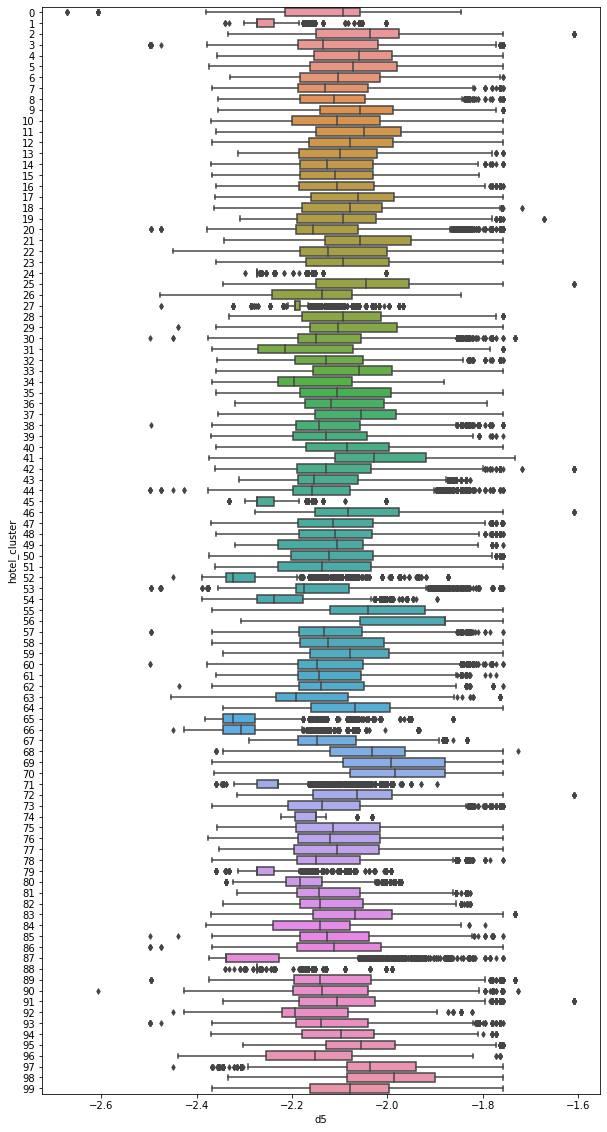

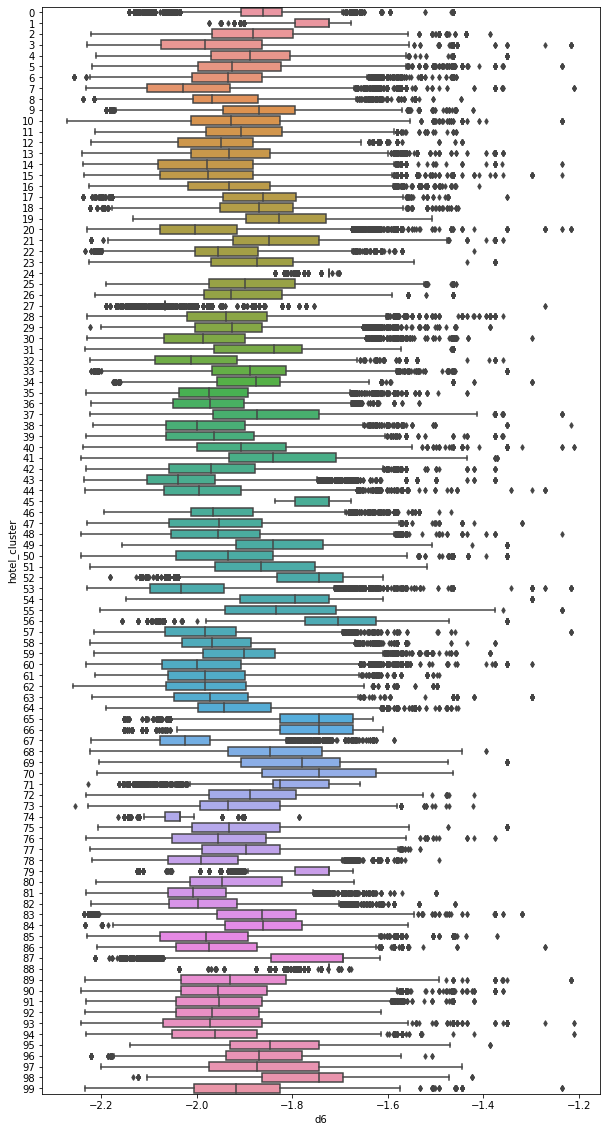

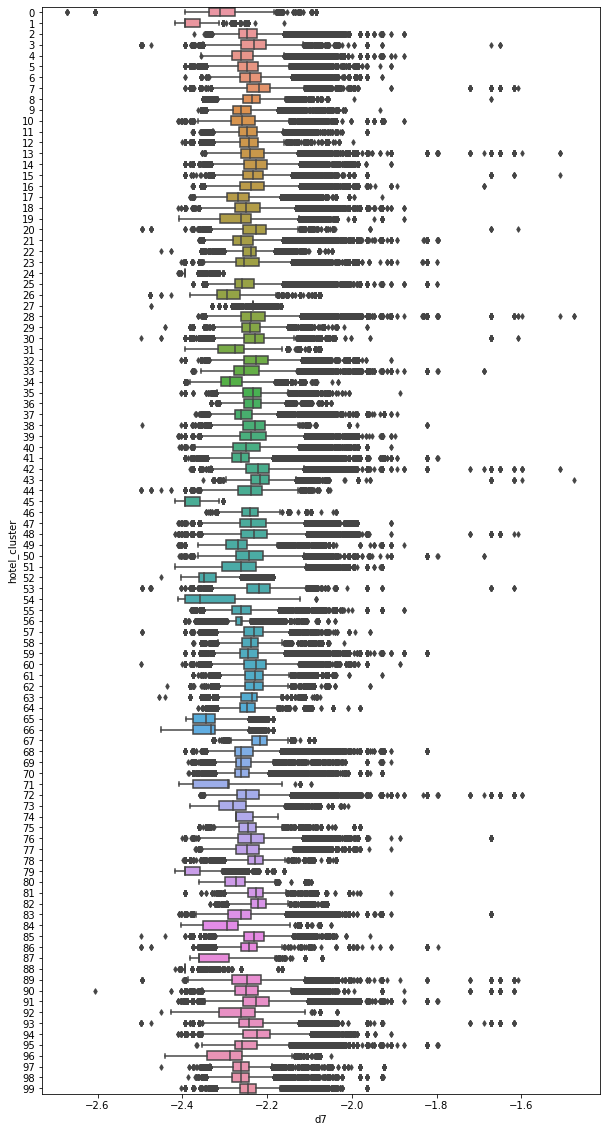

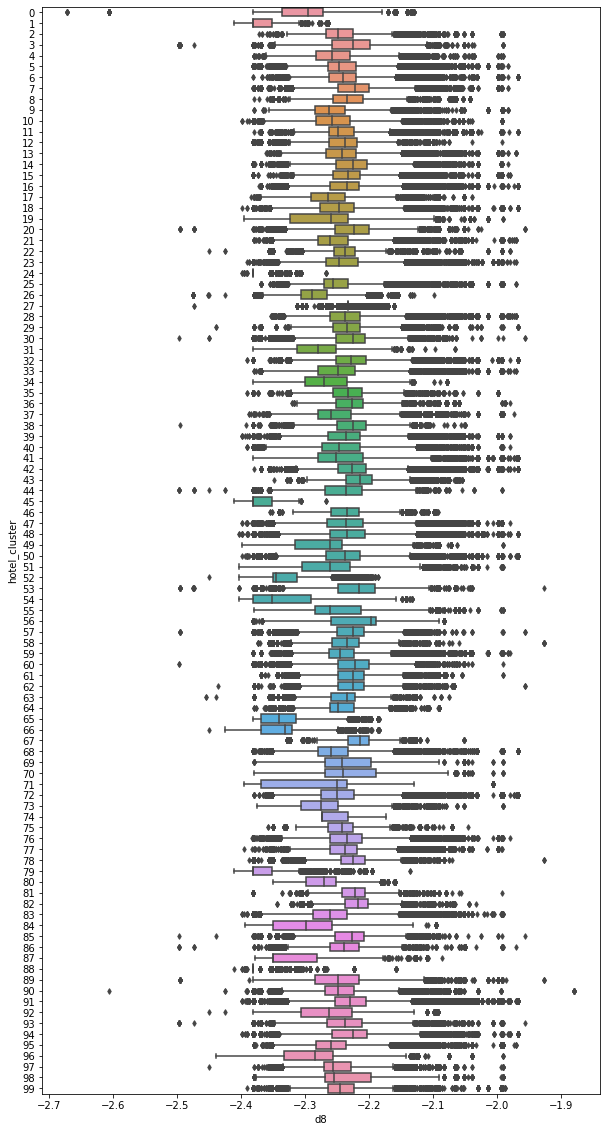

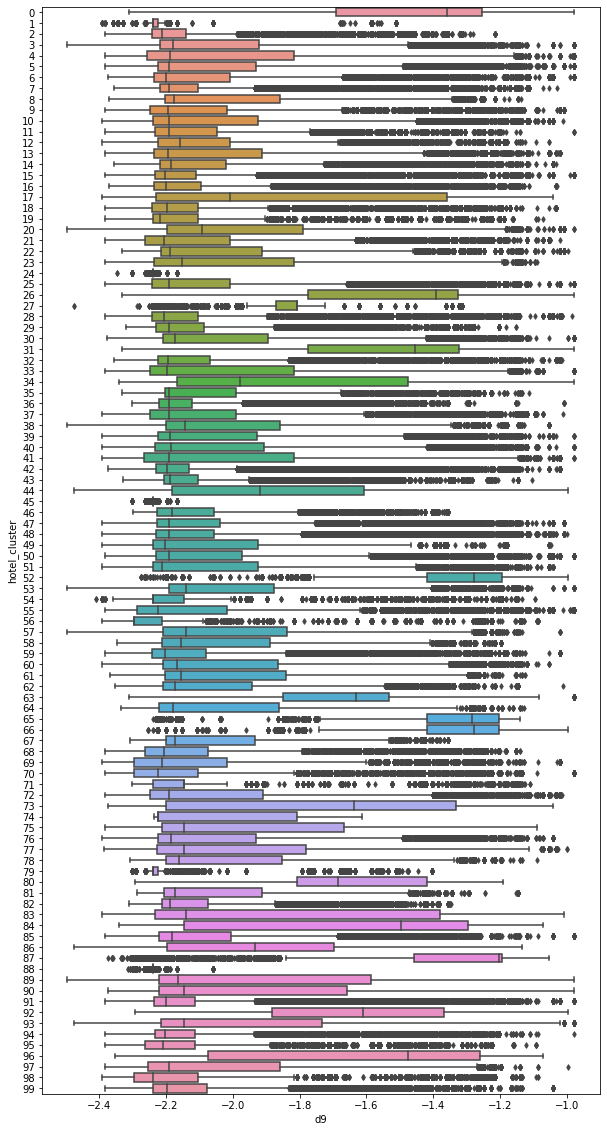

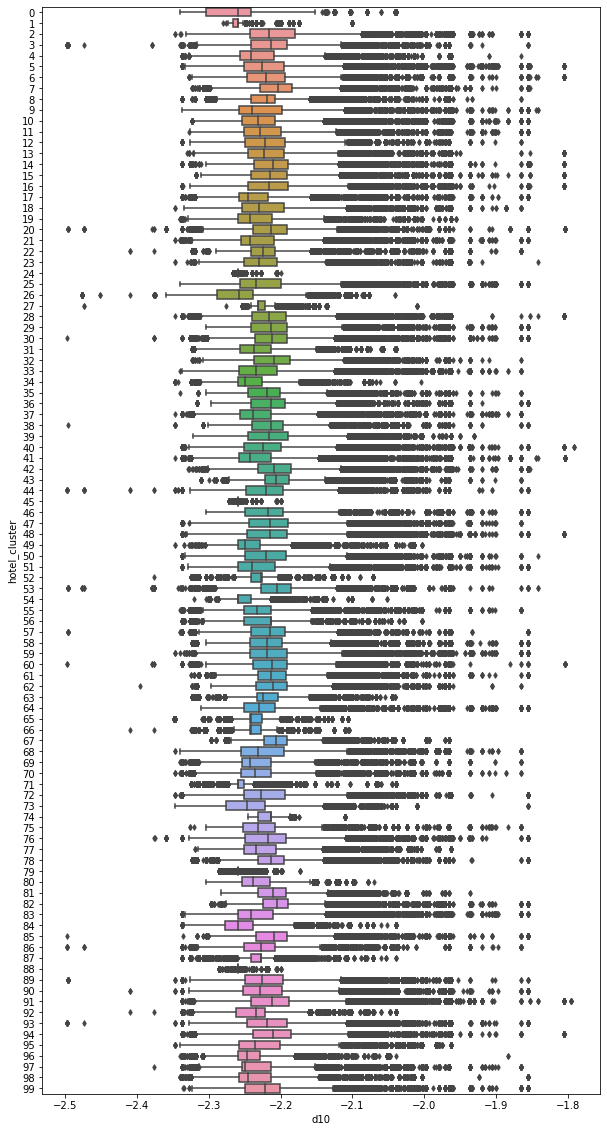

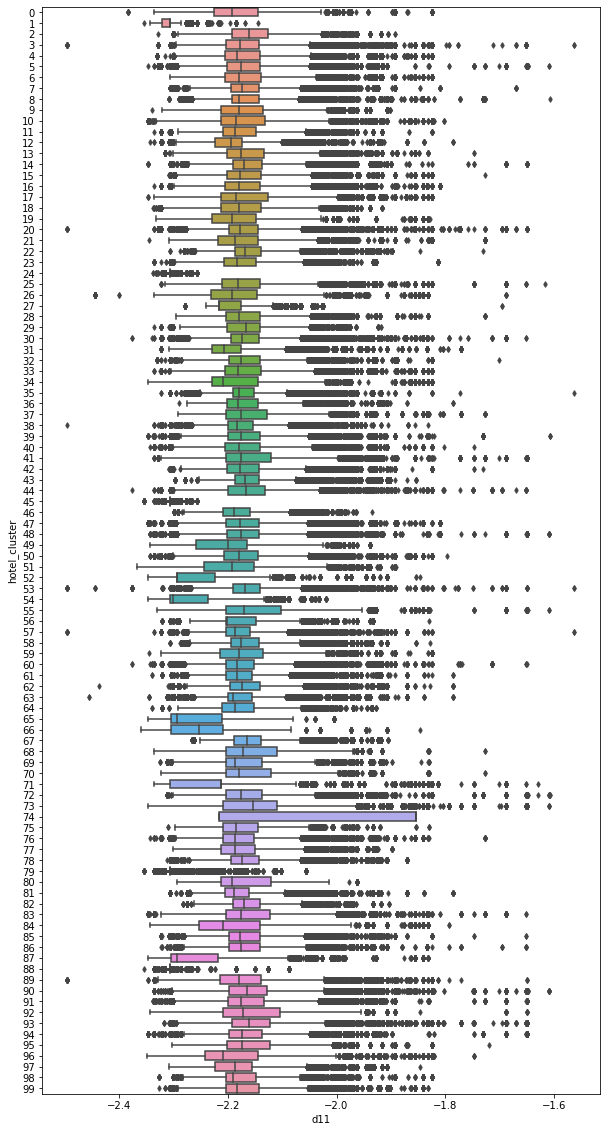

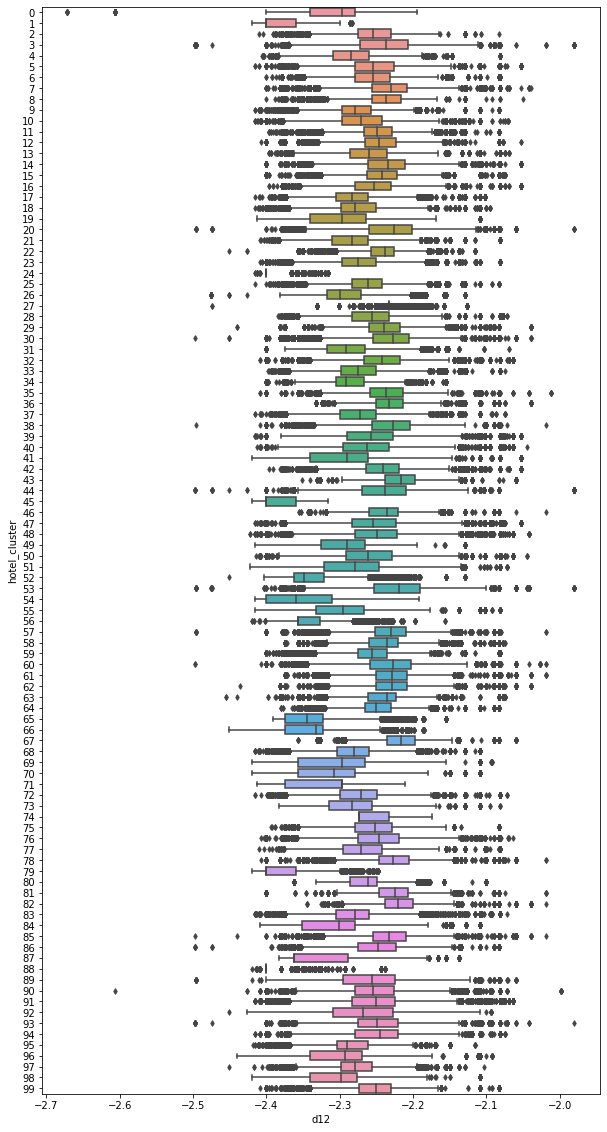

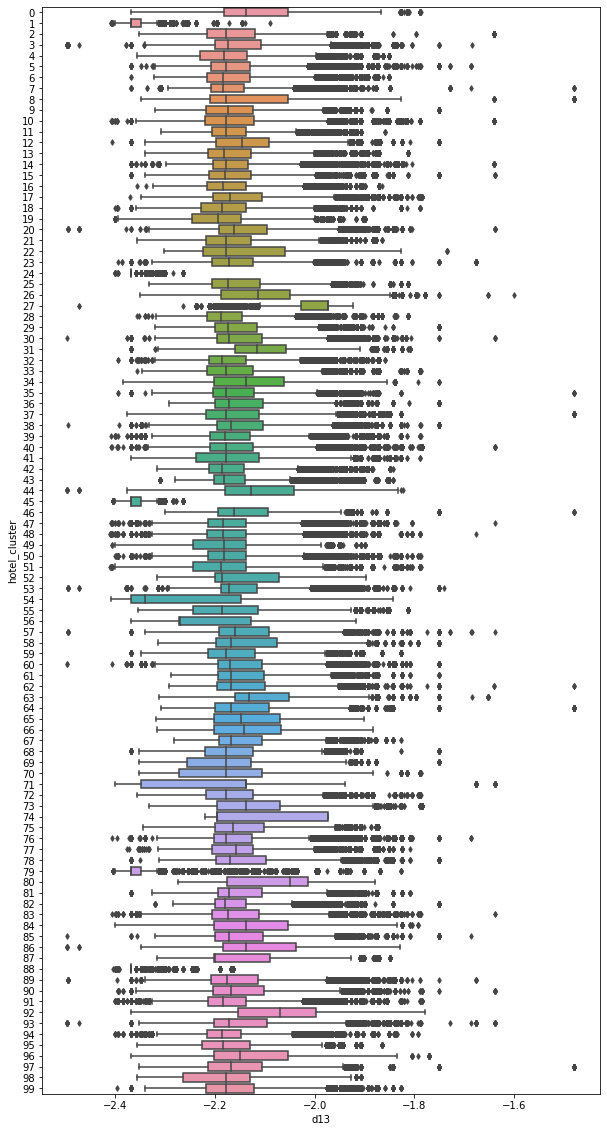

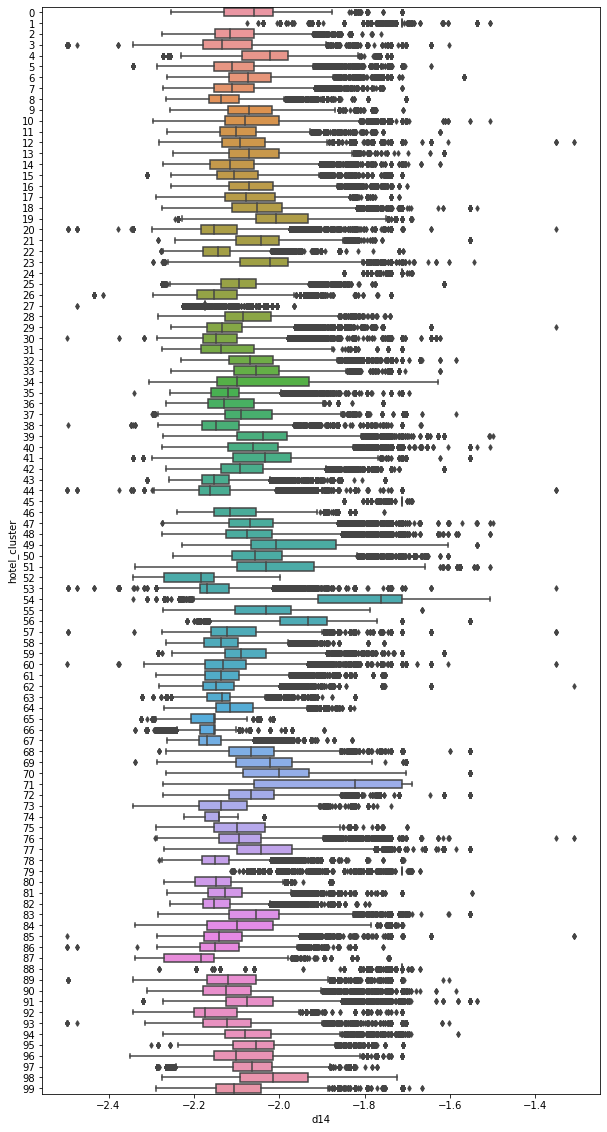

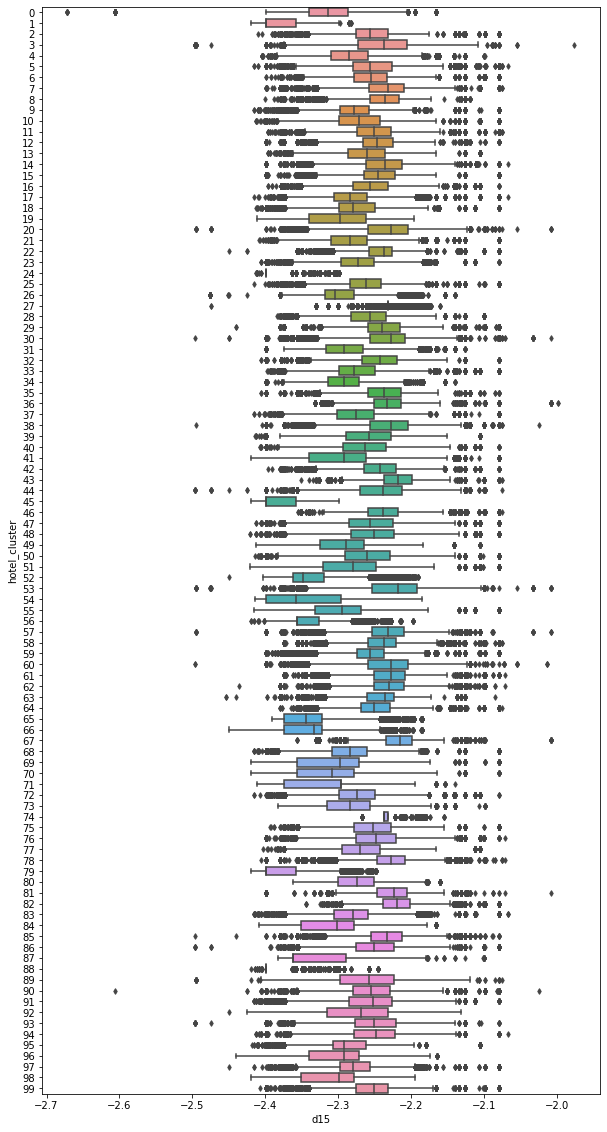

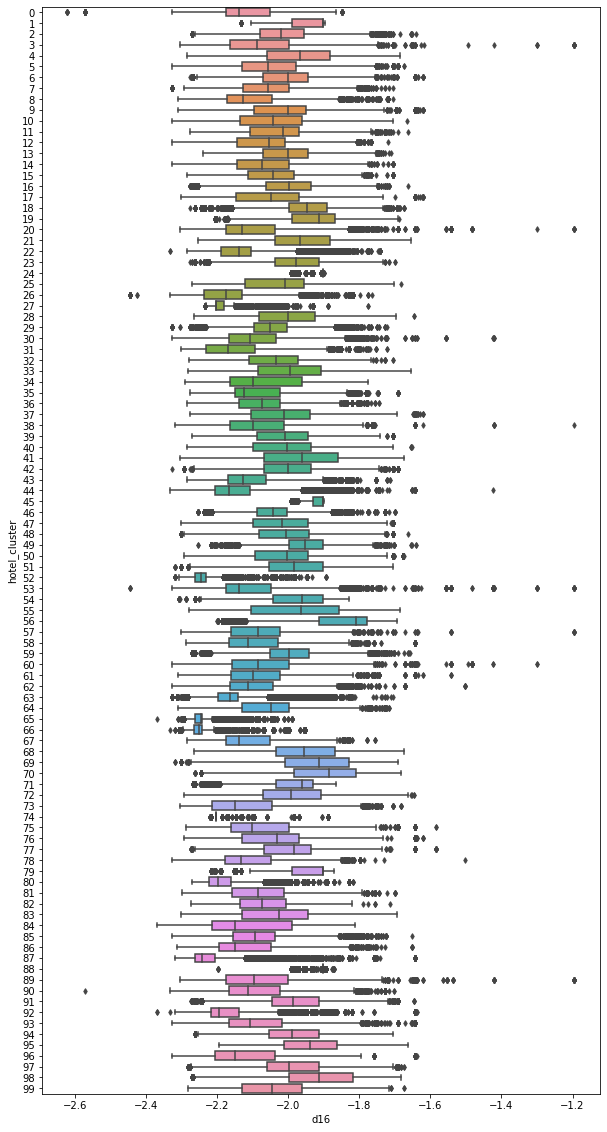

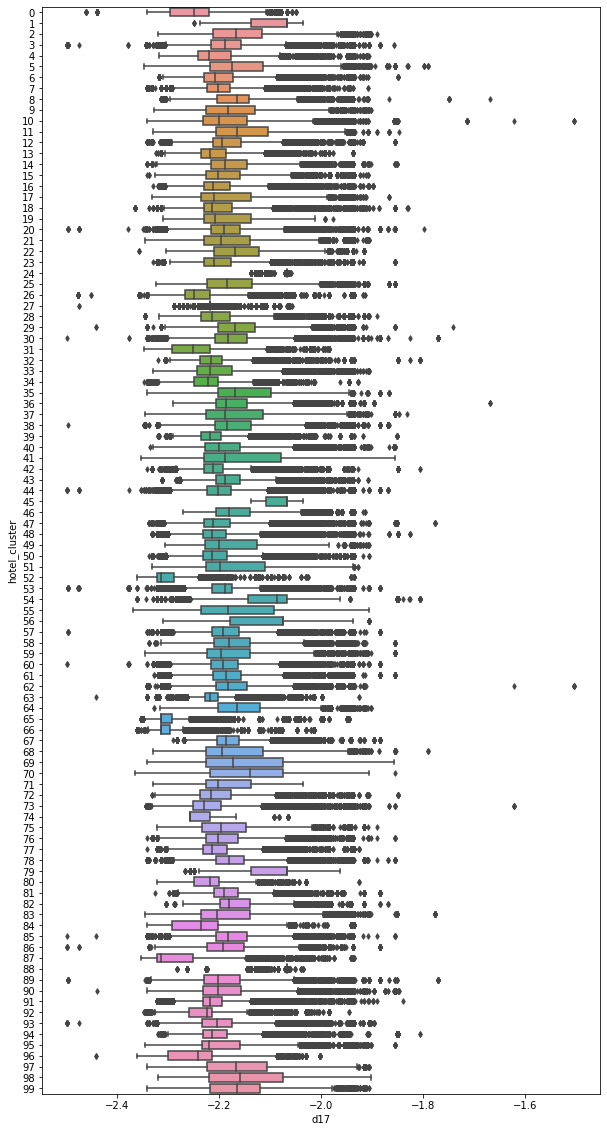

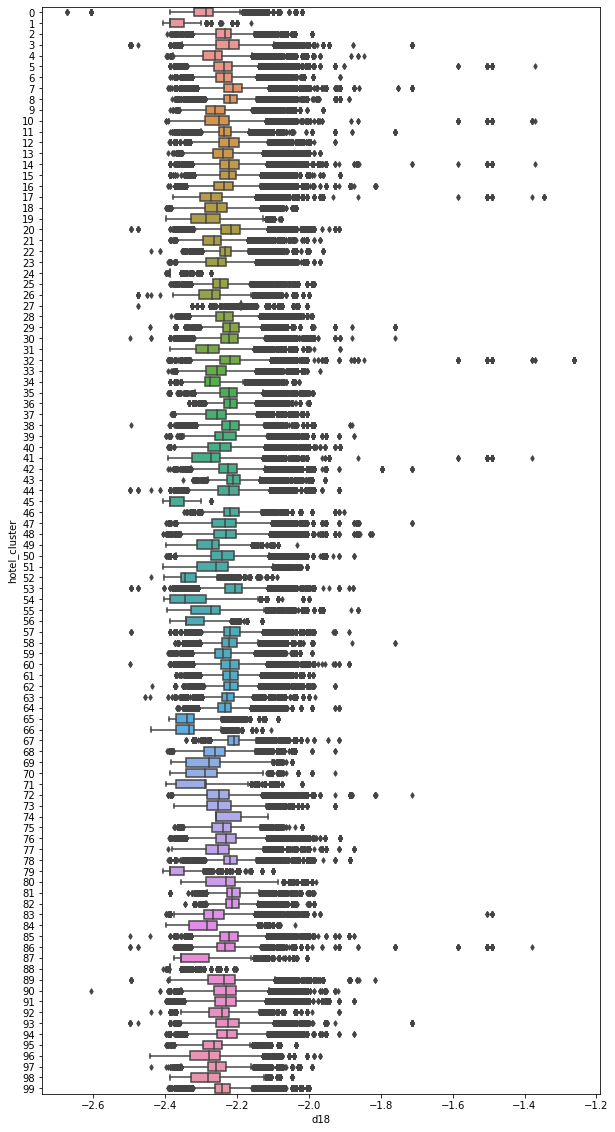

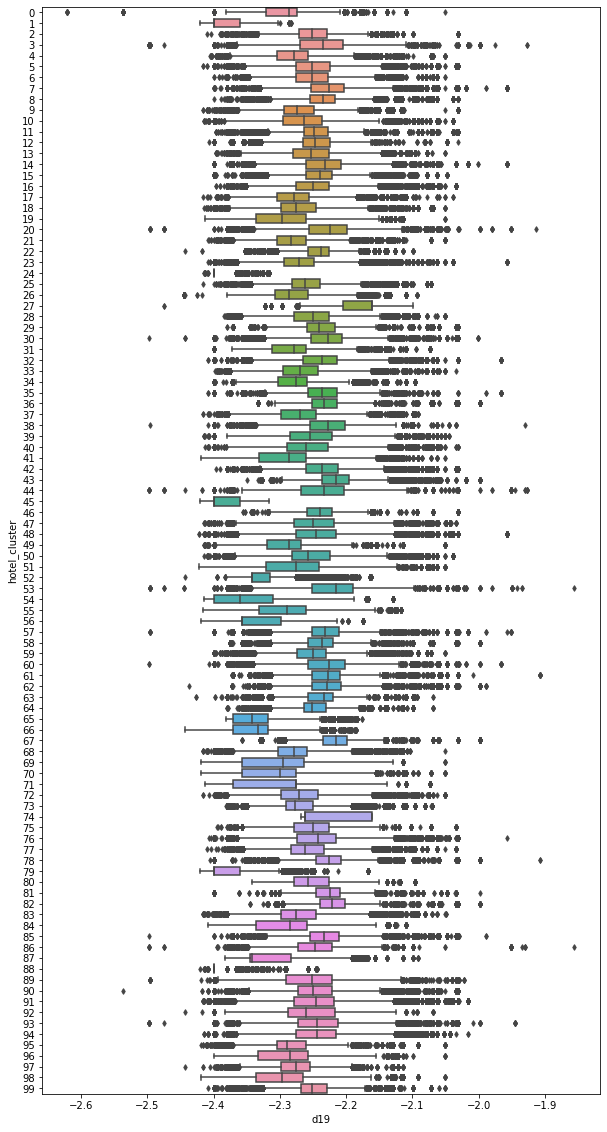

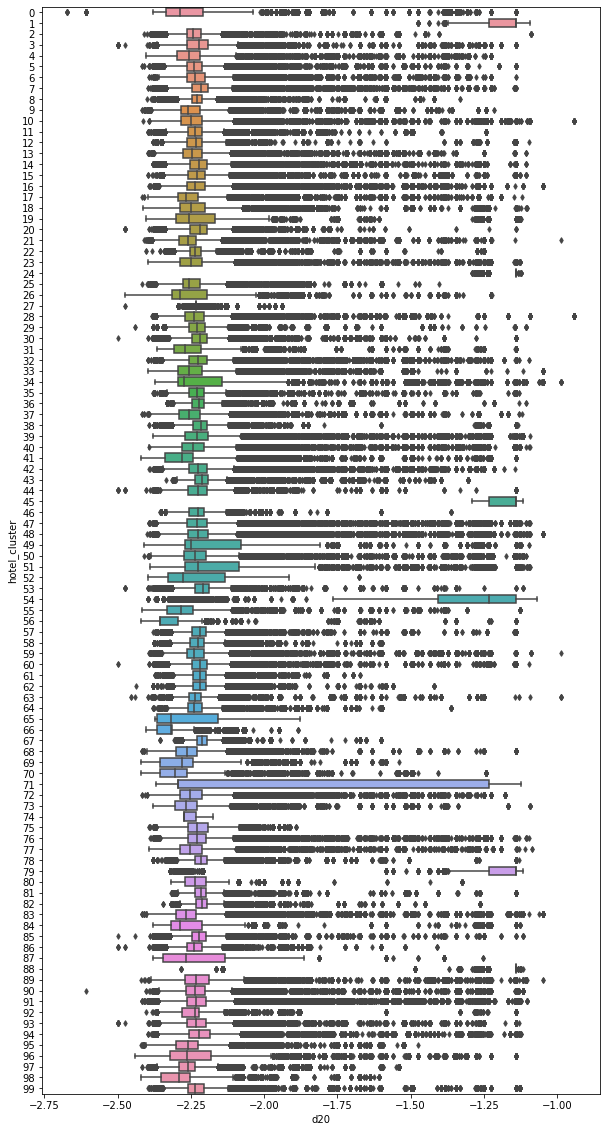

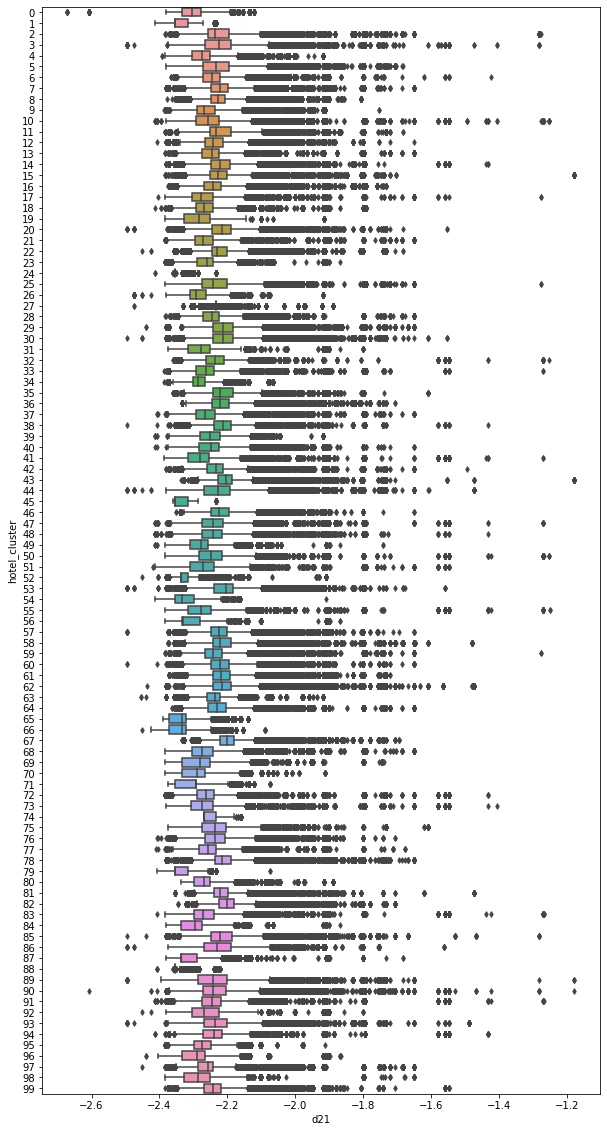

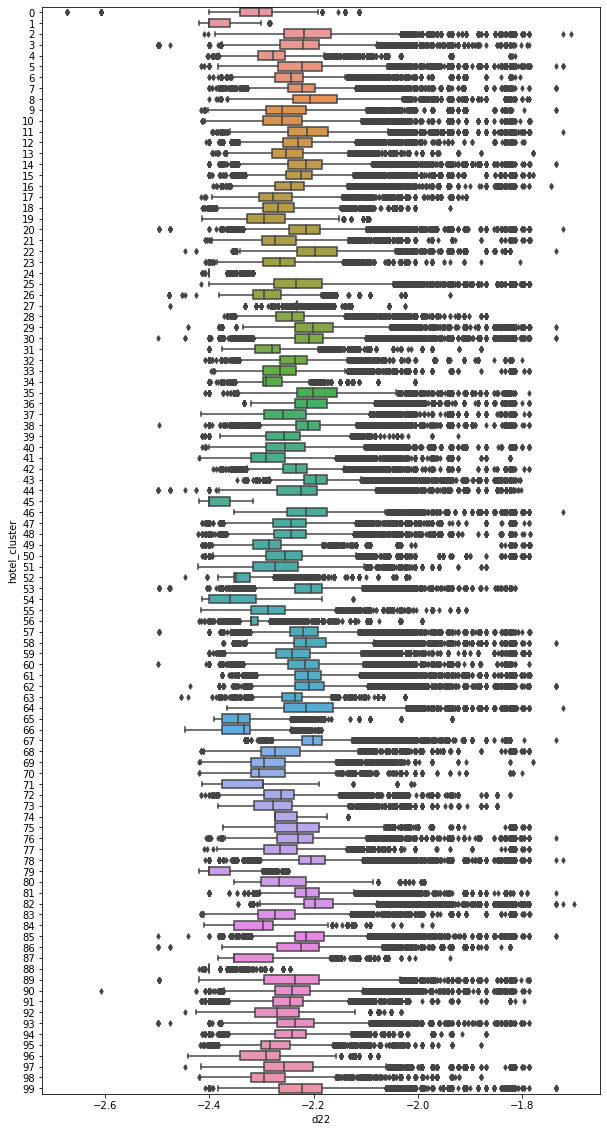

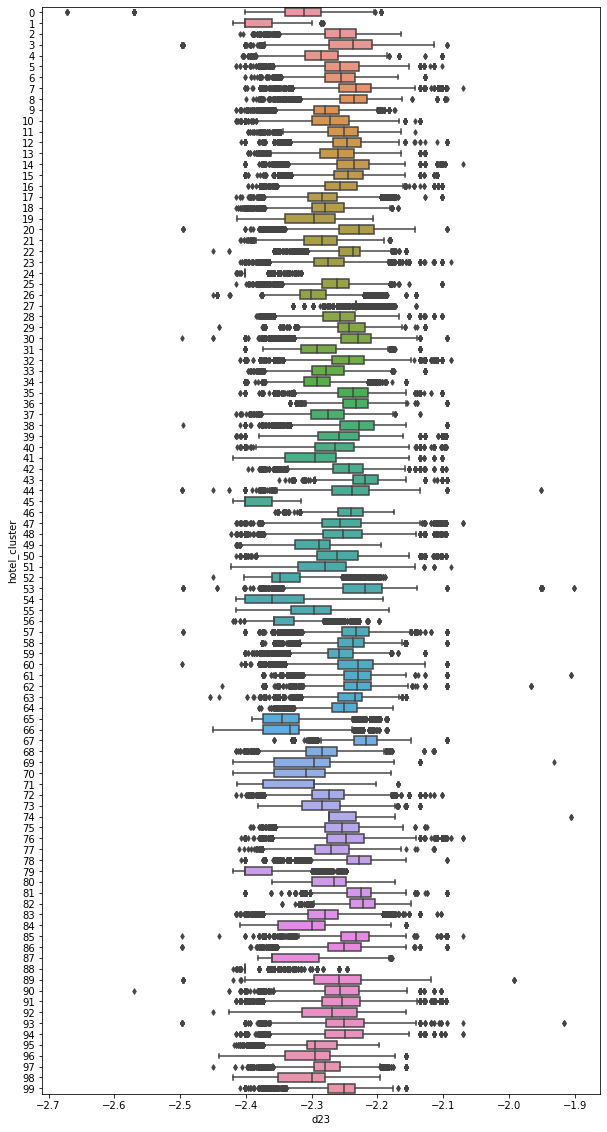

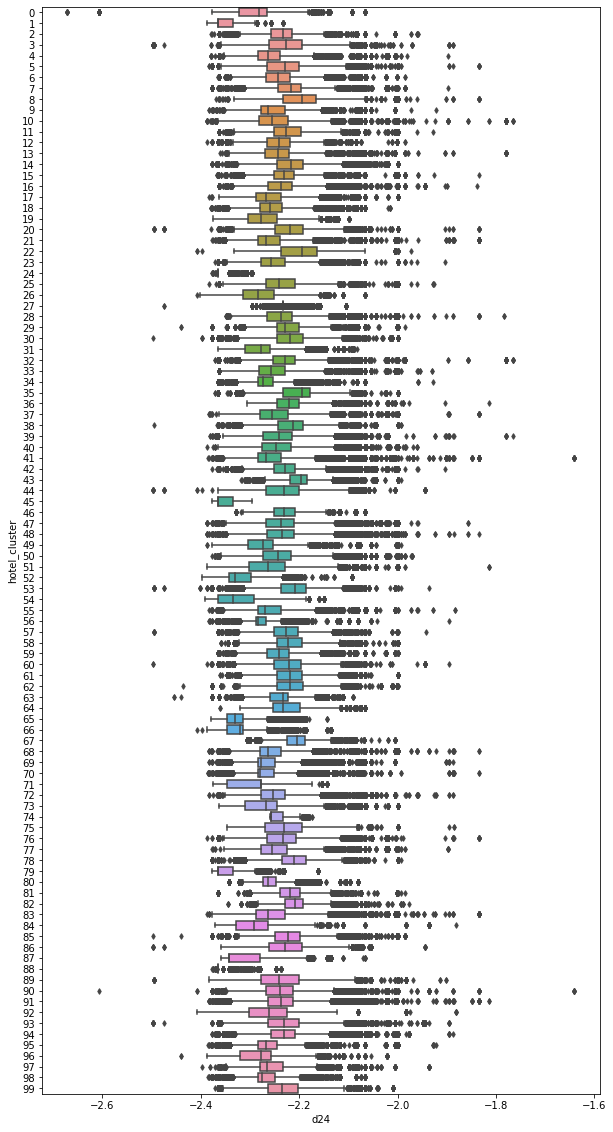

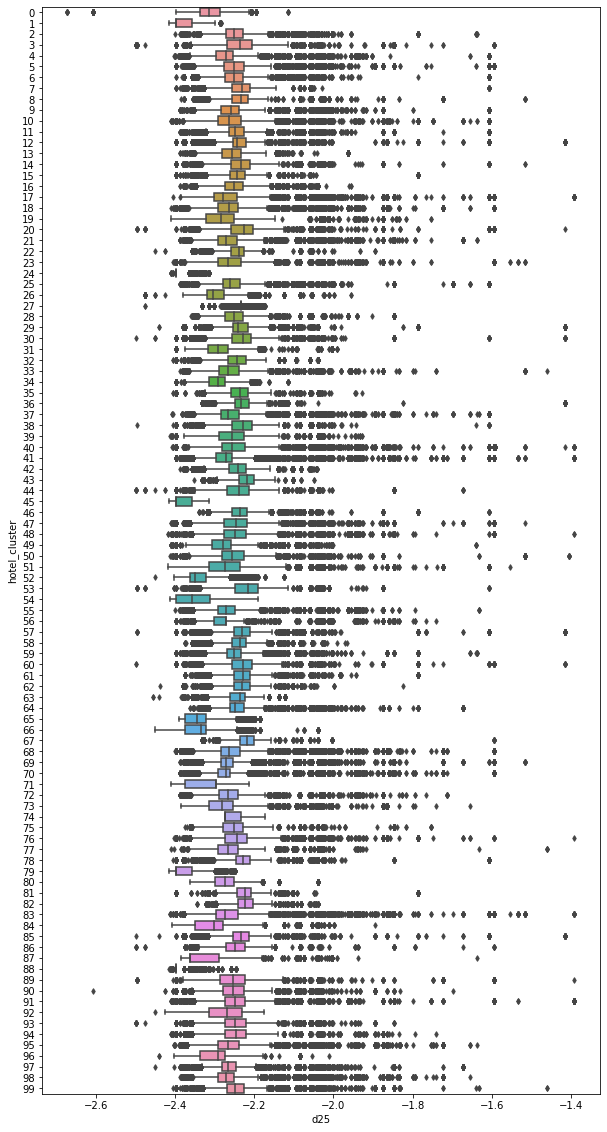

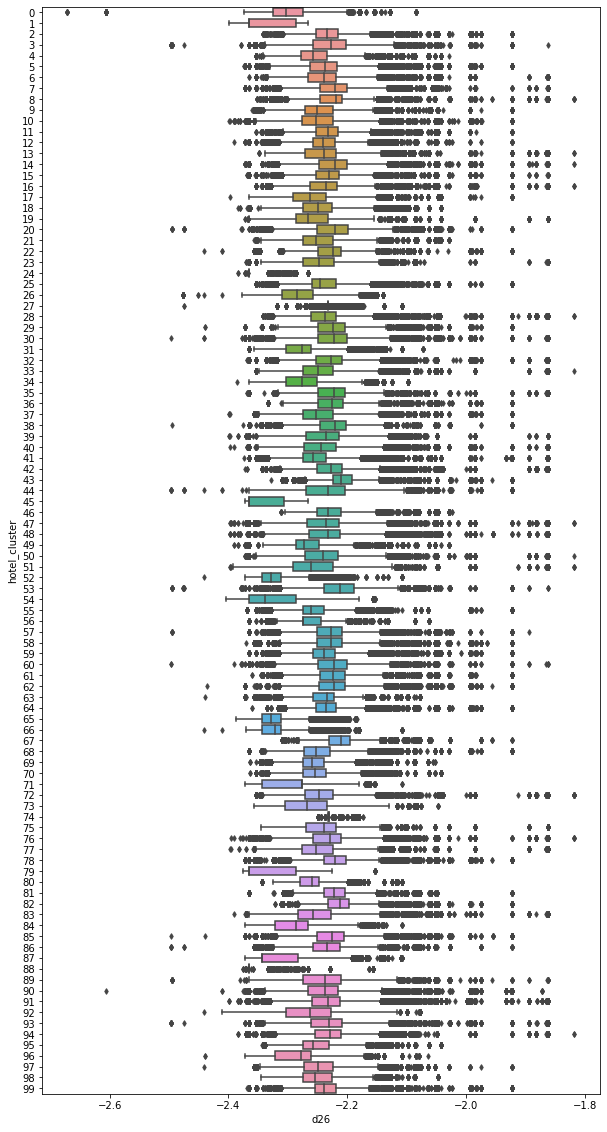

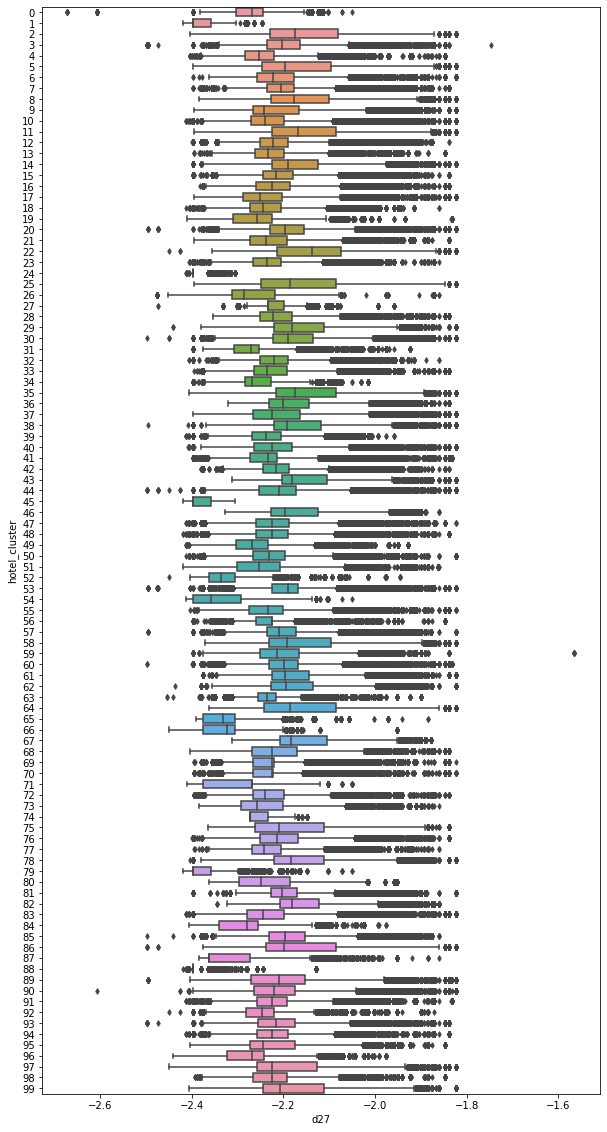

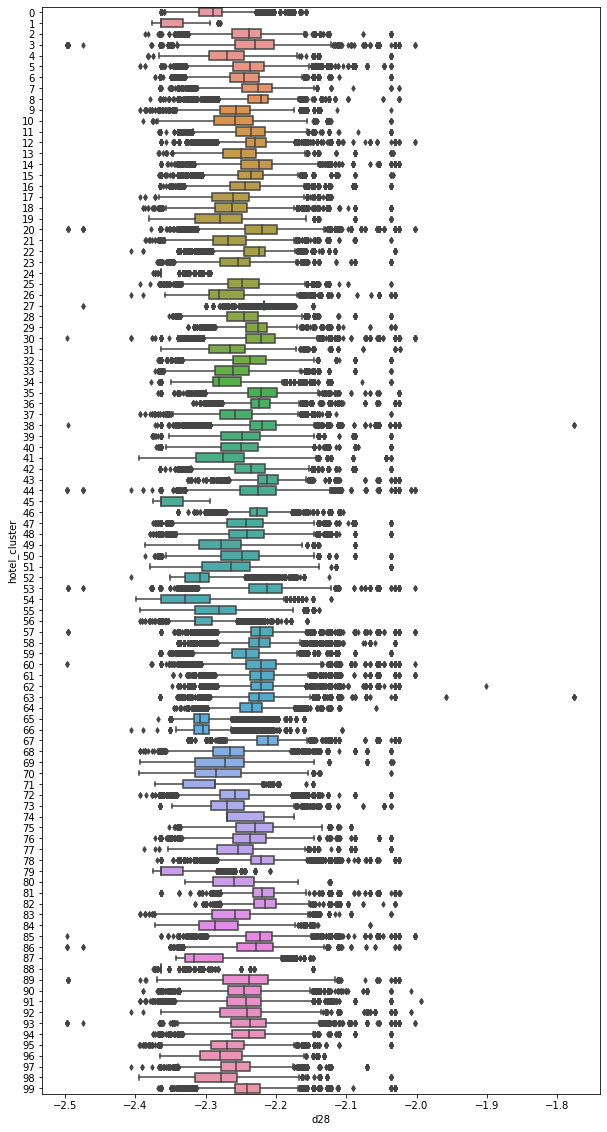

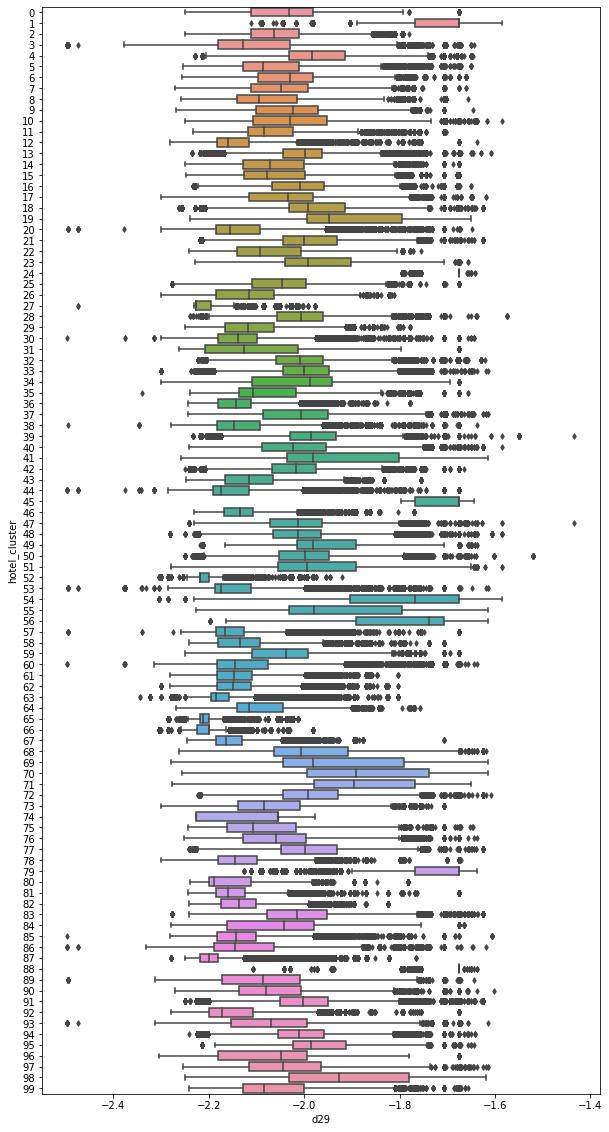

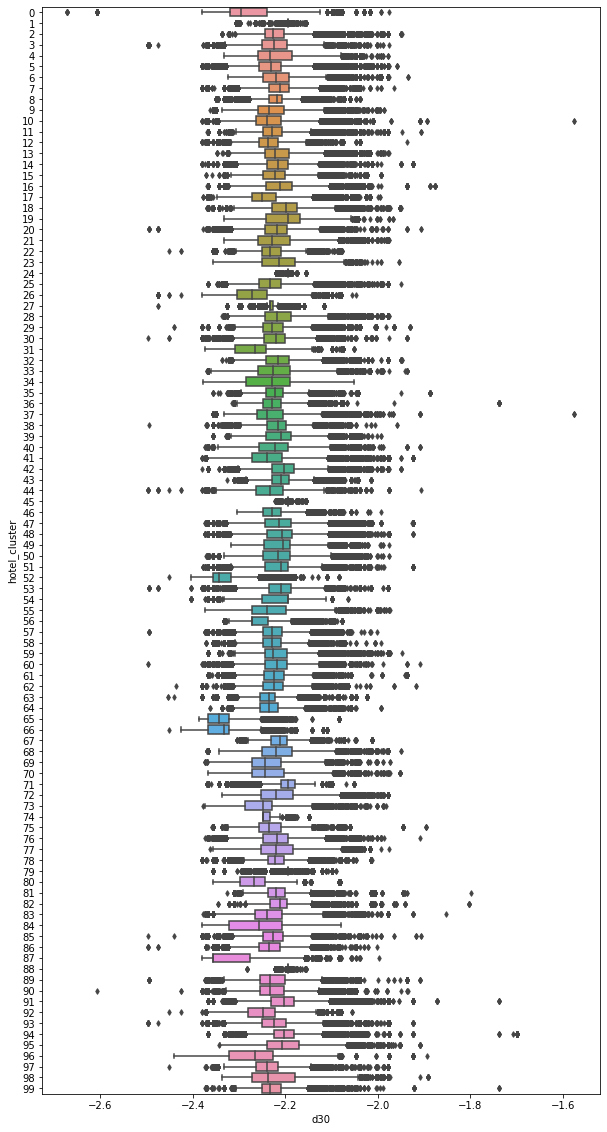

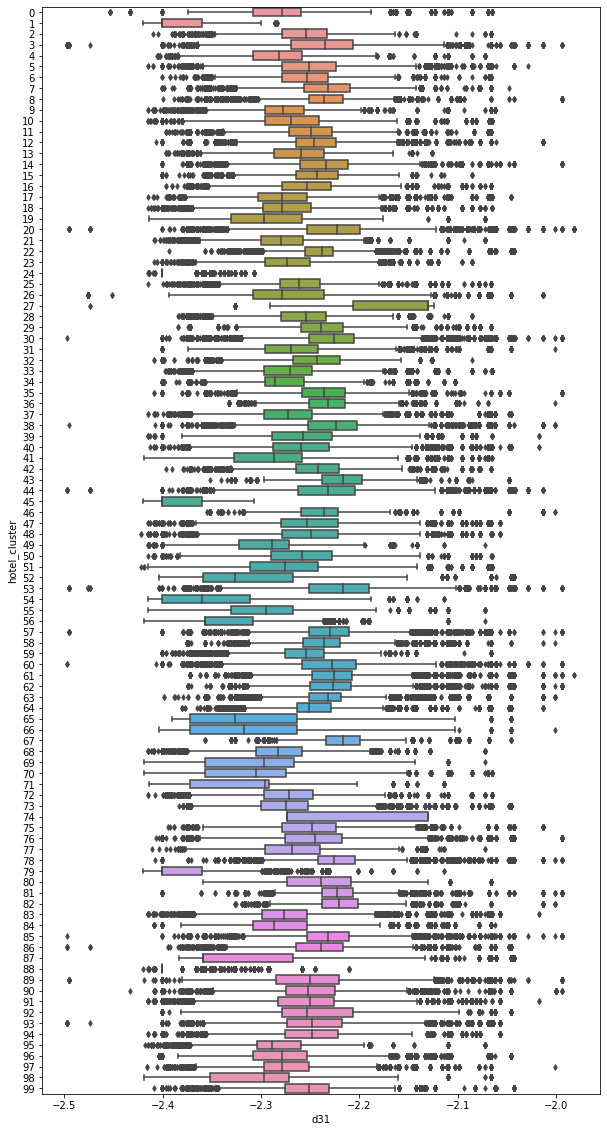

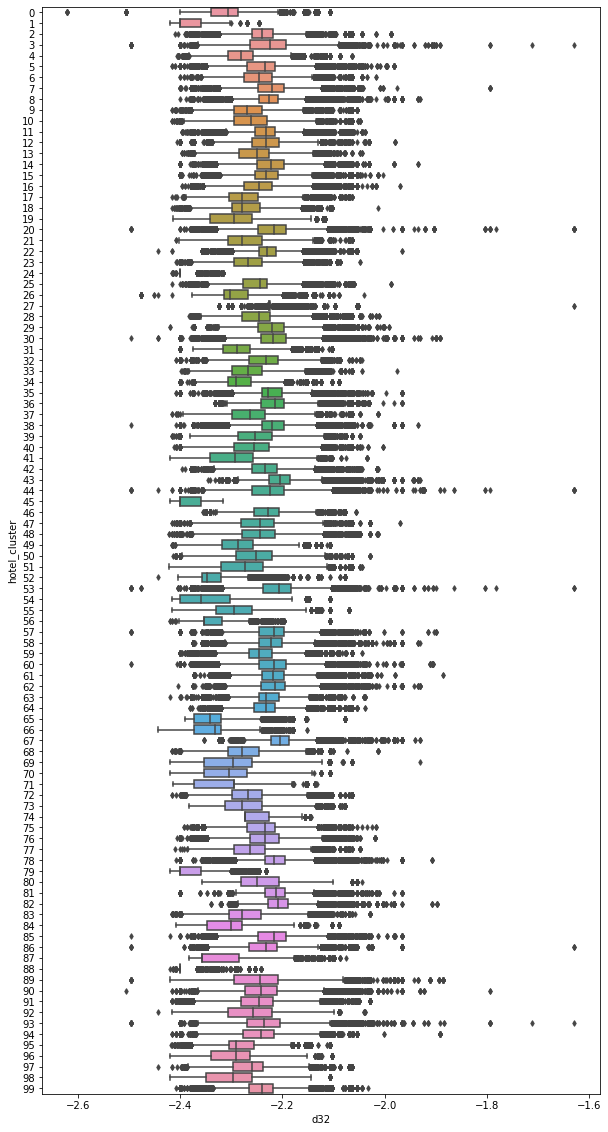

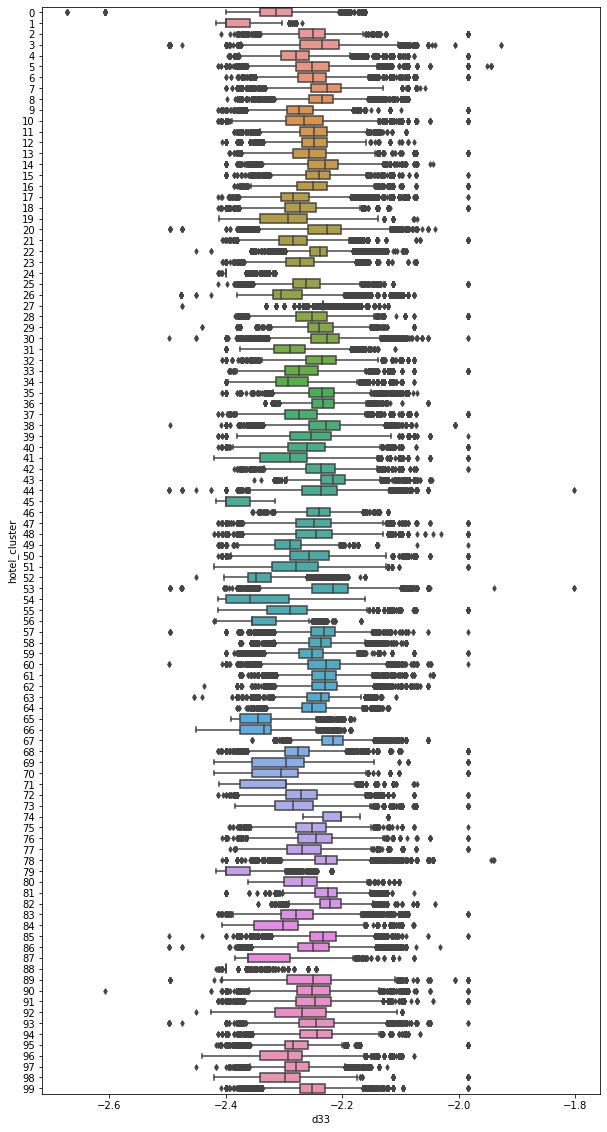

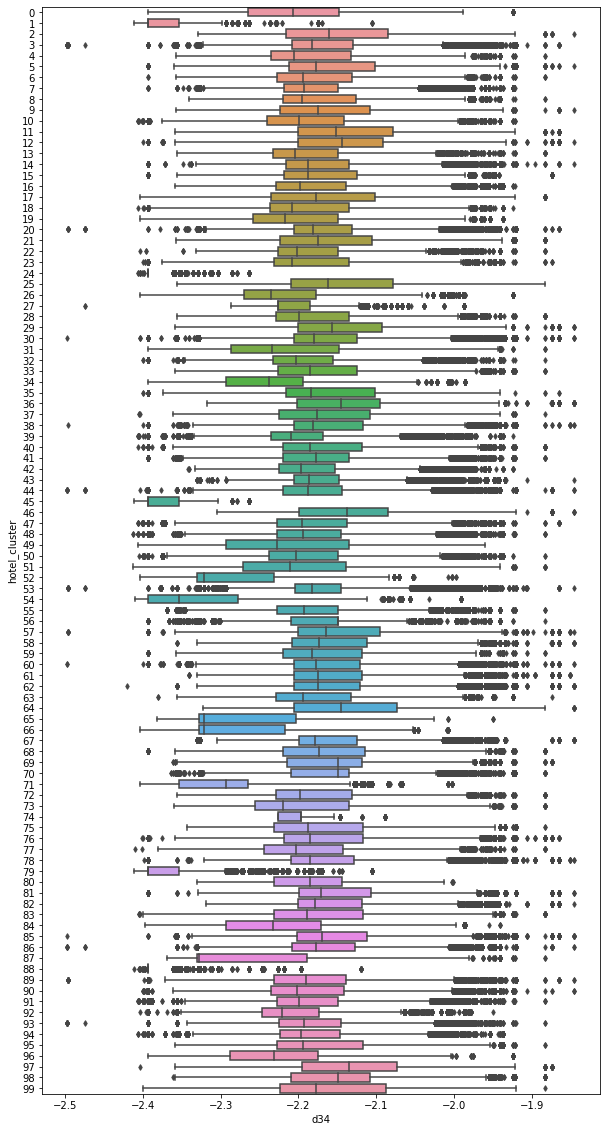

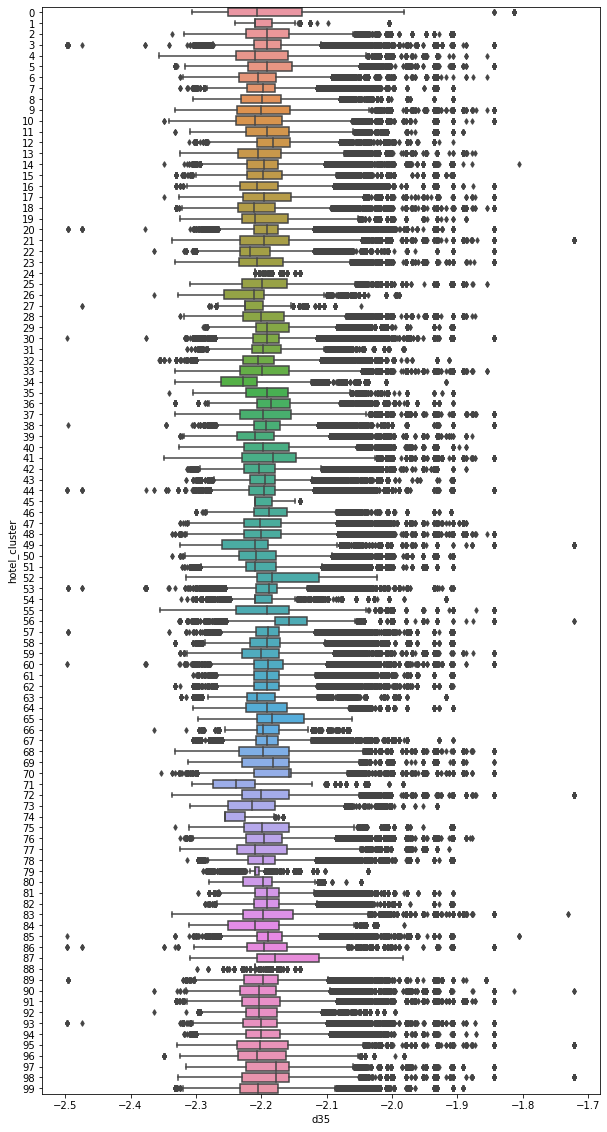

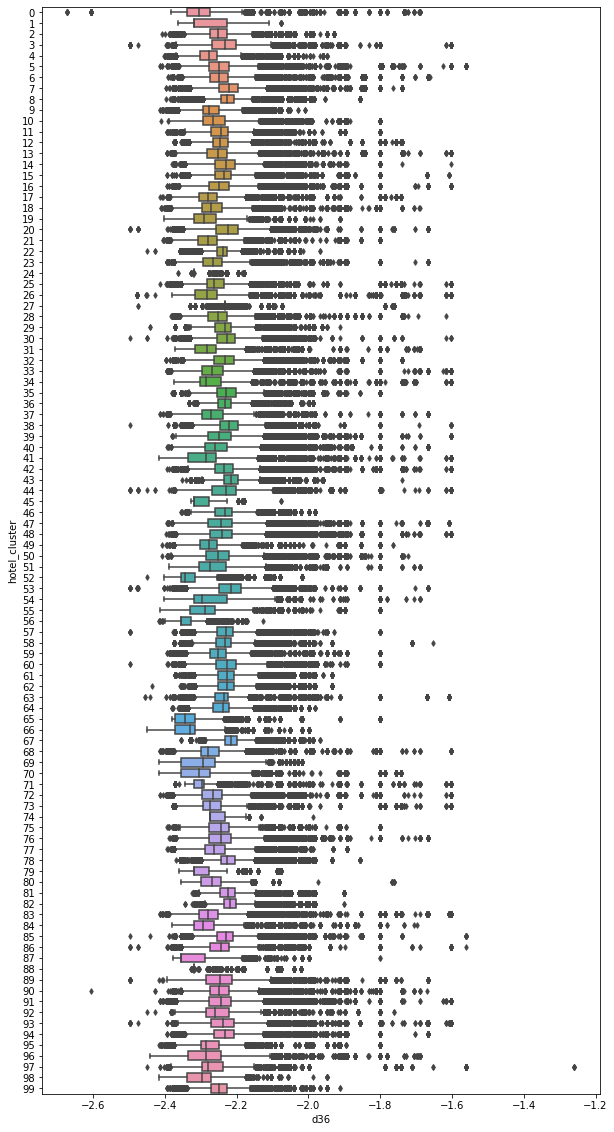

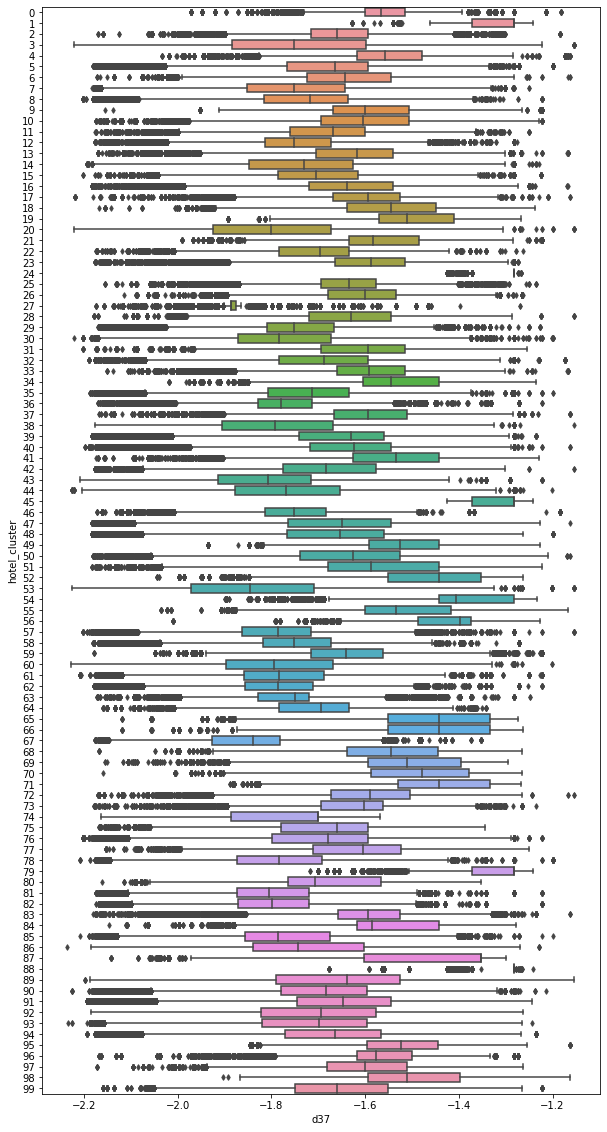

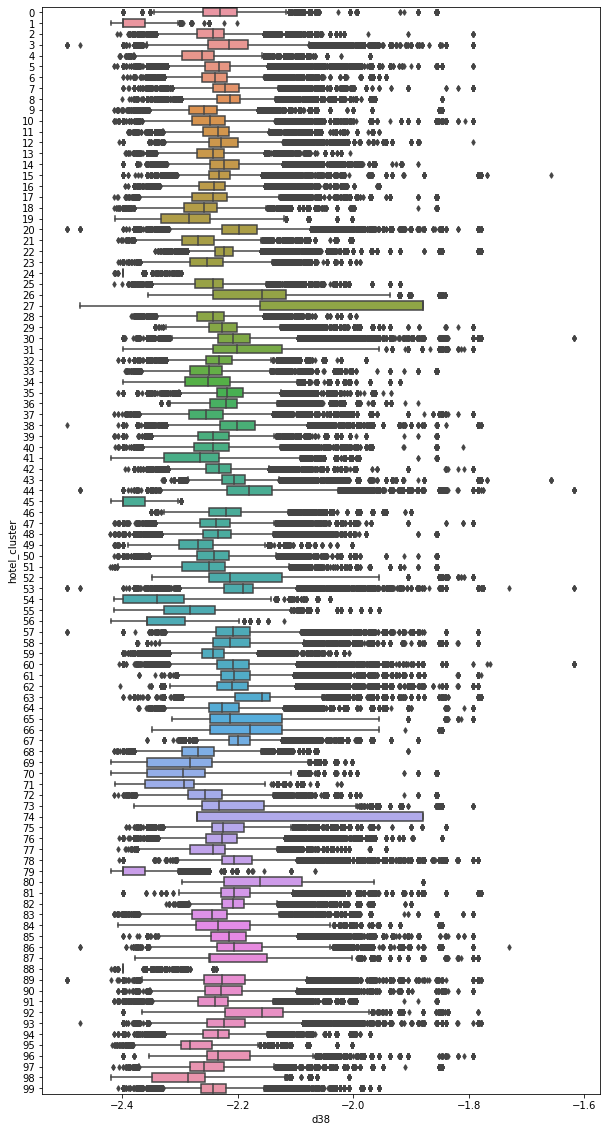

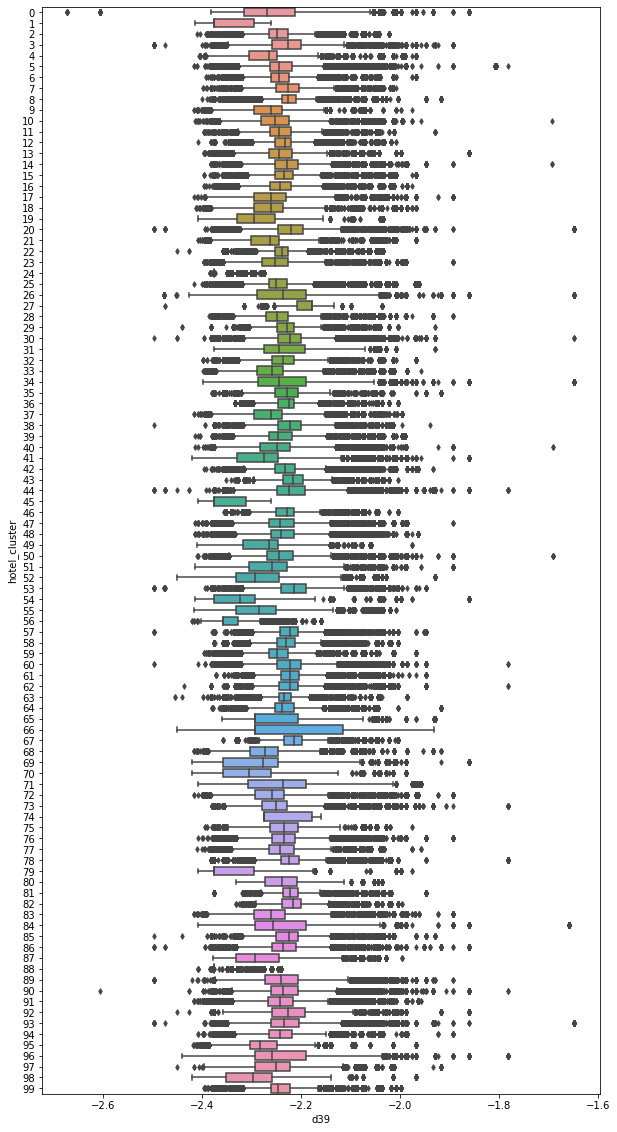

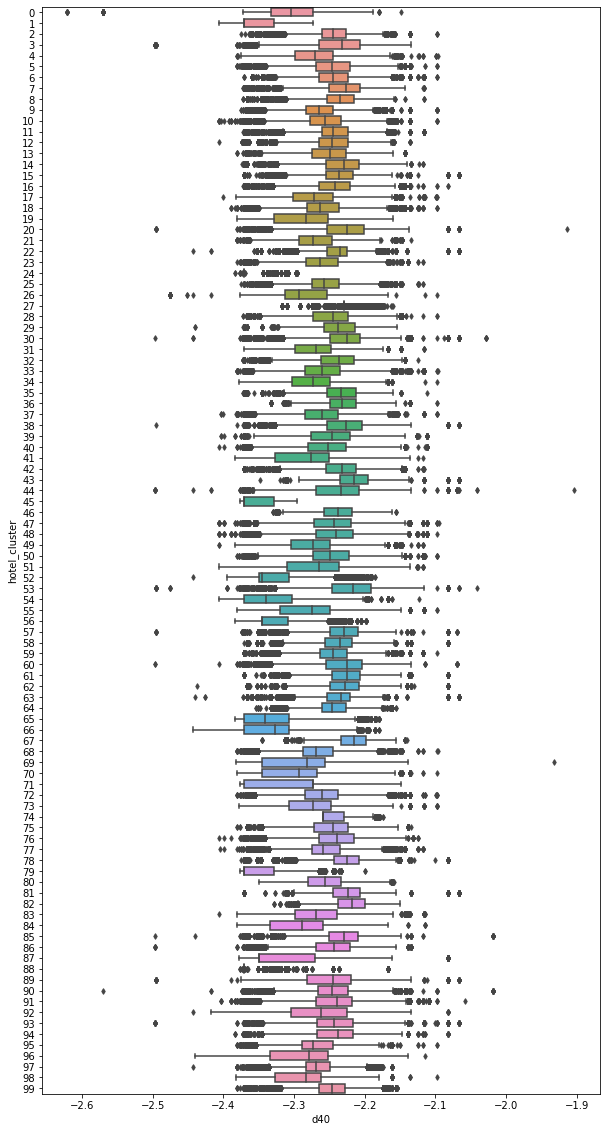

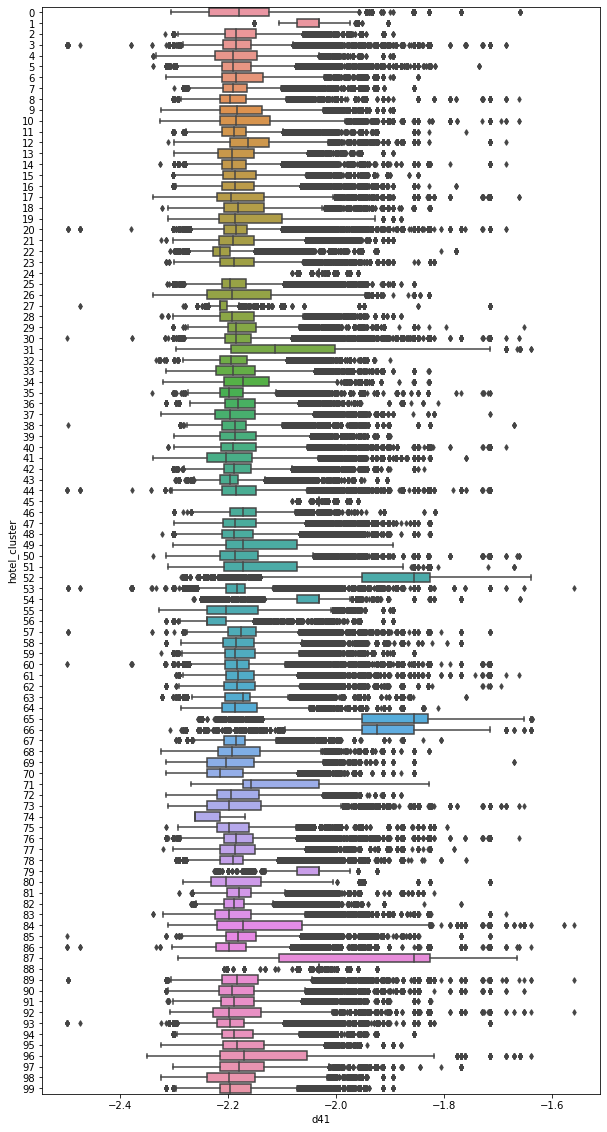

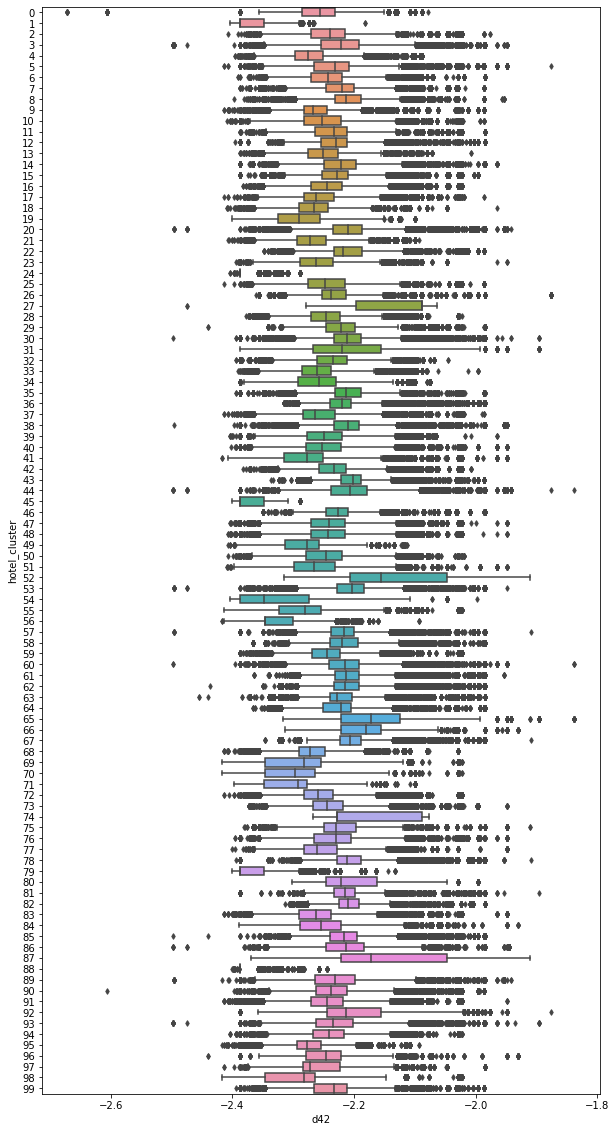

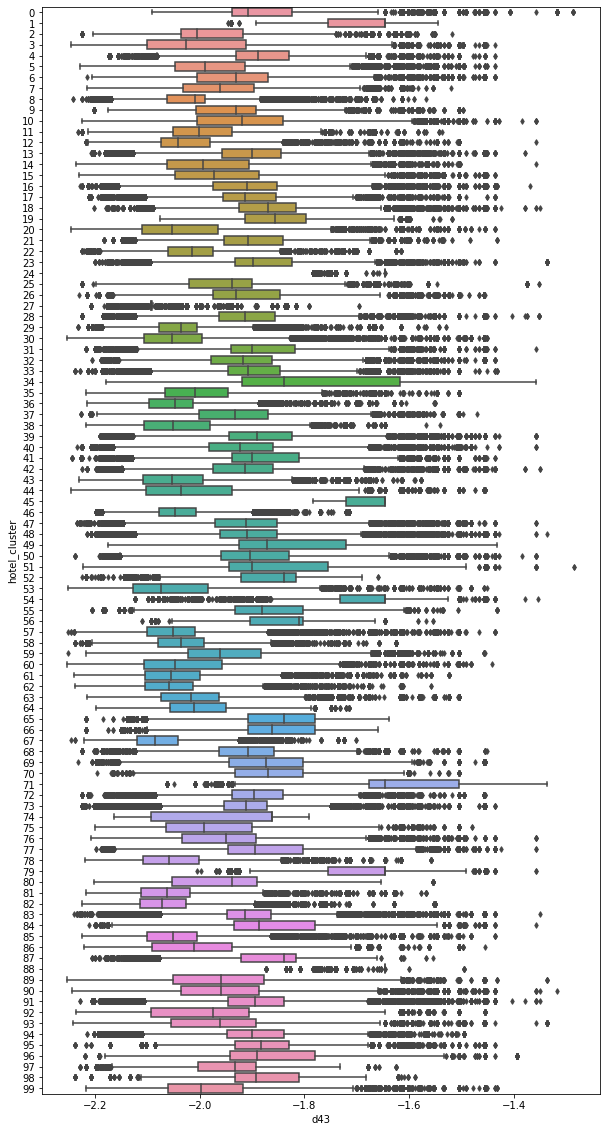

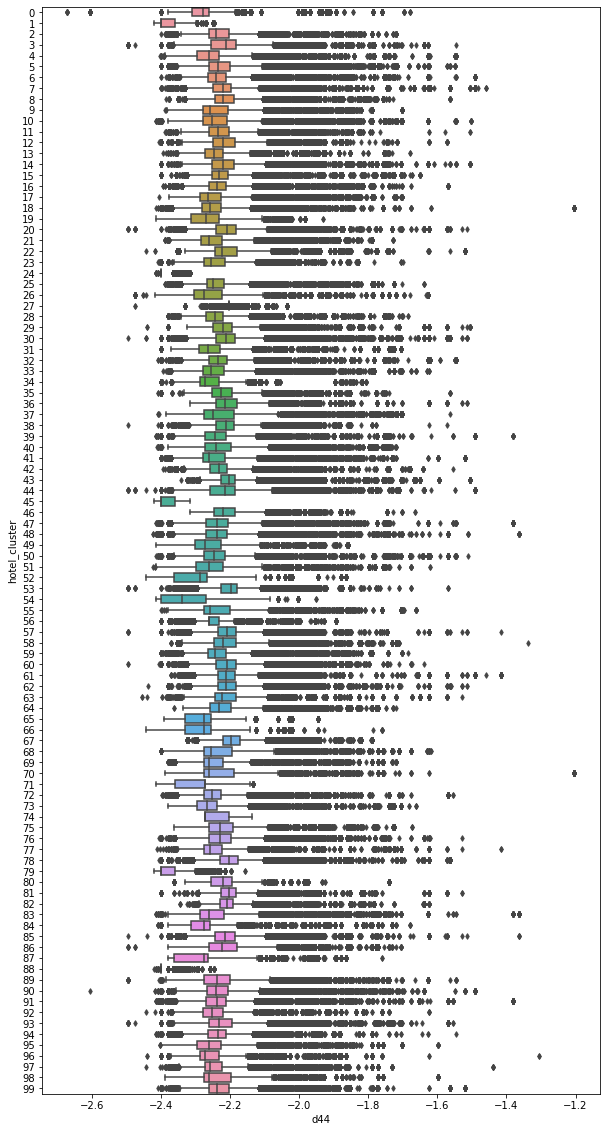

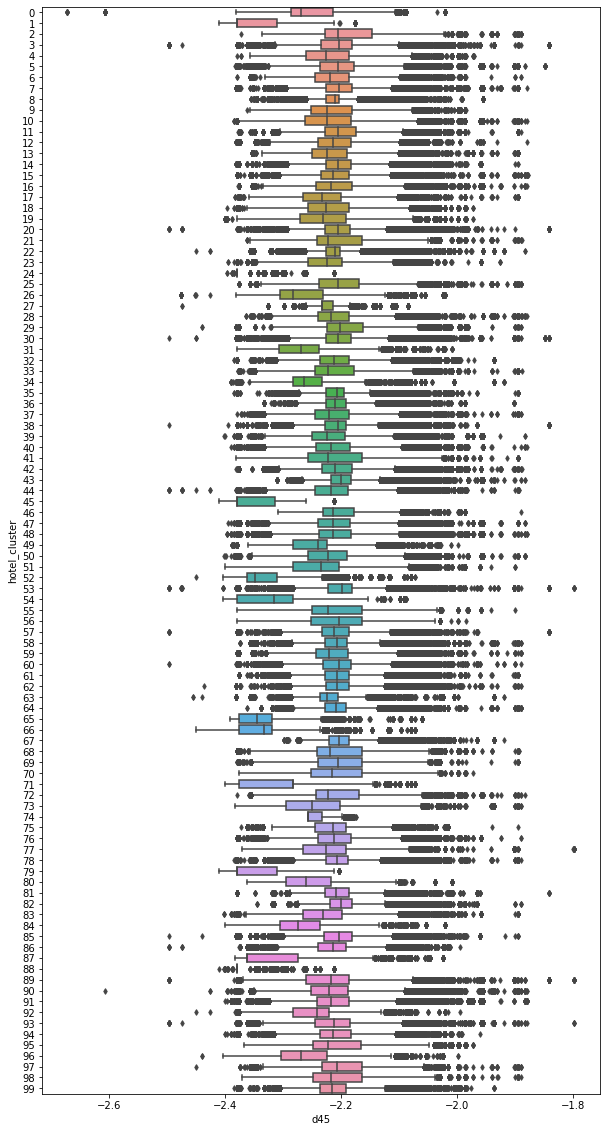

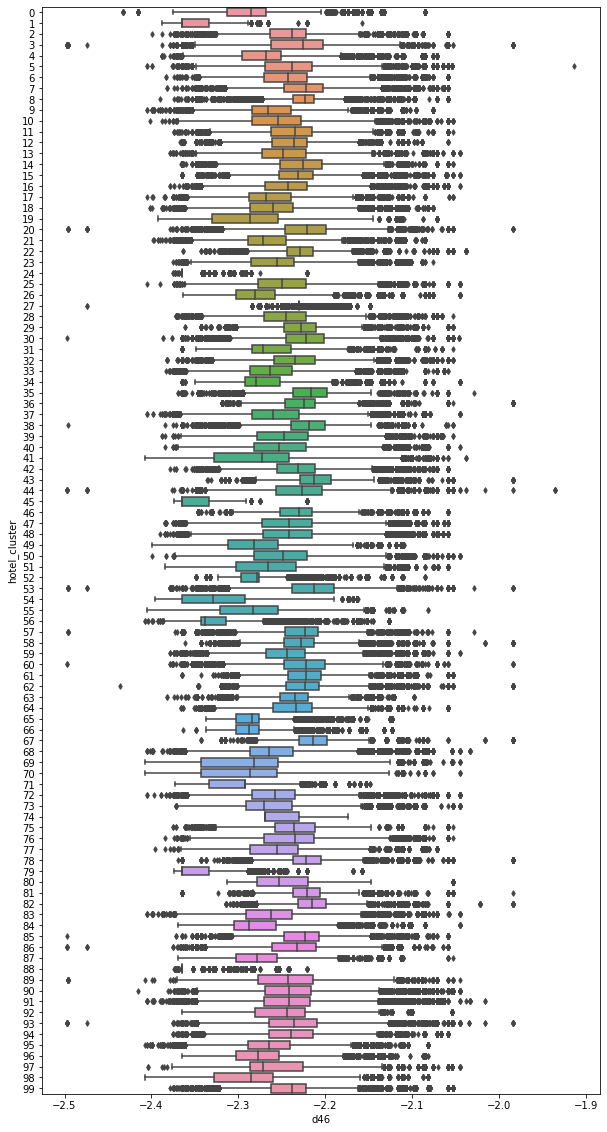

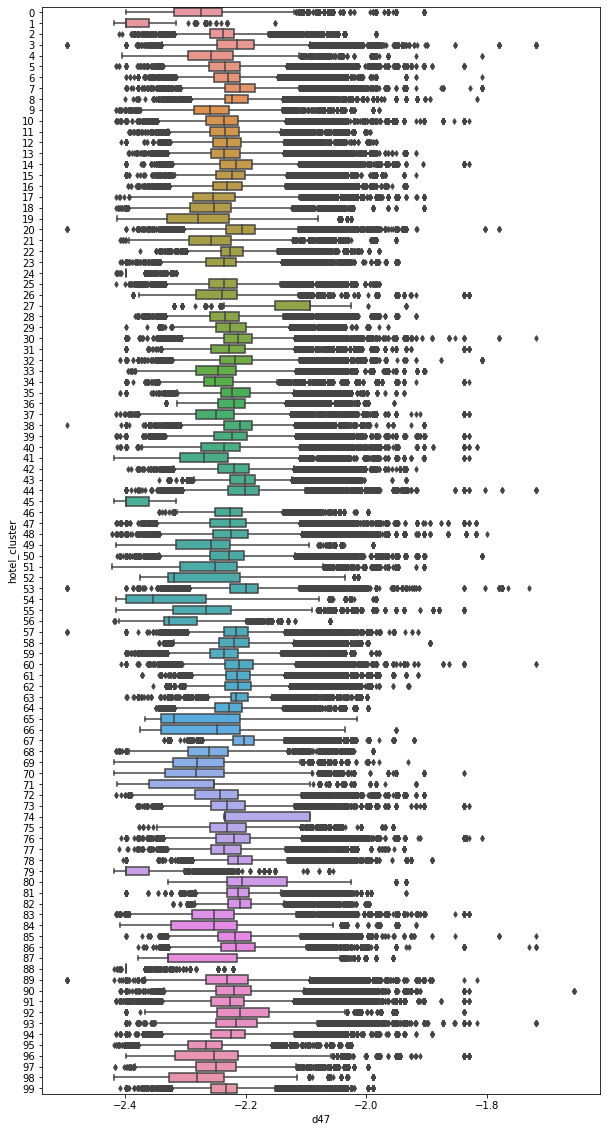

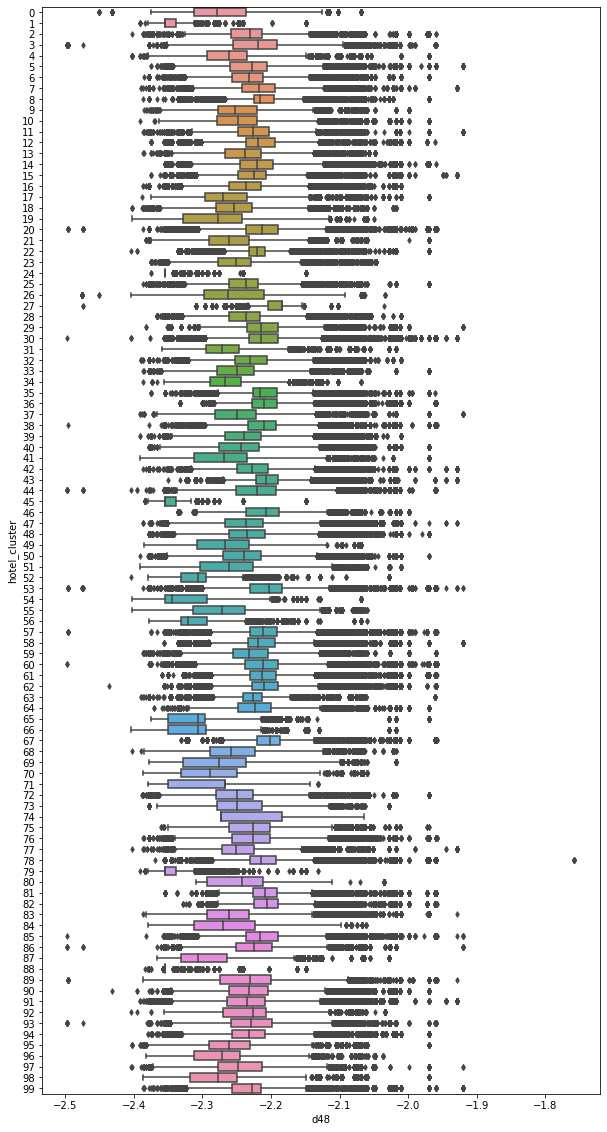

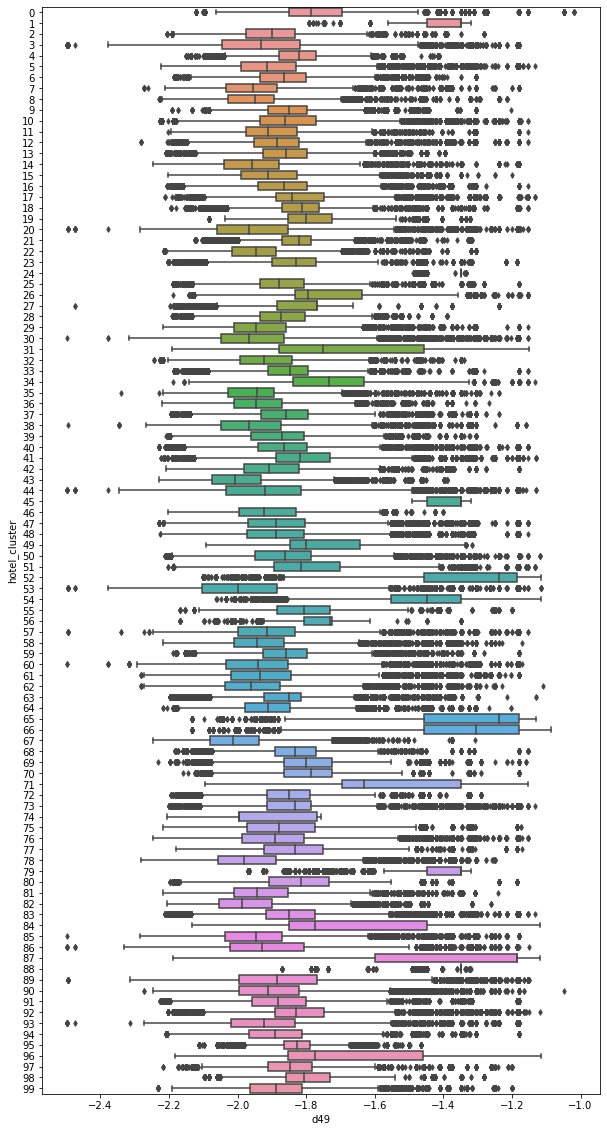

In [68]:
for j in range(1,50):
    train_d = train.join(destinations[f'd{j}'], on='srch_destination_id', lsuffix='_caller', rsuffix='_other')

    fig, ax = plt.subplots(figsize=(10,20))
    sns.boxplot(y=train_d['hotel_cluster'], x=train_d[f'd{j}'], orient="h", fliersize=4)
    plt.savefig(f'./imgs/destination feature/d{j}.png')

Here notice that some search destination id is not in destinations.csv

### other categorical variables on hotel cluster prediction and booking decision

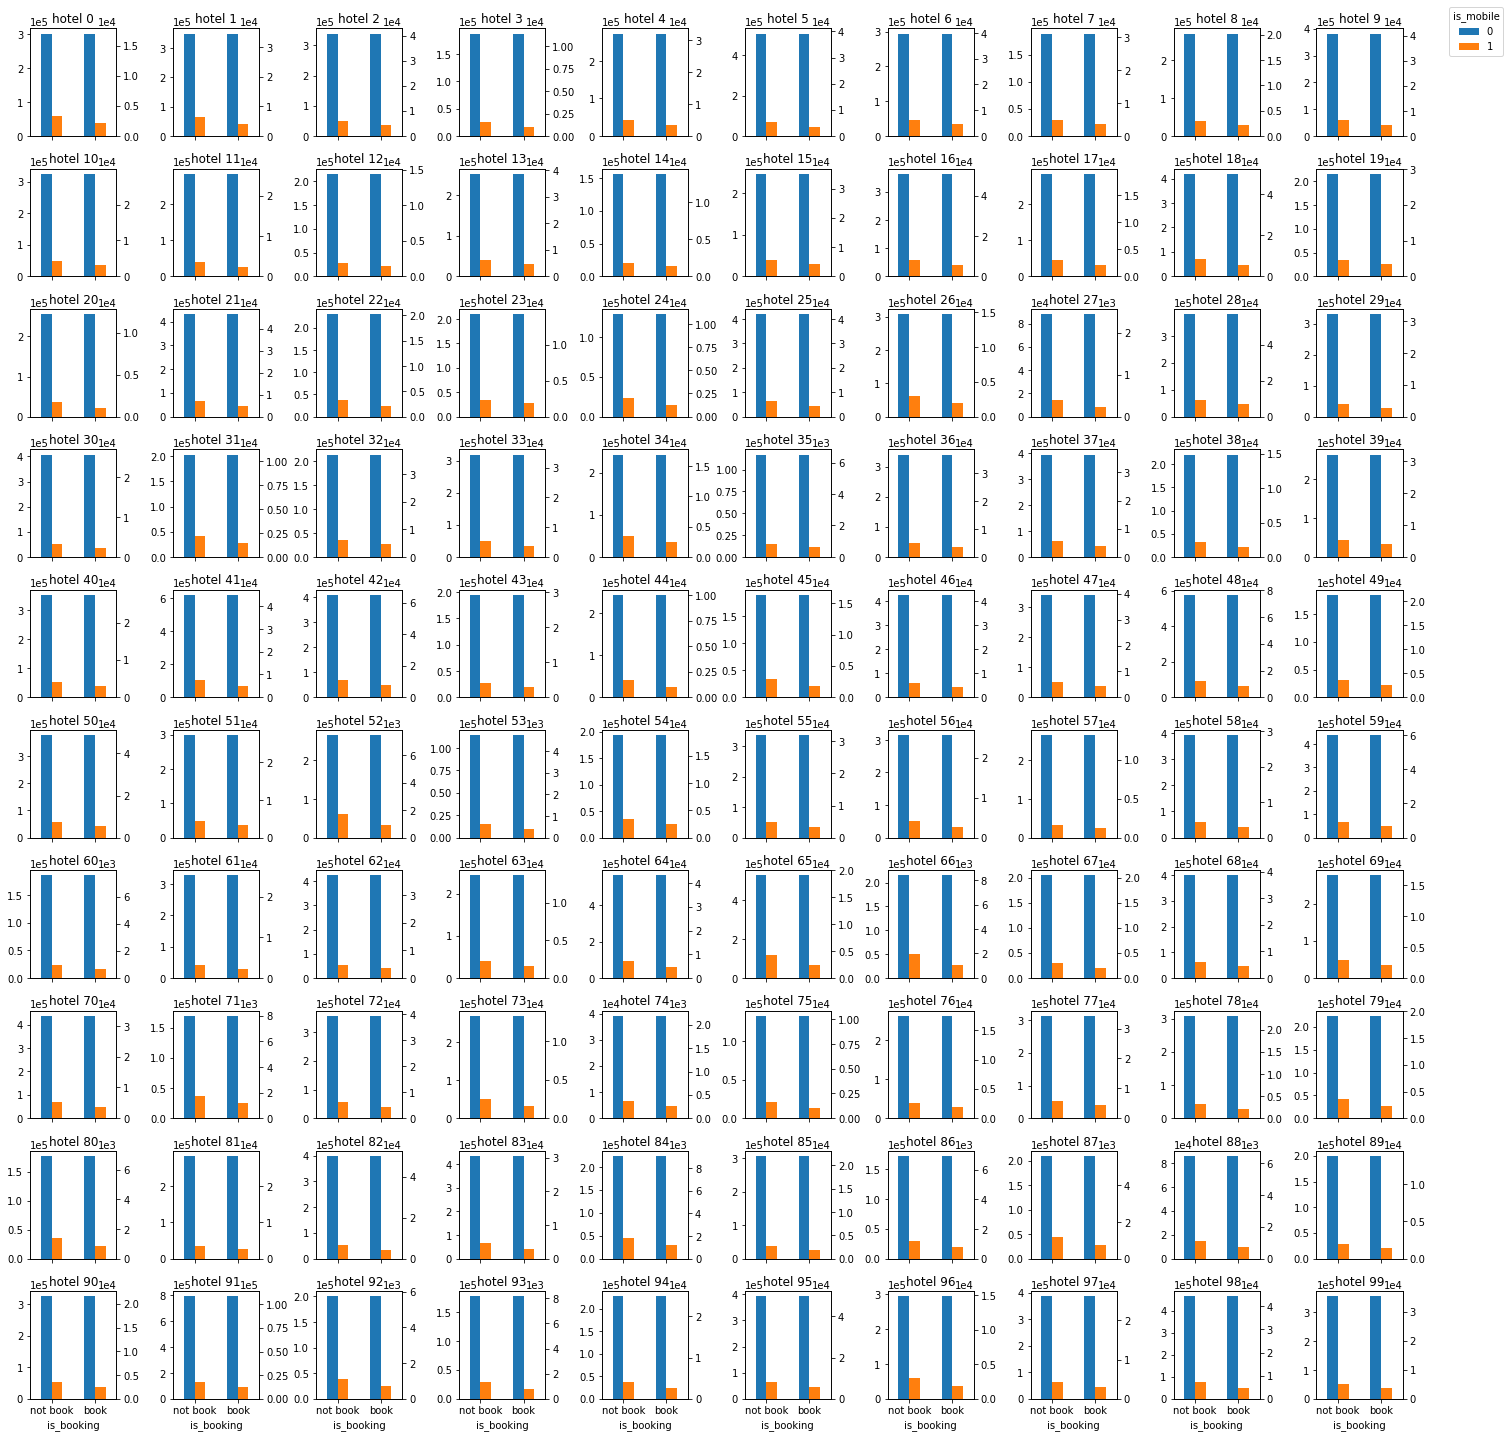

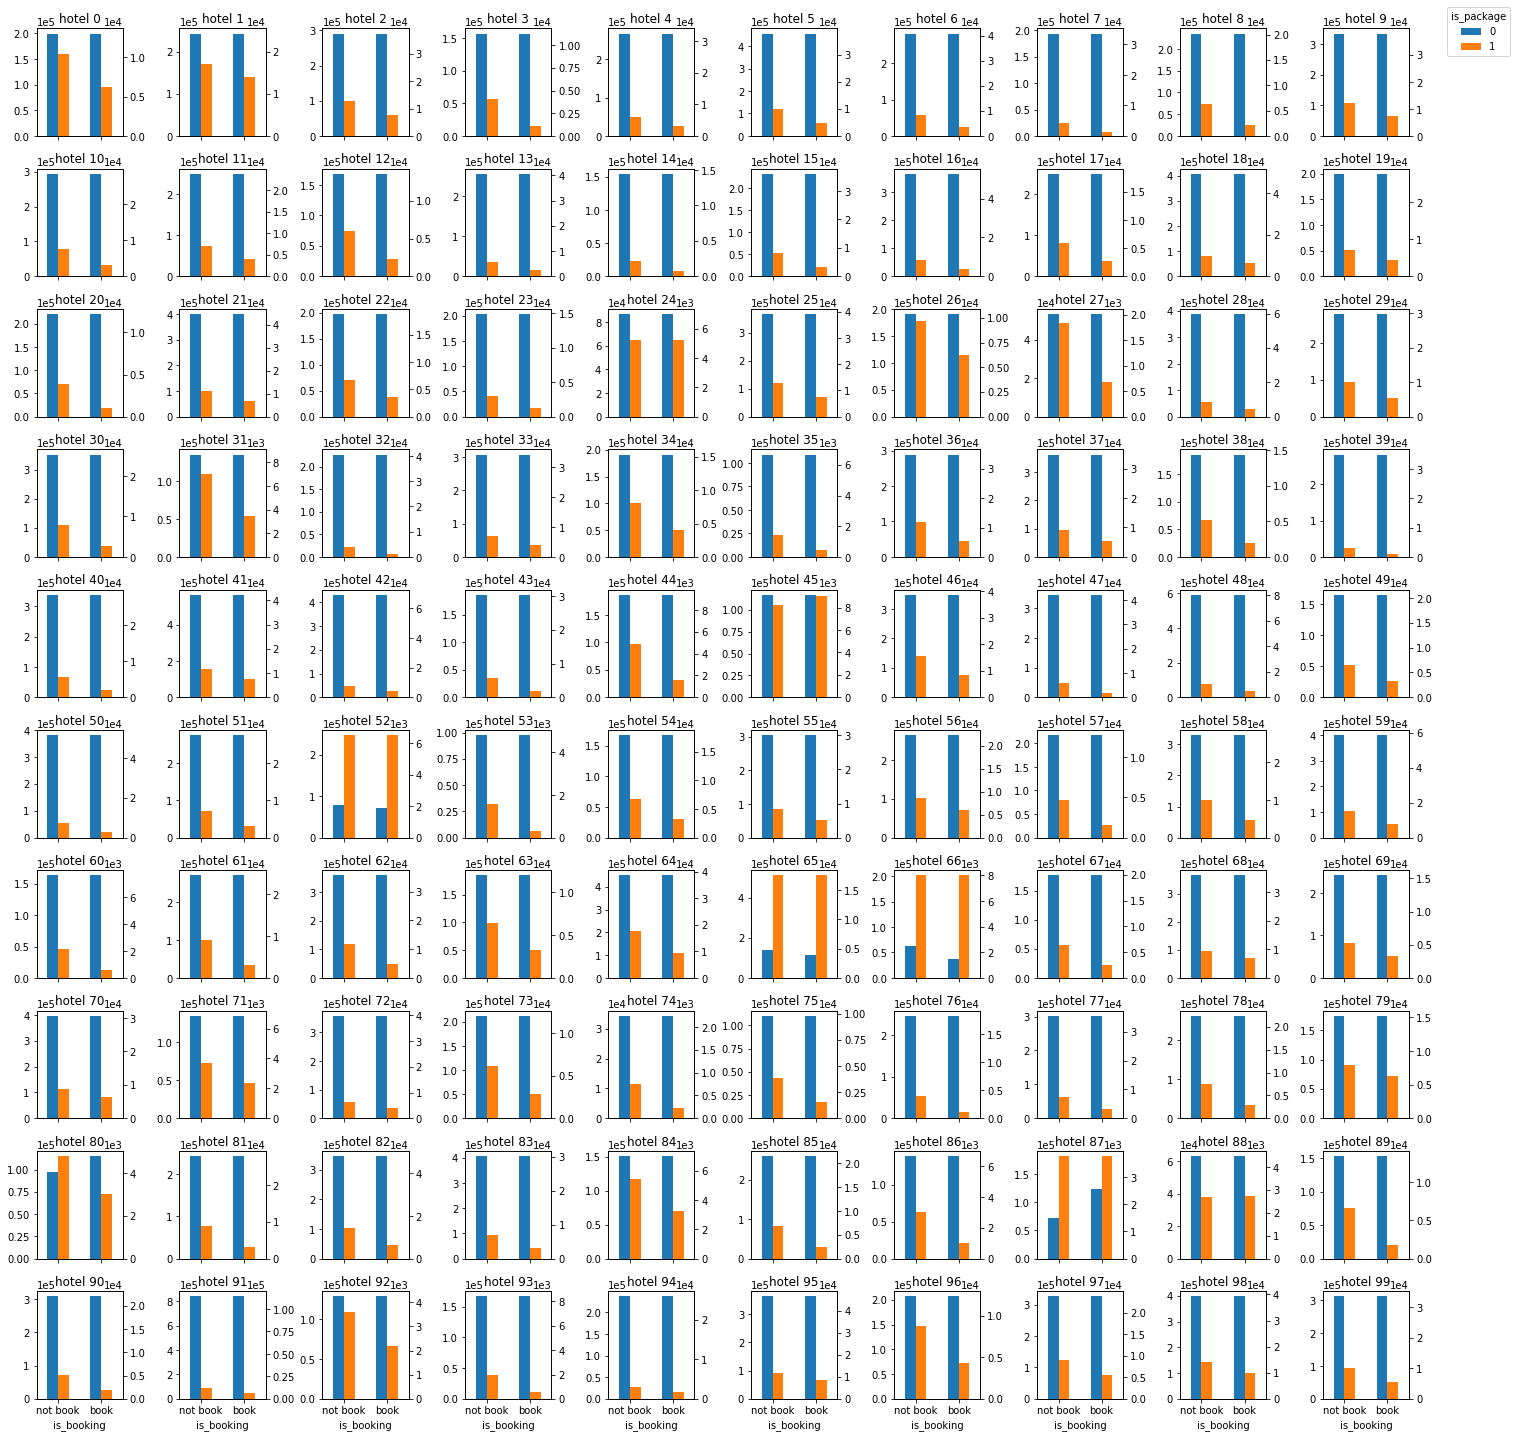

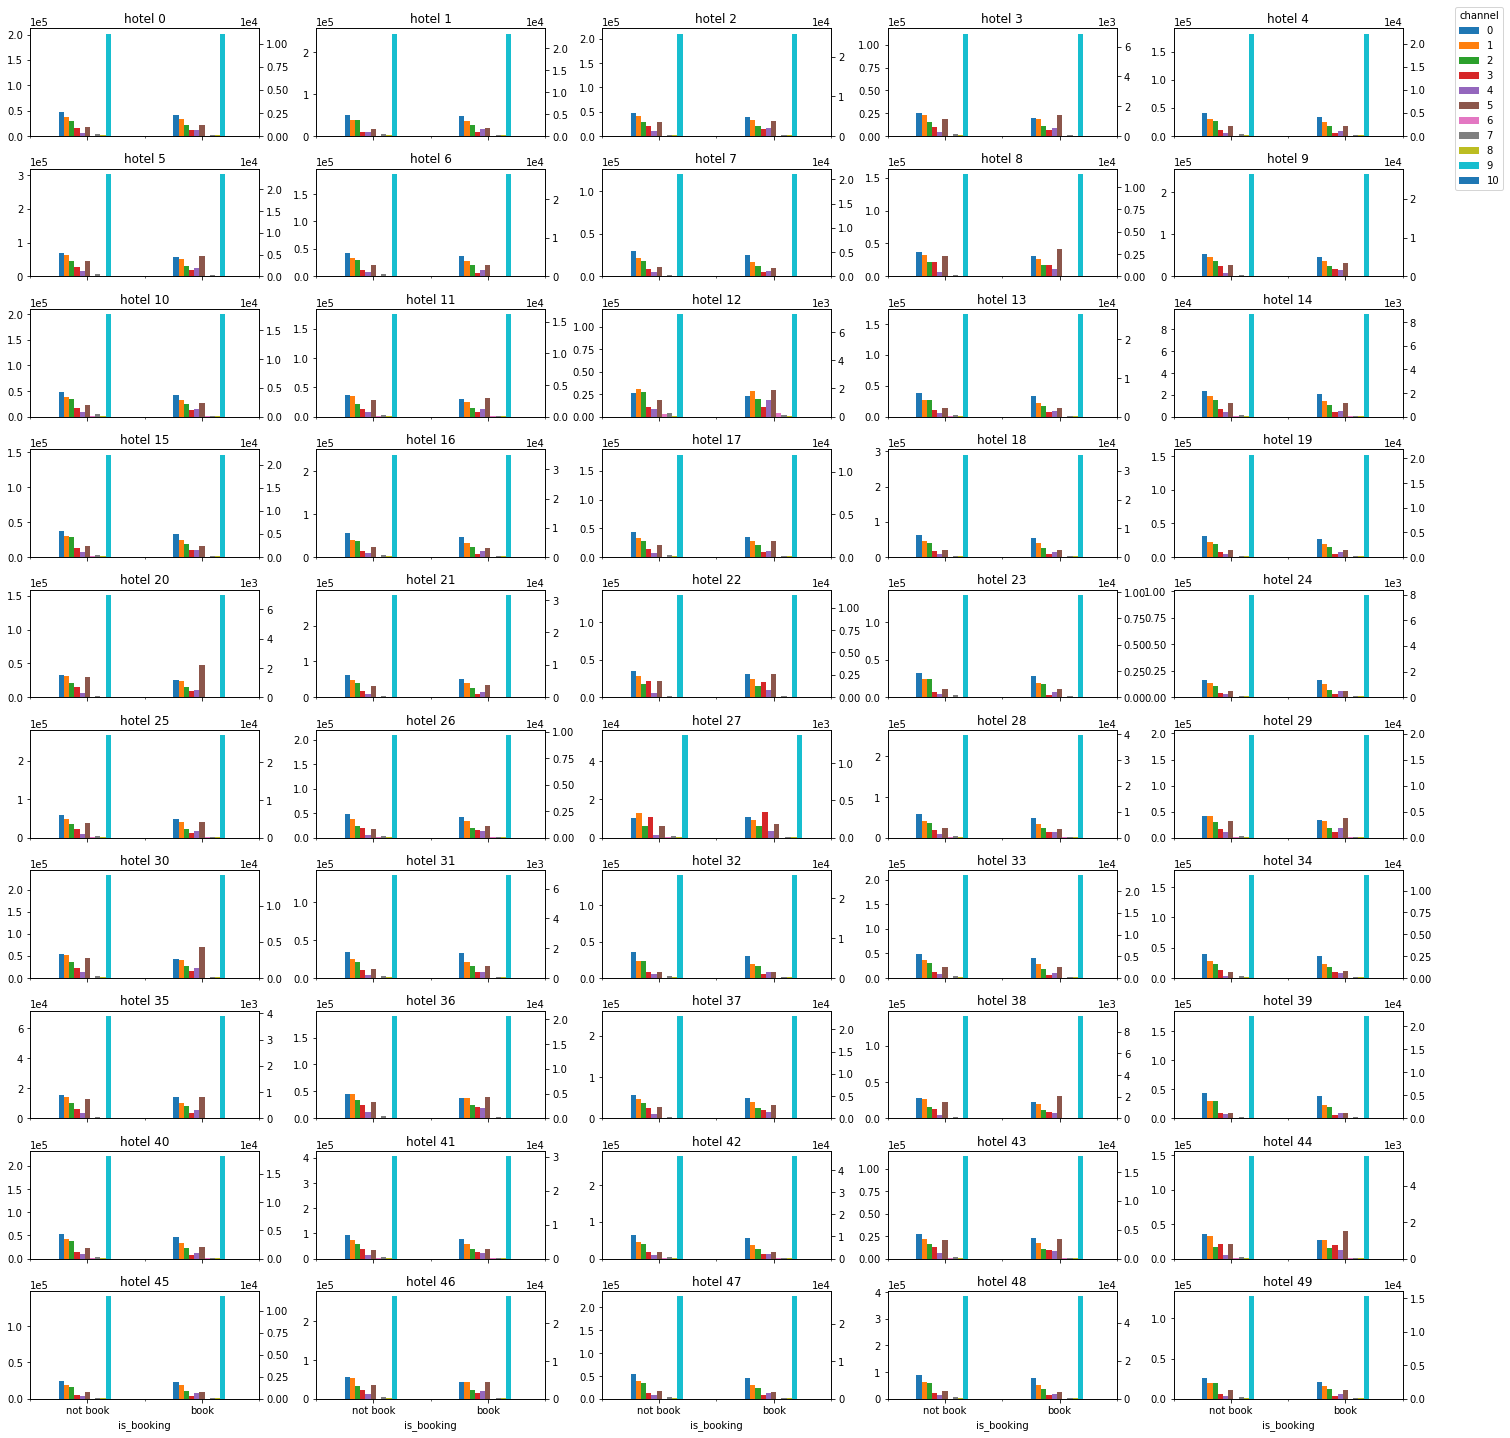

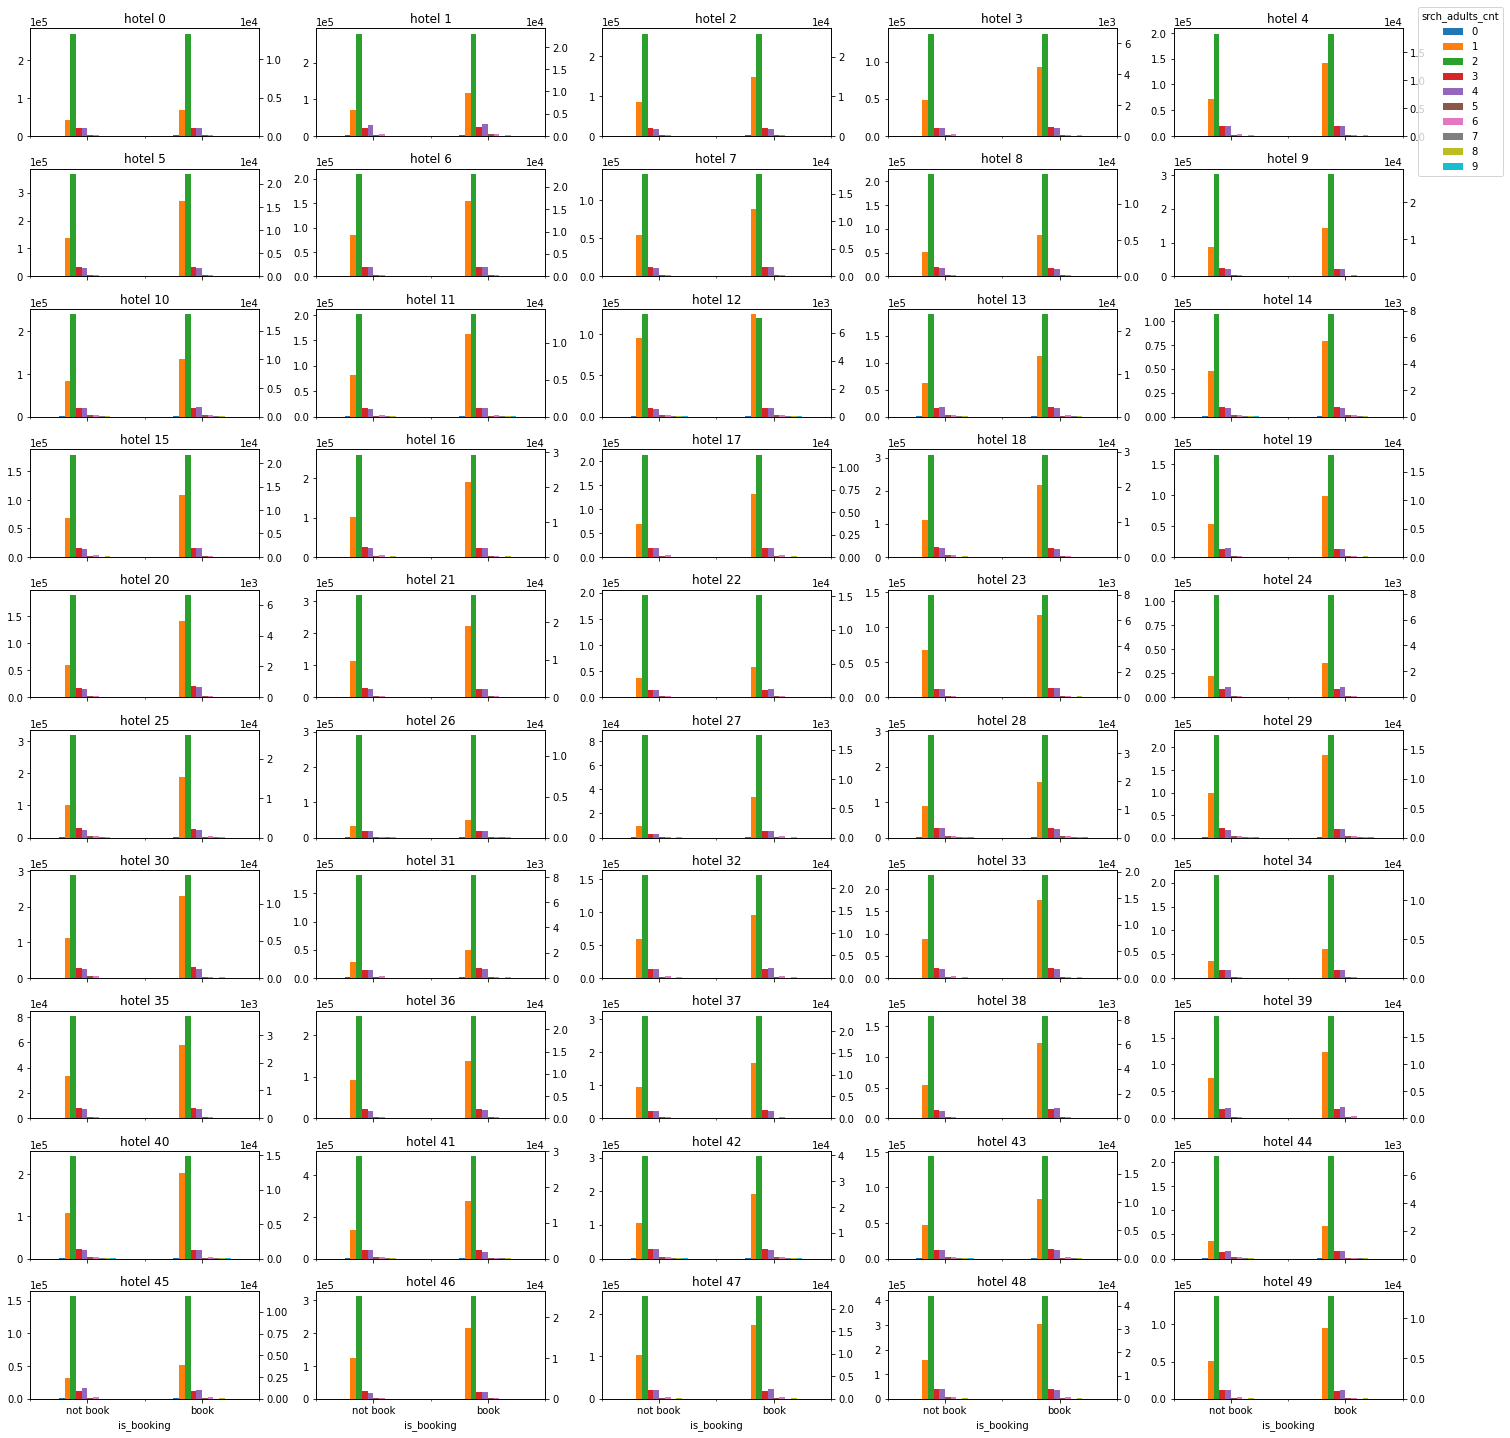

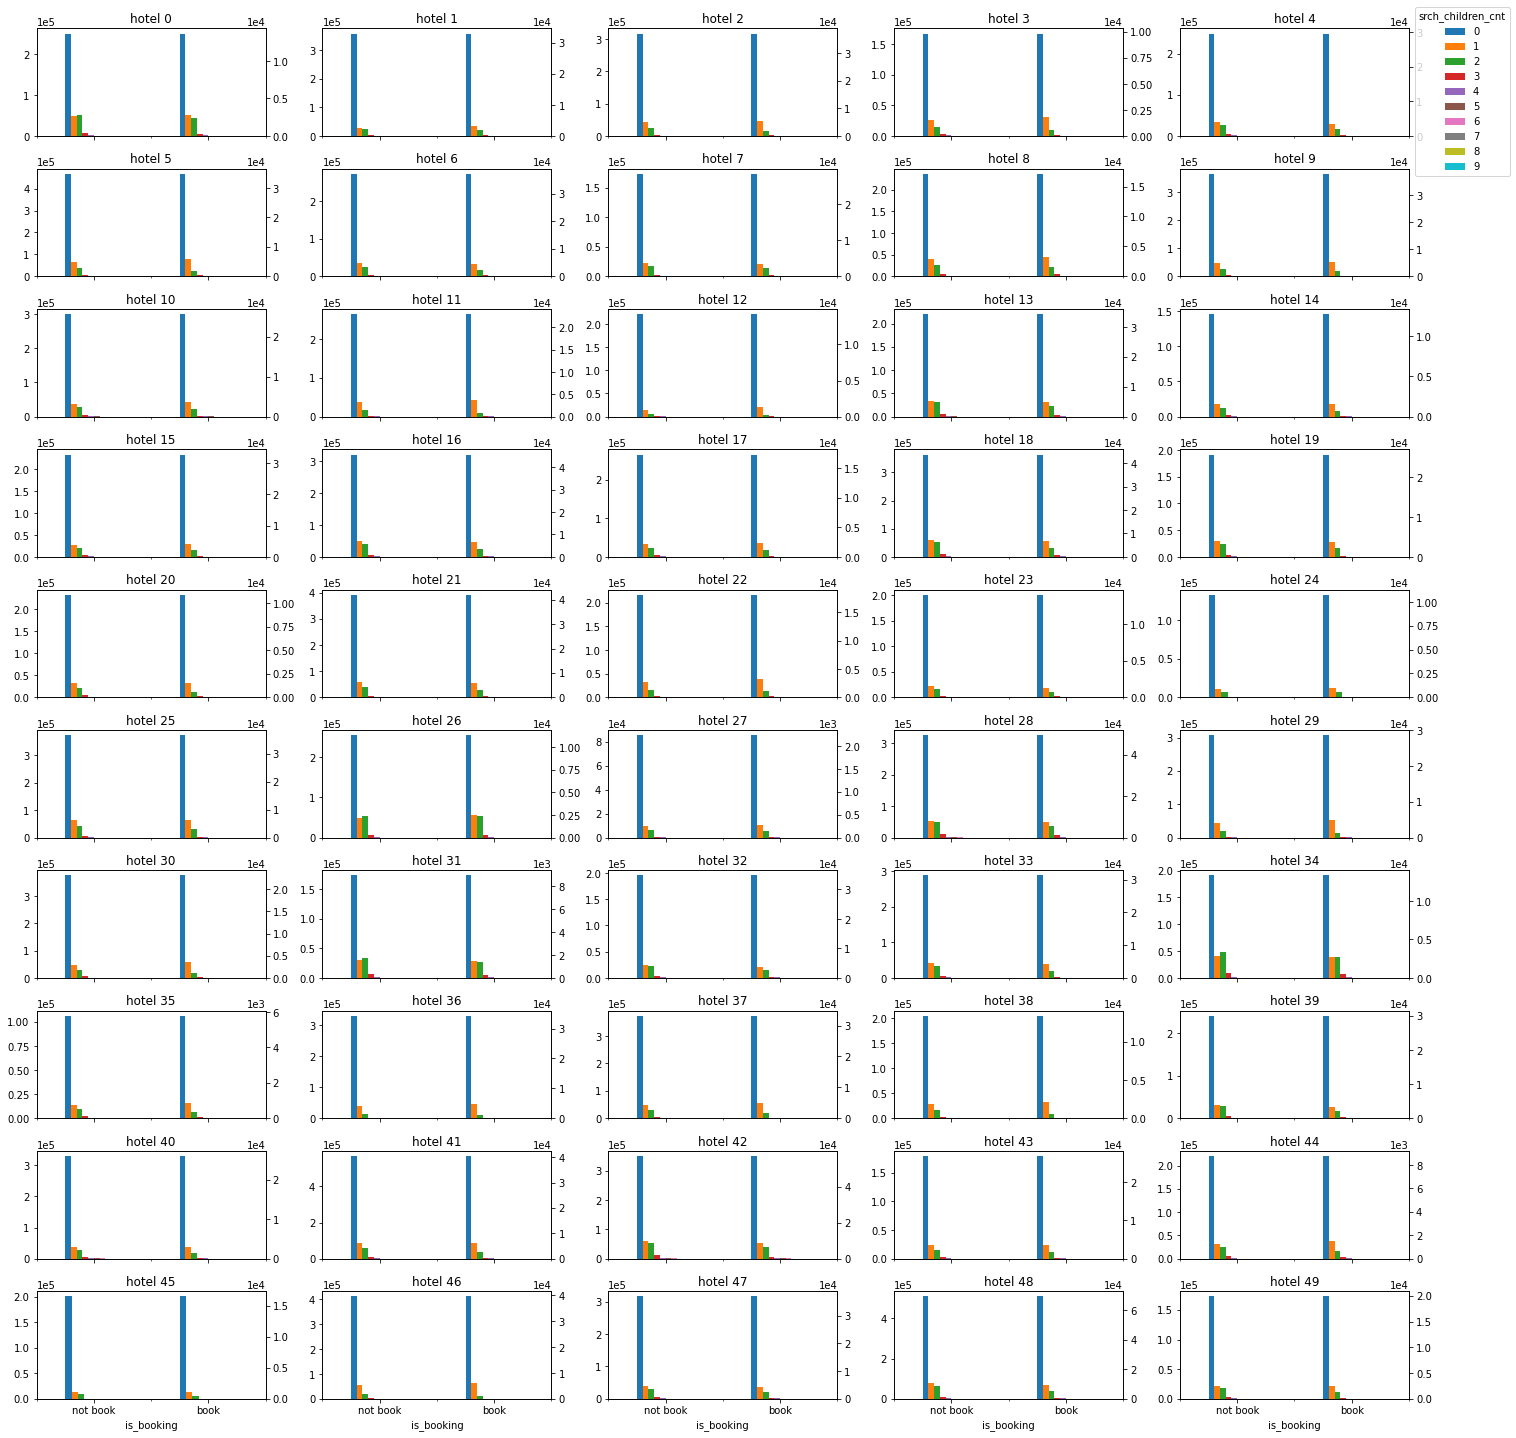

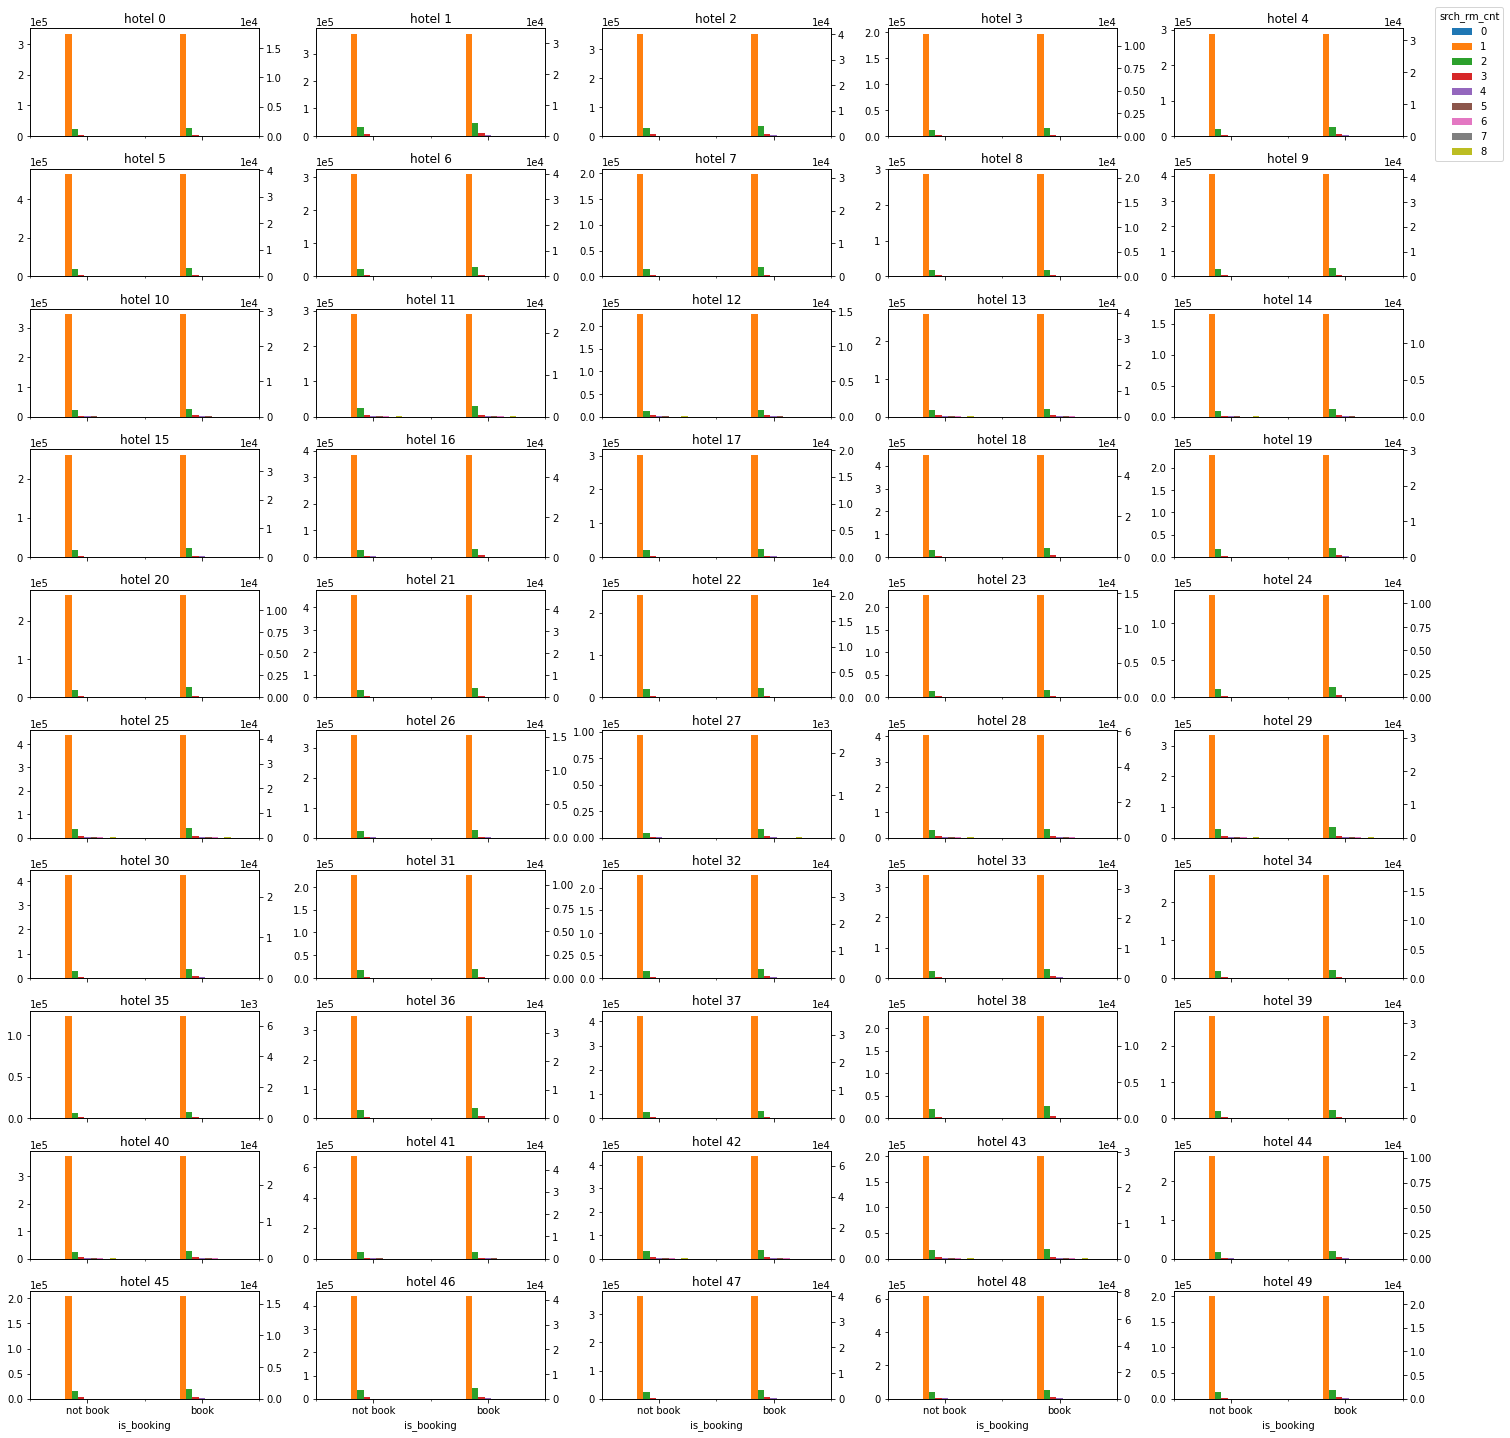

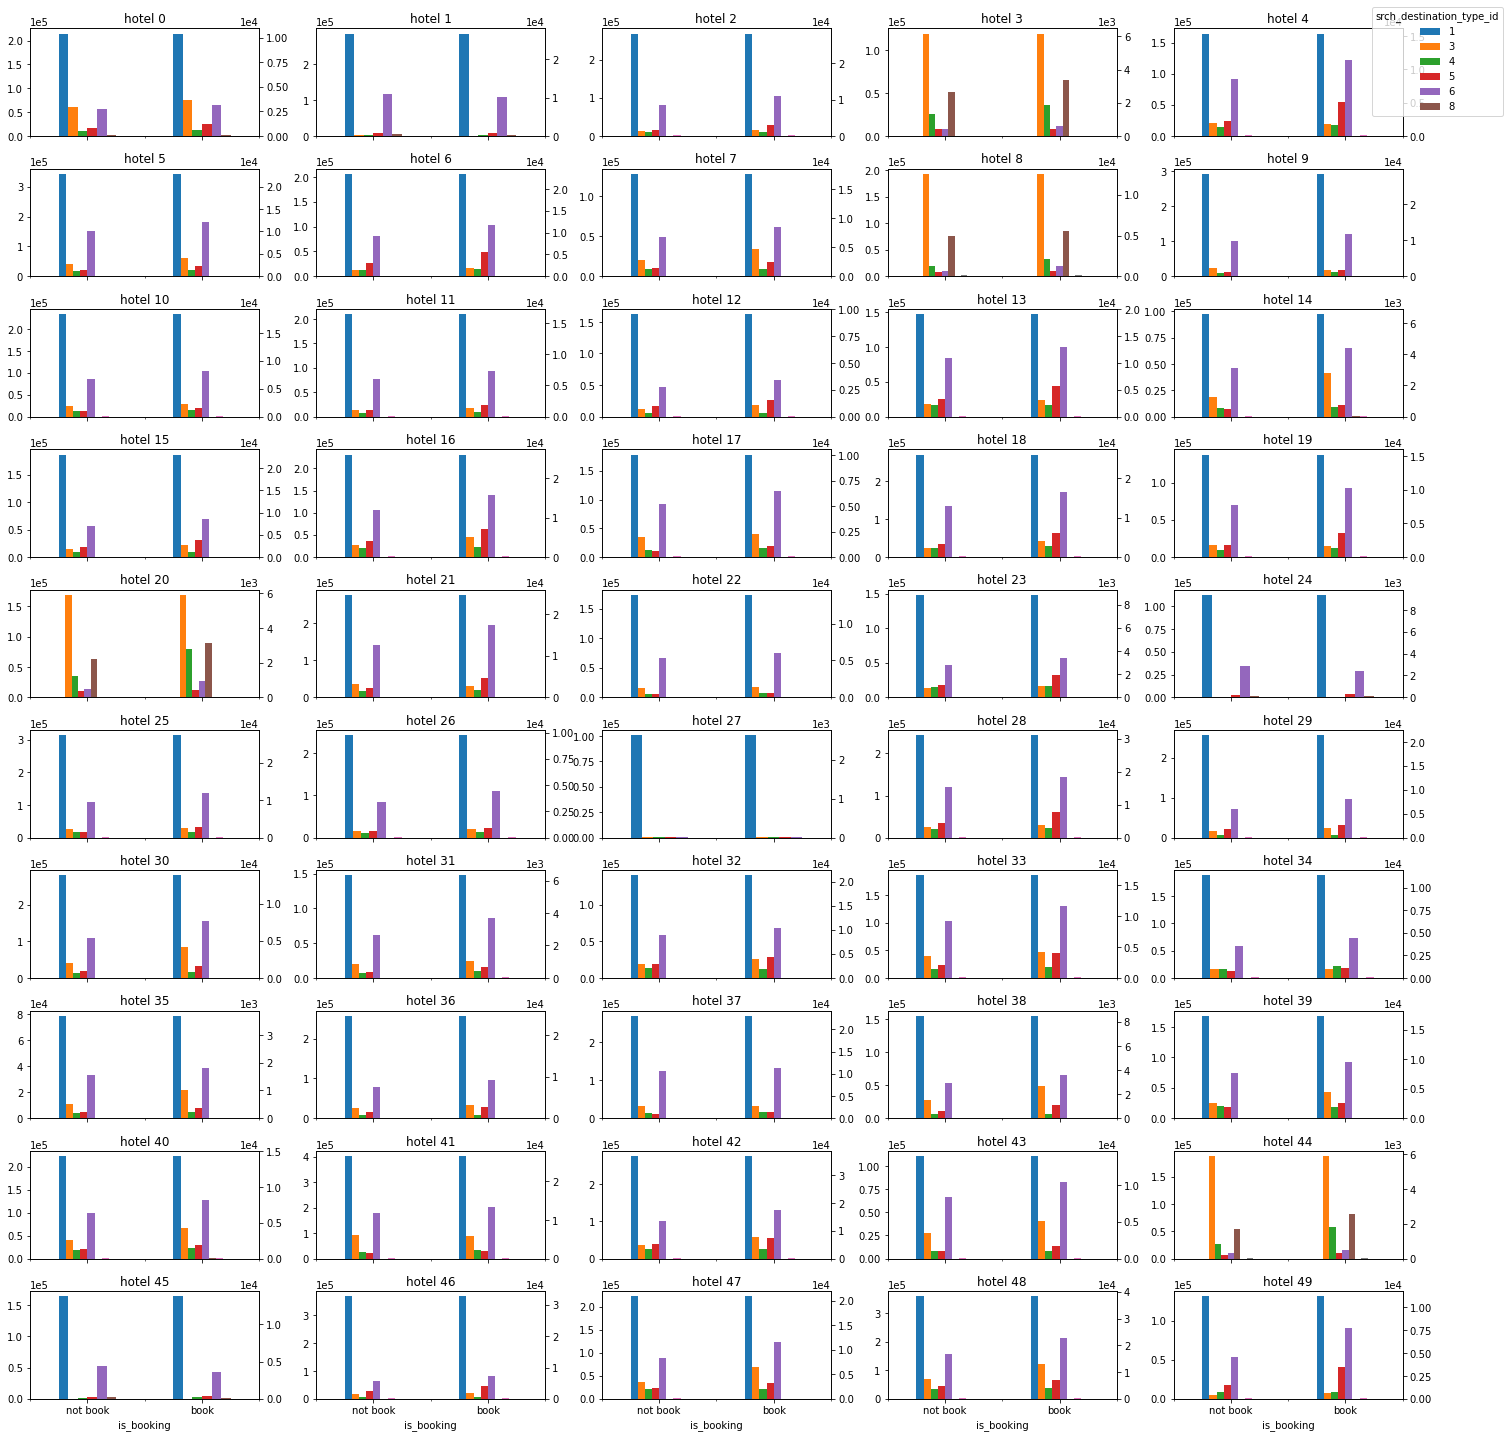

In [90]:
plot_categ_col = ['is_mobile','is_package','channel','srch_adults_cnt', 'srch_children_cnt','srch_rm_cnt','srch_destination_type_id']
for k in plot_categ_col:
    if len(train.groupby(k).size()) <= 4:
        col_num = 10
    else:
        col_num = 5

    fig,axs = plt.subplots(10,col_num, sharex=True, figsize=(20,20))
    axs2=[]
    for i in range(10):
        for j in range(col_num):
            plot_data = train[train['hotel_cluster'] == i*col_num+j].groupby(['is_booking', k]).count()['hotel_cluster']
            plot_data_1 = plot_data.copy()
            plot_data[plot_data.index.get_level_values('is_booking') == 1] = 0
            plot_data_1[plot_data_1.index.get_level_values('is_booking') == 0] = 0
            plot_data.unstack(k).plot.bar(ax=axs[i,j], legend=False)
            axs[i,j].ticklabel_format(axis='y', scilimits=(0,0))

            axs2.append(axs[i,j].twinx())
            plot_data_1.unstack(k).plot.bar(ax=axs2[i*col_num+j], legend=False)
            axs2[i*col_num+j].ticklabel_format(axis='y', scilimits=(0,0))
            axs[i,j].set_title('hotel '+str(i*col_num+j))
            axs[i,j].set_xticklabels(['not book','book'], rotation = 0)
    fig.tight_layout()
    handles, labels = axs[0,0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper right', title=k)
    plt.savefig(f'./imgs/categ data twiny/{k}.png', bbox_extra_artists=(lgd,), bbox_inches='tight')

* 'is_package', 'srch_destination_id', 'channel', 'srch_adults_cnt', 'srch_children_cnt' can be used to set apart hotel clusters and decide if it was a booking search.
* It seems is_package has huge difference between hotel clusters and whether or not booking. 
* srch_destination_id can distinguish a few hotel clusters. It also differs for booking and not booking 


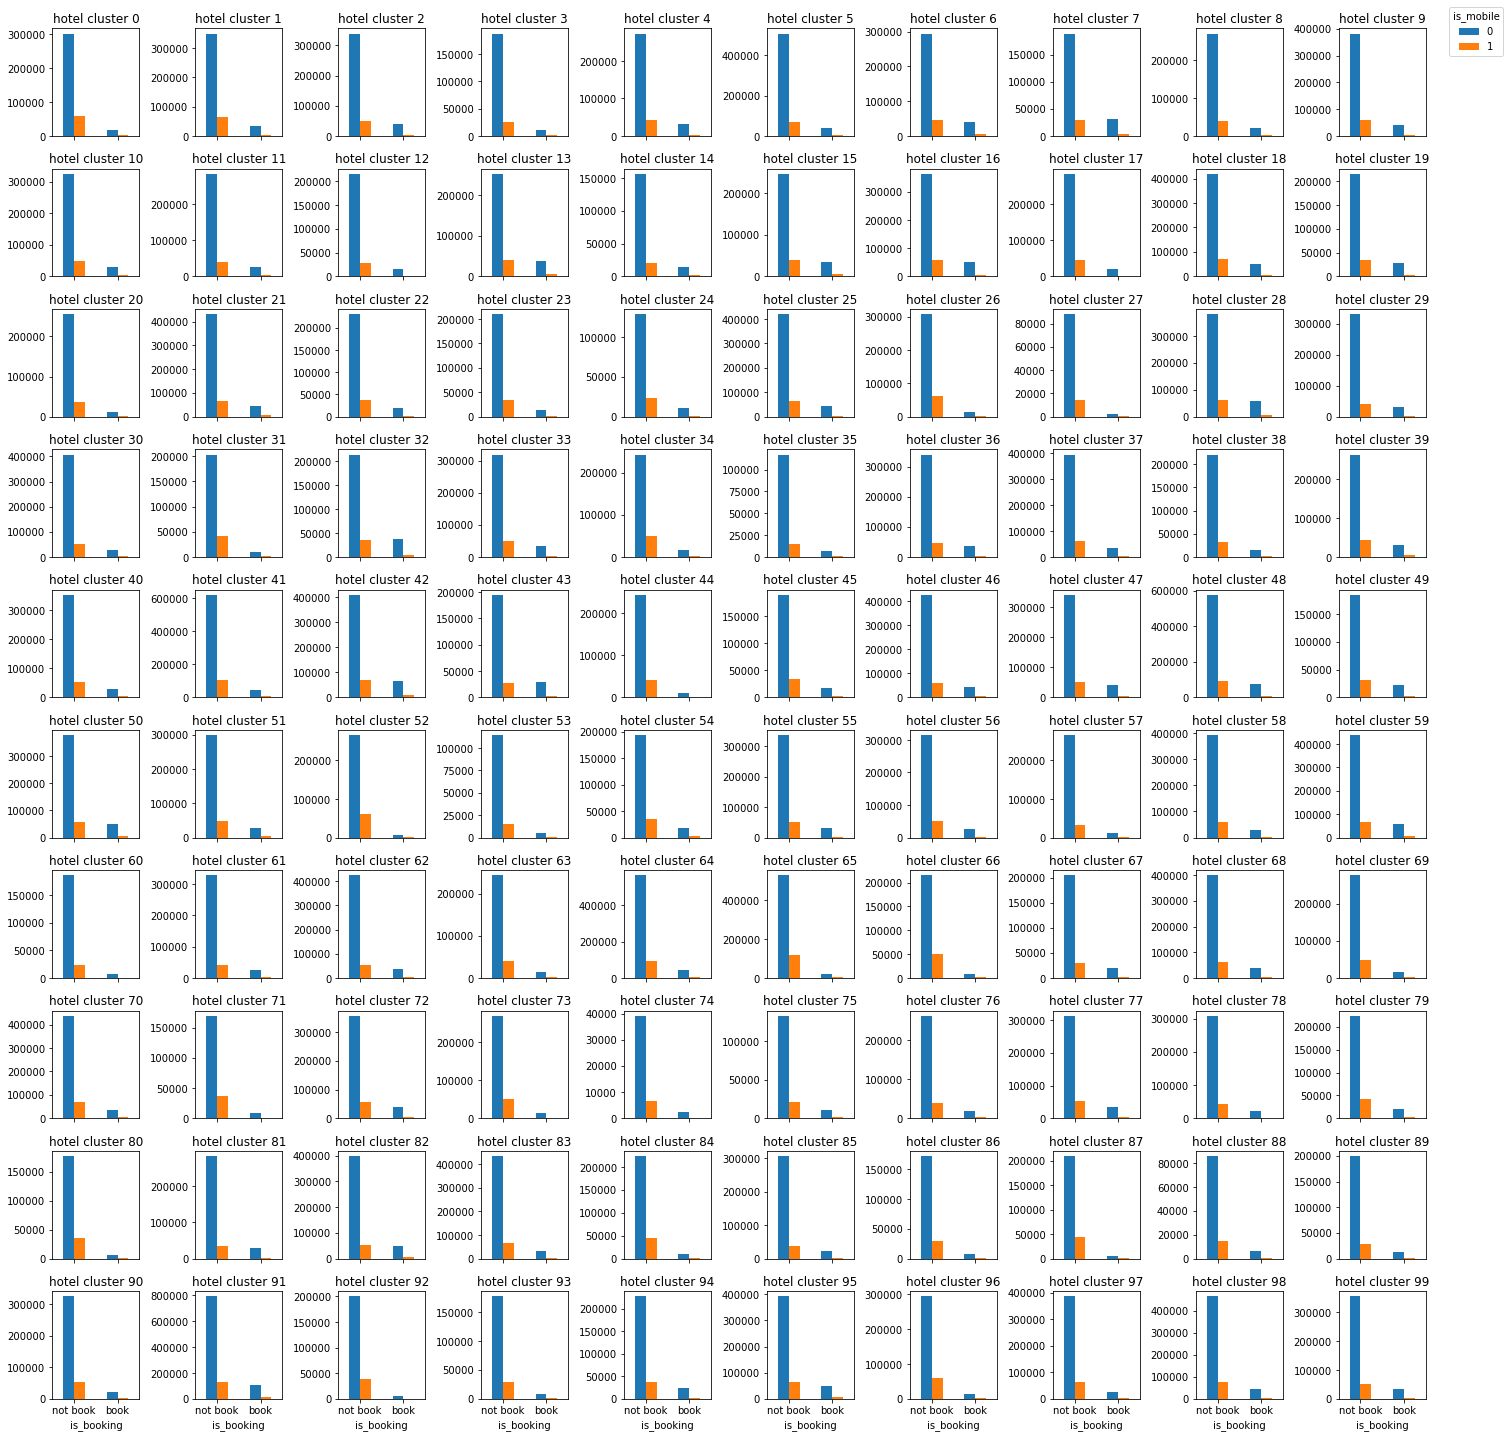

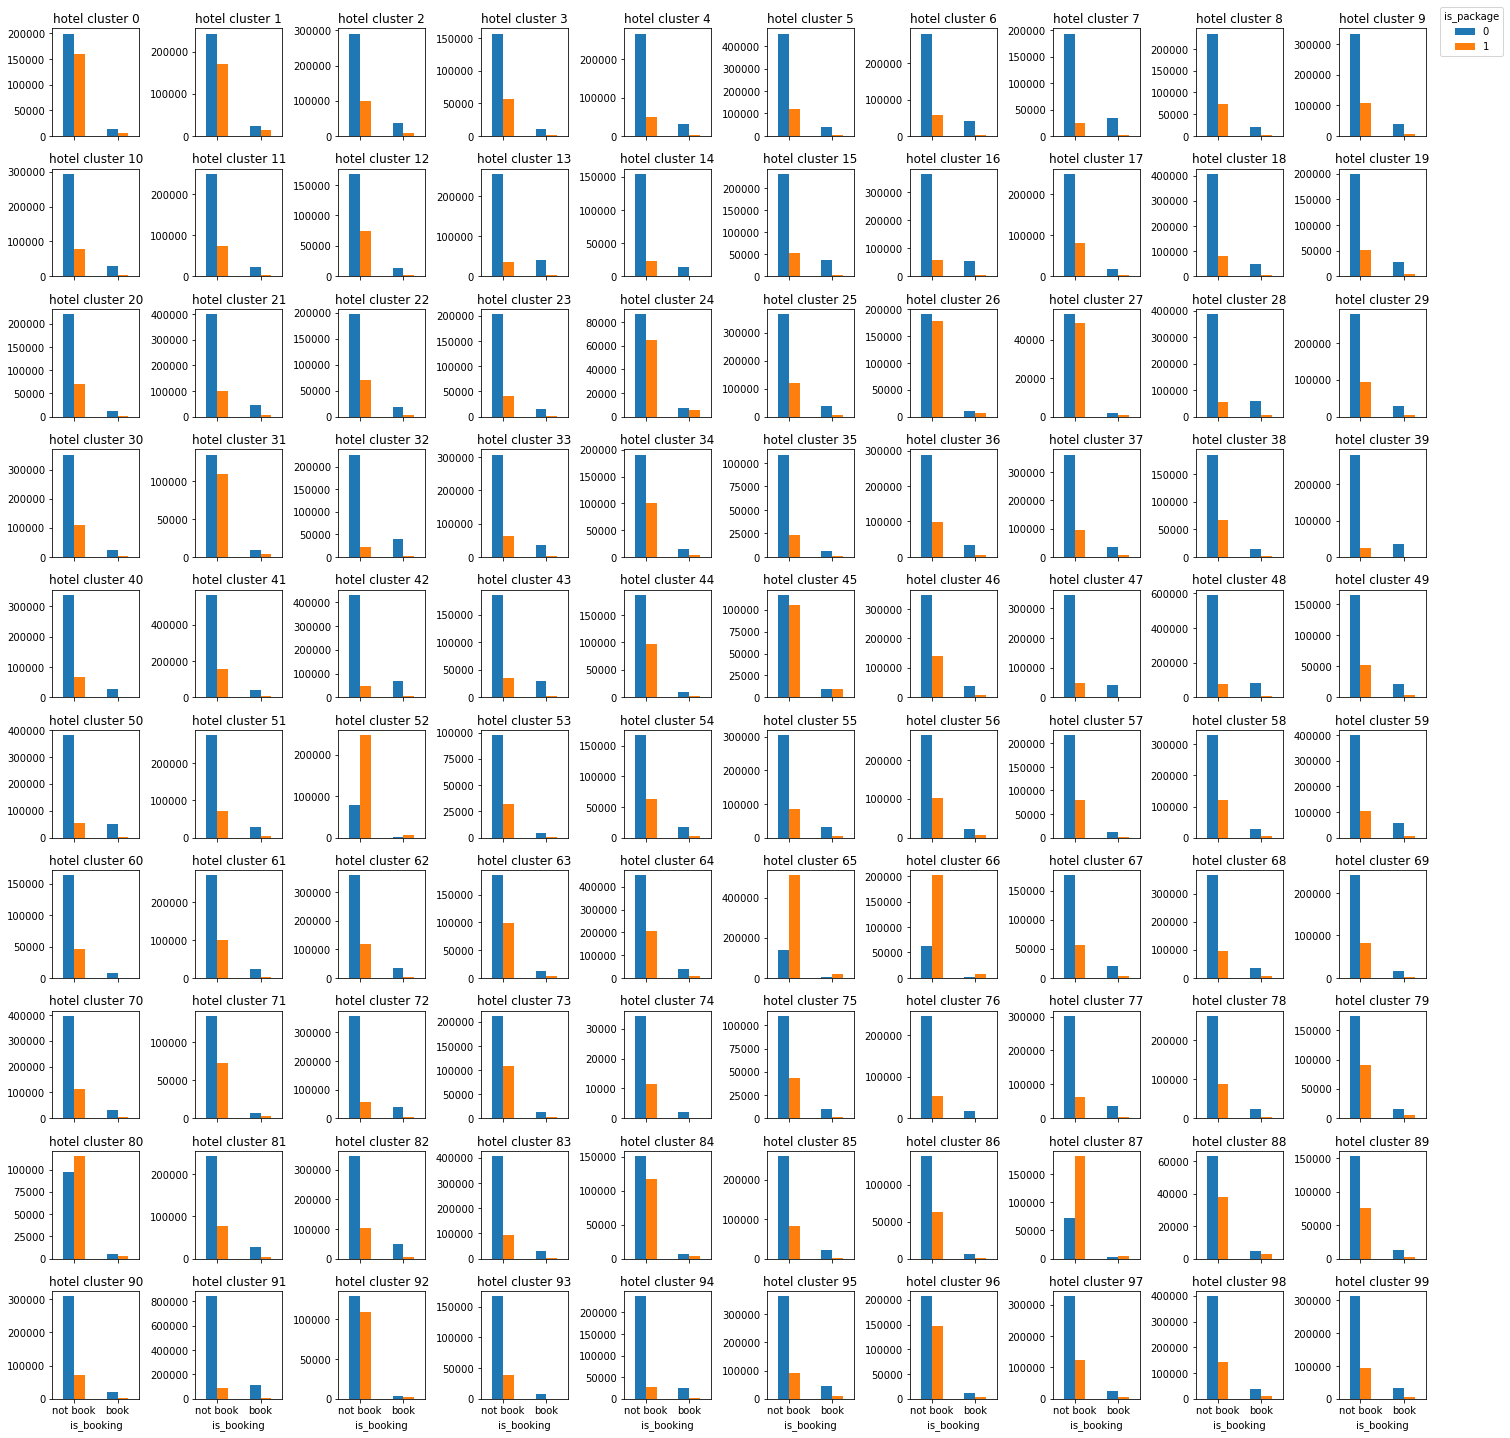

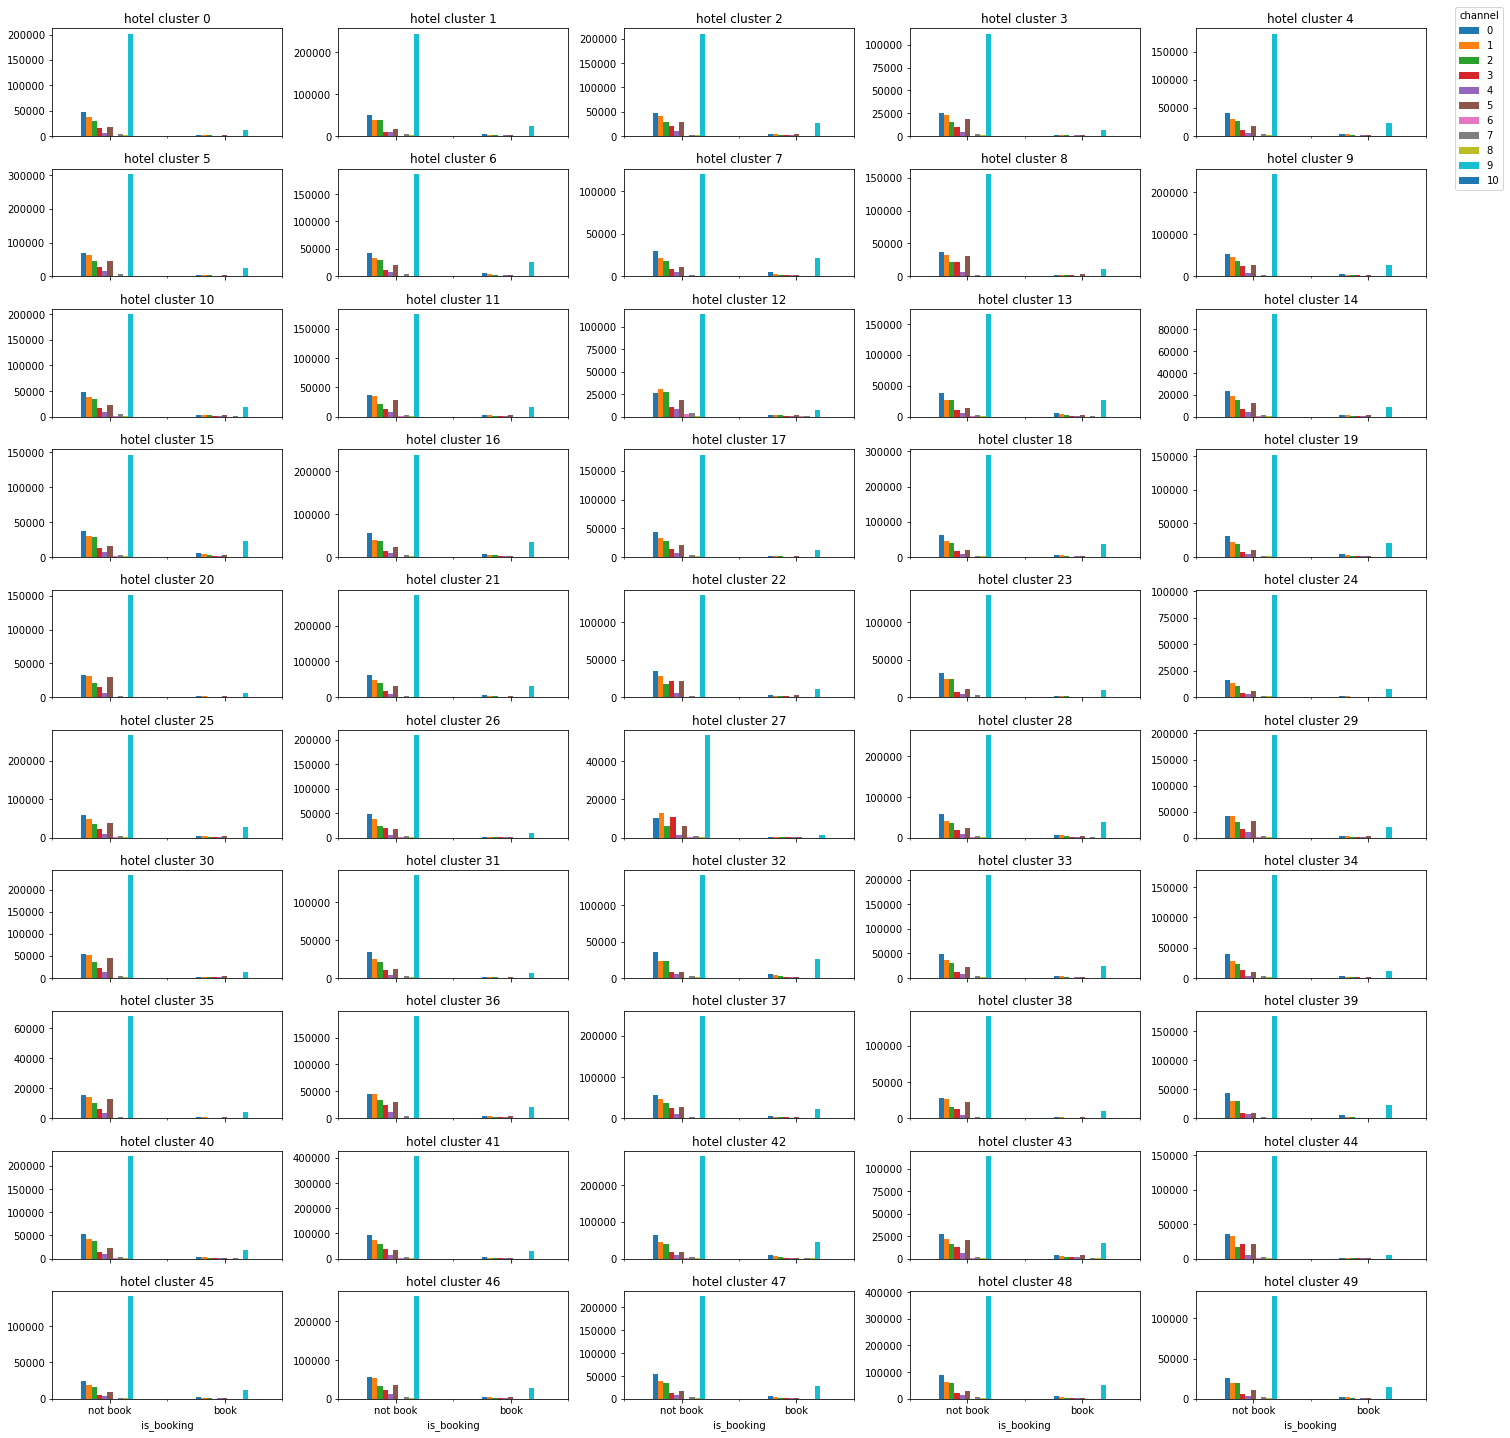

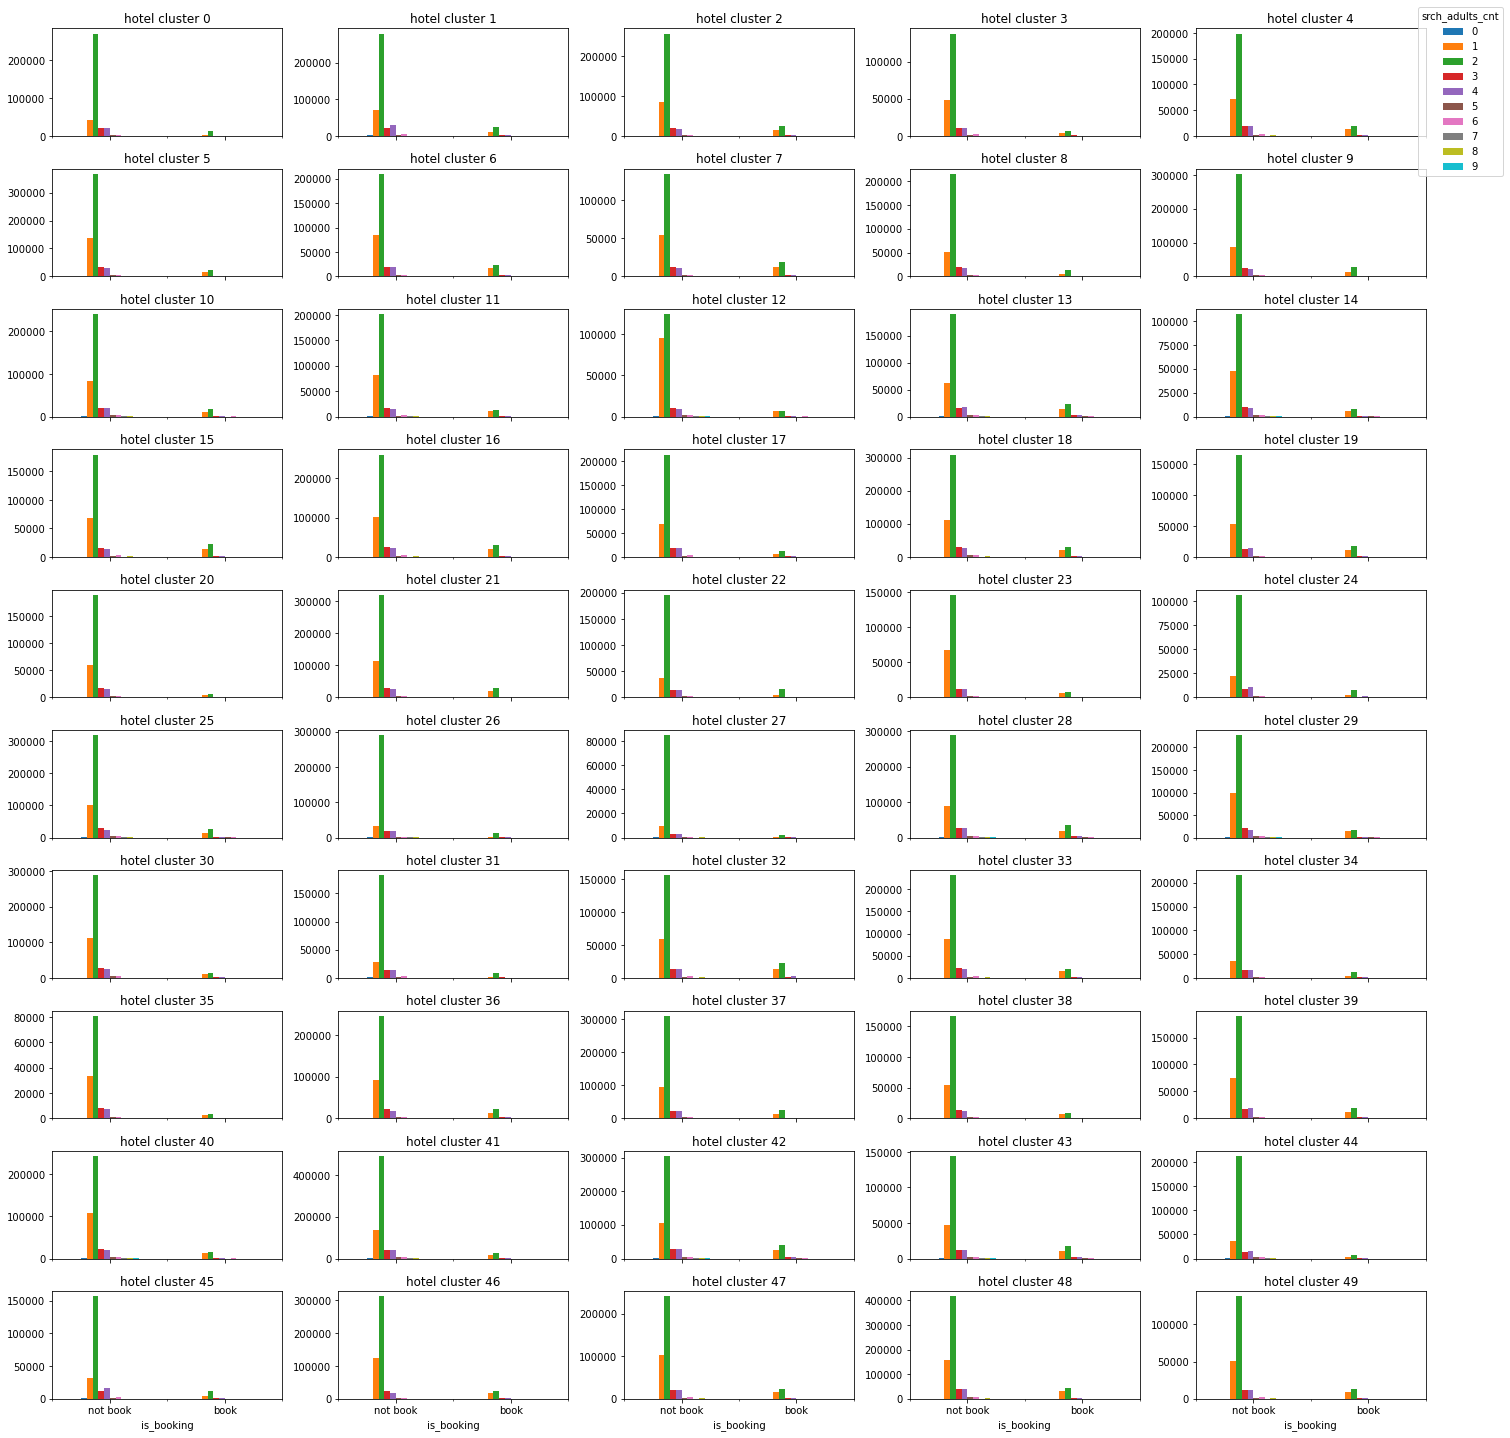

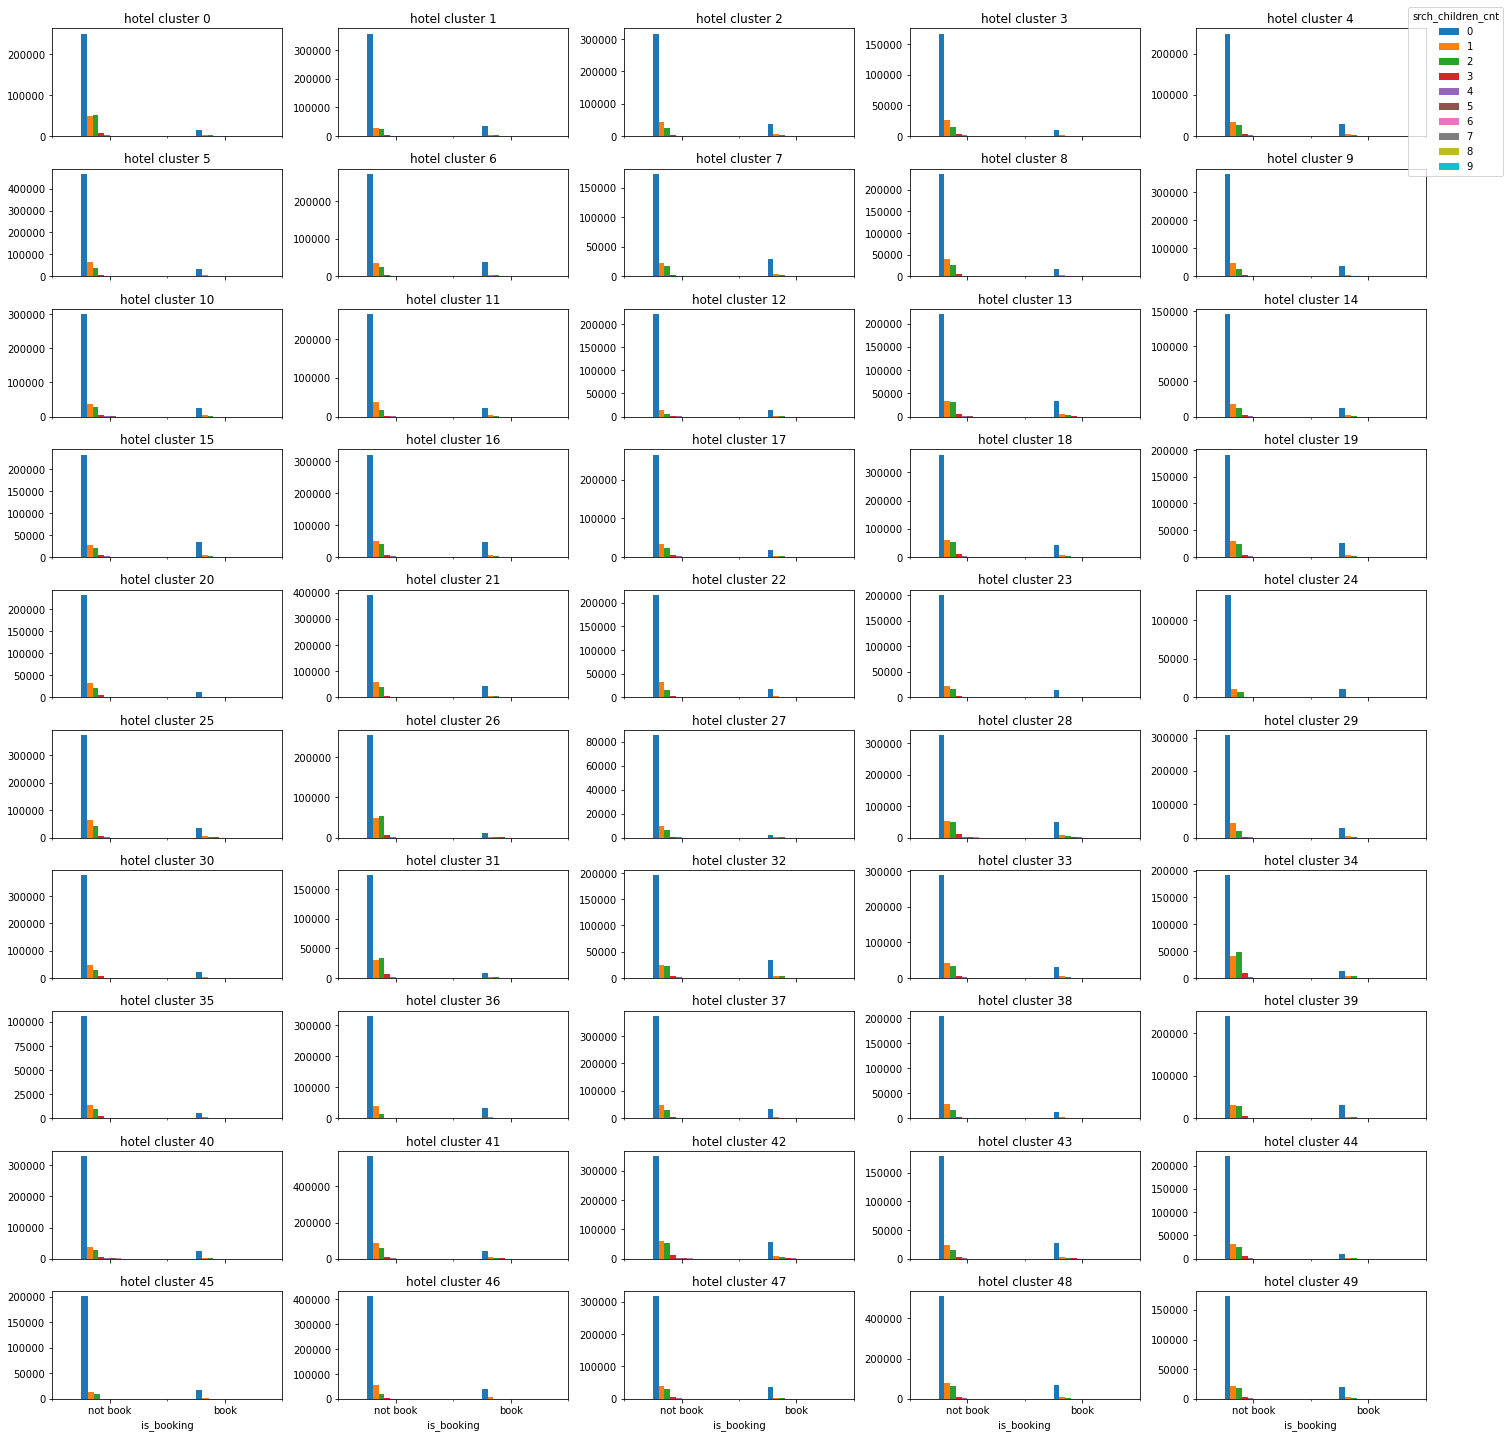

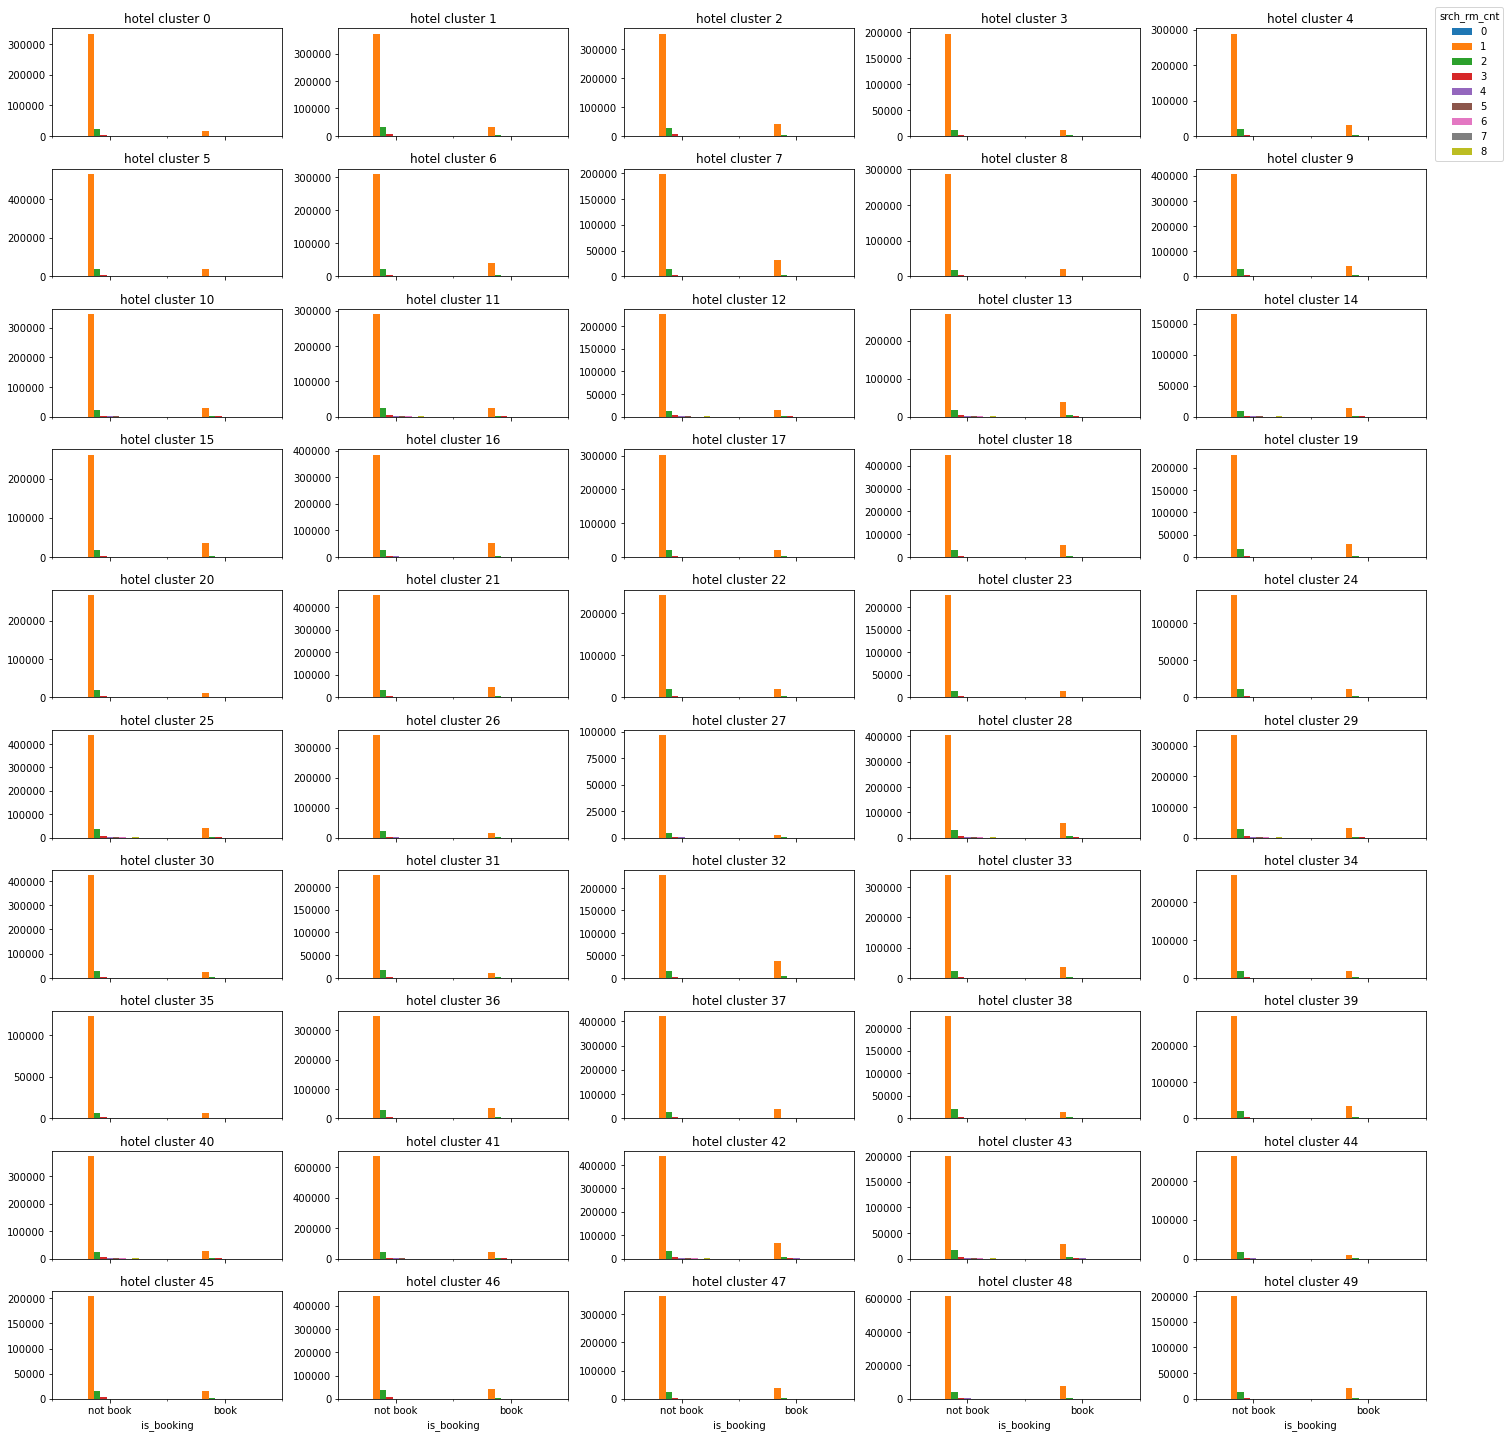

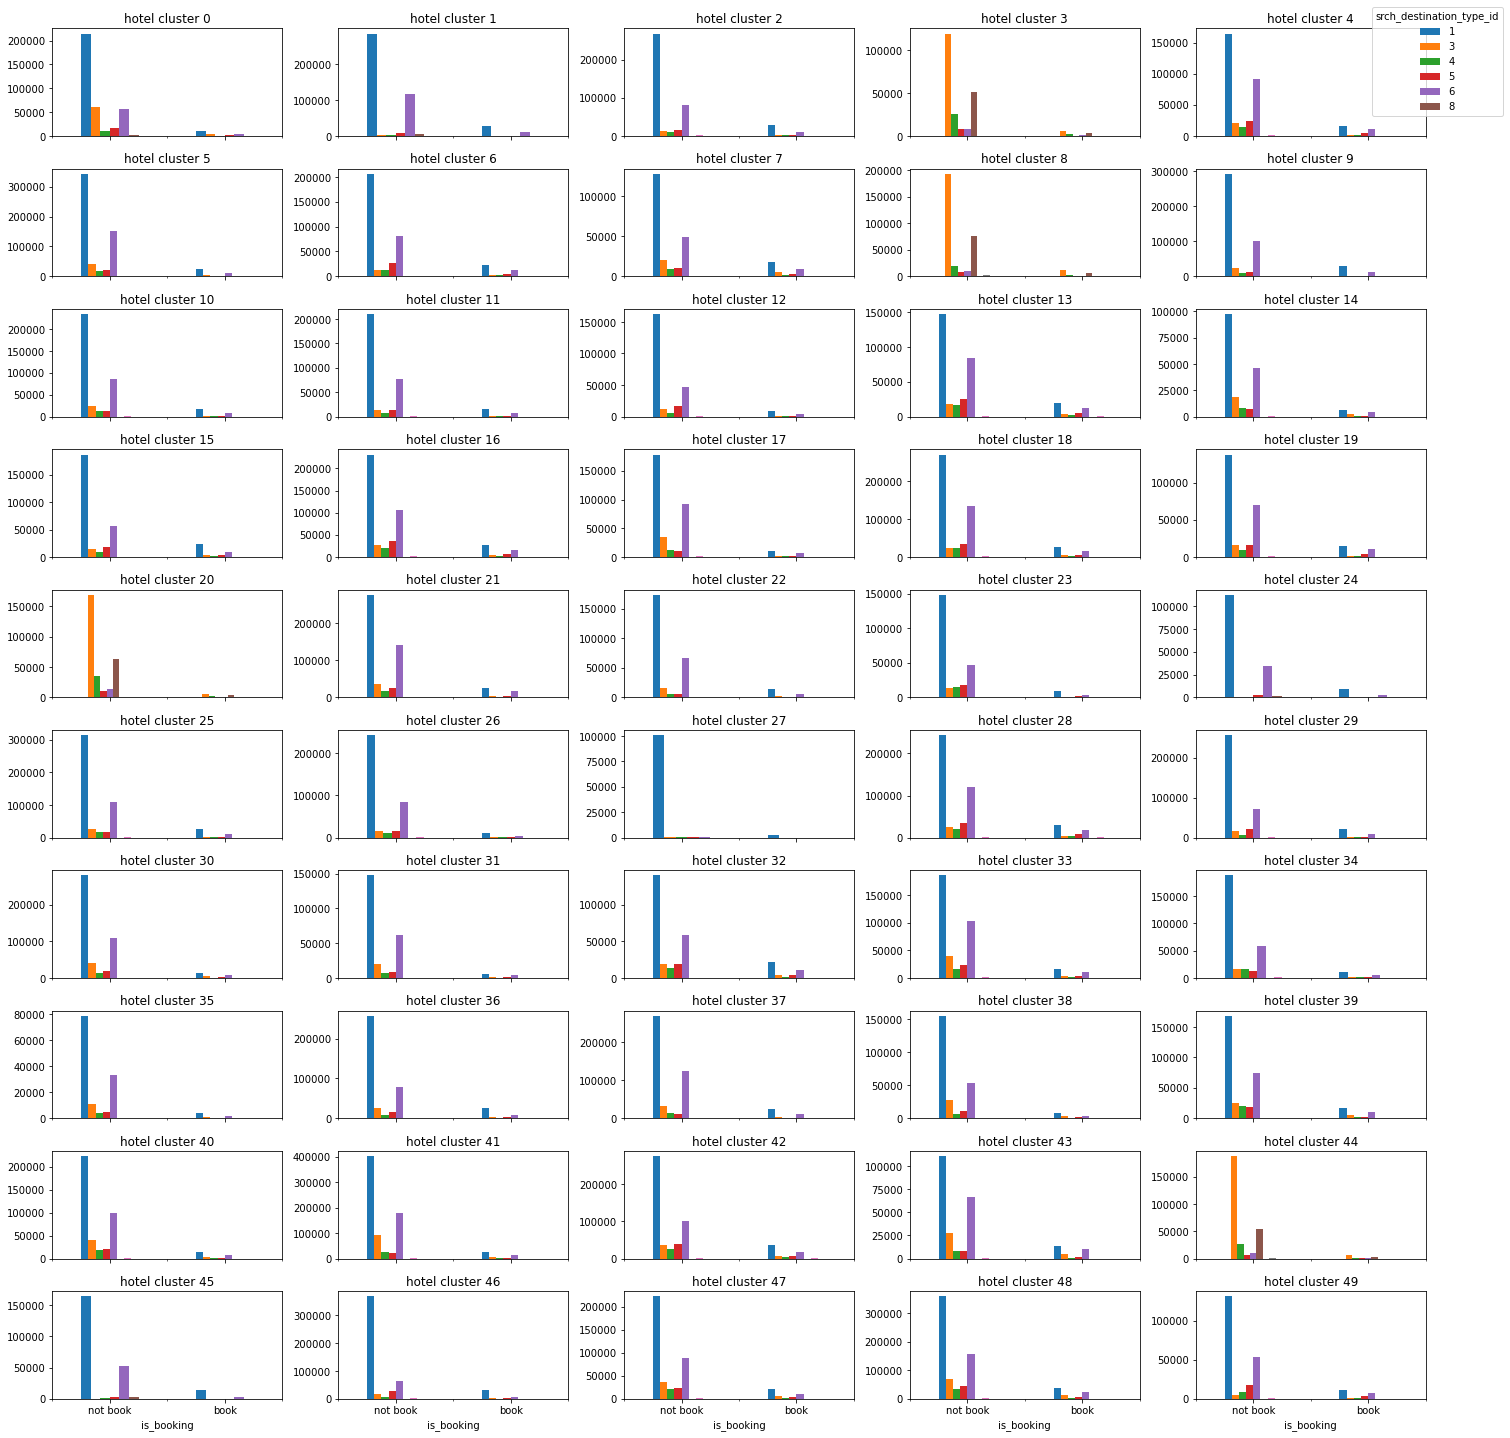

In [62]:
# if plot booking and not booking in same y axis
plot_categ_col = ['is_mobile','is_package','channel','srch_adults_cnt', 'srch_children_cnt','srch_rm_cnt','srch_destination_type_id']
for k in plot_categ_col:
    if len(train.groupby(k).size()) <= 4:
        col_num = 10
    else:
        col_num = 5

    fig,axs = plt.subplots(10,col_num, sharex=True, figsize=(20,20))
    for i in range(10):
        for j in range(col_num):
            plot_data = train[train['hotel_cluster'] == i*col_num+j].groupby(['is_booking', k]).count()['hotel_cluster'].unstack(k).plot.bar(ax=axs[i,j], legend=False)
            axs[i,j].set_title('hotel cluster '+str(i*col_num+j))
            axs[i,j].set_xticklabels(['not book','book'], rotation = 0)
    fig.tight_layout()
    handles, labels = axs[0,0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper right', title=k)
    plt.savefig(f'./imgs/categ data/{k}.png', bbox_extra_artists=(lgd,), bbox_inches='tight')
#plot_data

In [13]:
%reset_selective train_d

## Colinear?

In [10]:
train_corr = train.corr()

In [12]:
train_corr

srch_before_ci  site_name  posa_continent  \
srch_before_ci                   1.000000   0.070469       -0.053967   
site_name                        0.070469   1.000000       -0.634817   
posa_continent                  -0.053967  -0.634817        1.000000   
user_location_country           -0.000412   0.166413        0.175936   
user_location_region             0.071860   0.128214       -0.028502   
user_location_city               0.005644  -0.016054        0.038822   
orig_destination_distance        0.275976   0.030325        0.048051   
user_id                          0.007288   0.024071       -0.011156   
is_mobile                        0.006367  -0.007104        0.016299   
is_package                       0.192215   0.051813       -0.094097   
channel                         -0.042736  -0.029738        0.092033   
srch_adults_cnt                  0.103440  -0.009045        0.007997   
srch_children_cnt                0.055403  -0.032234        0.033723   
srch_rm_cnt                      0.023598   0.015661       -0.031600   
srch_destination_id             -0.042003   0.029020       -0.012436   
srch_destination_type_id        -0.054919  -0.010693        0.042590   
is_booking                      -0.083098  -0.010379        0.009724   
cnt                              0.027404   0.020028       -0.014848   
hotel_continent                  0.119163   0.202756       -0.333605   
hotel_country                    0.026921   0.261031       -0.156398   
hotel_market                    -0.020756  -0.067097        0.050571   
hotel_cluster                    0.022993  -0.022408        0.014938   

                           user_location_country  user_location_region  \
srch_before_ci                         -0.000412              0.071860   
site_name                               0.166413              0.128214   
posa_continent                          0.175936             -0.028502   
user_location_country                   1.000000              0.055364   
user_location_region                    0.055364              1.000000   
user_location_city                      0.123495              0.129756   
orig_destination_distance               0.047720              0.139158   
user_id                                -0.022941             -0.001498   
is_mobile                               0.003611              0.016680   
is_package                             -0.025321              0.038059   
channel                                 0.106040              0.000603   
srch_adults_cnt                         0.037286              0.009084   
srch_children_cnt                       0.036901              0.012350   
srch_rm_cnt                            -0.000212              0.000271   
srch_destination_id                     0.009075              0.022110   
srch_destination_type_id                0.030556              0.009860   
is_booking                              0.007526              0.006352   
cnt                                     0.002761             -0.008889   
hotel_continent                        -0.067253              0.045929   
hotel_country                           0.094649             -0.054500   
hotel_market                            0.018212              0.044987   
hotel_cluster                          -0.010477              0.007453   

                           user_location_city  orig_destination_distance  \
srch_before_ci                       0.005644                   0.275976   
site_name                           -0.016054                   0.030325   
posa_continent                       0.038822                   0.048051   
user_location_country                0.123495                   0.047720   
user_location_region                 0.129756                   0.139158   
user_location_city                   1.000000                   0.012780   
orig_destination_distance            0.012780                   1.000000   
user_id                             -0.006873              

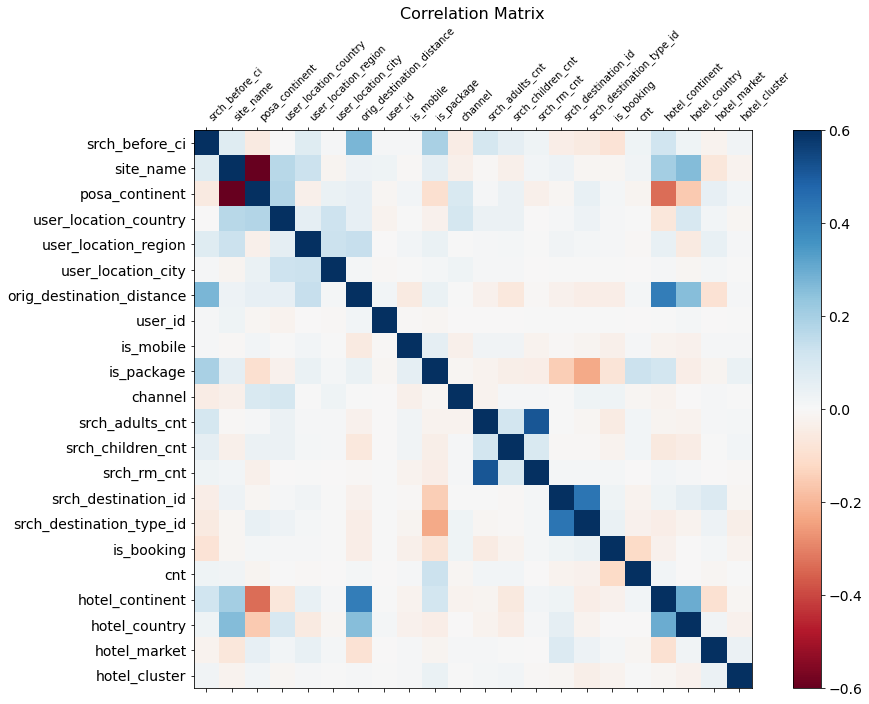

In [23]:
f = plt.figure(figsize=(15, 10))
plt.matshow(train_corr, vmin=-0.6, vmax=0.6, fignum=f.number, cmap='RdBu')
plt.xticks(
    range(train_corr.select_dtypes(['number']).shape[1]), train_corr.select_dtypes(['number']).columns, rotation=45, ha='left'
)
plt.yticks(range(train_corr.select_dtypes(['number']).shape[1]), train_corr.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
plt.show()

almost no clear correlation between target column and feature columns. ordinal encoding as given won't work, we have to use one-hot or targer encoding

<font color='orange'>
    why are these cov numbers > 1? 
</font>

In [96]:
# code referenced from kj2546 hw1
cor_matrix = train.cov()
upper_triang = np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool)
to_consider = cor_matrix.where(upper_triang).abs()
drop_cols = [col for col in to_consider.columns if (to_consider[col] >= .9).sum() > 0]
train_wo_colinear_fts = train.drop(columns=drop_cols)
print(drop_cols)
train_wo_colinear_fts.head()

<ipython-input-96-cbab545ee2b4>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper_triang = np.triu(np.ones(cor_matrix.shape), k=1).astype(np.bool)


['posa_continent', 'user_location_country', 'user_location_region', 'user_location_city', 'orig_destination_distance', 'user_id', 'is_mobile', 'is_package', 'channel', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'srch_destination_id', 'srch_destination_type_id', 'is_booking', 'cnt', 'hotel_continent', 'hotel_country', 'hotel_market', 'hotel_cluster']


date_time  site_name     srch_ci     srch_co
0  2014-08-11 07:46:59          2  2014-08-27  2014-08-31
1  2014-08-11 08:22:12          2  2014-08-29  2014-09-02
2  2014-08-11 08:24:33          2  2014-08-29  2014-09-02
3  2014-08-09 18:05:16          2  2014-11-23  2014-11-28
4  2014-08-09 18:08:18          2  2014-11-23  2014-11-28

## Cleaning
- how we handle NaNs (and explanations)
- should we remove user_id from data (and explanation)?